In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title):
    npimg = img.numpy()
    plt.figure()
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

# MNIST Data

In [3]:
LEARNING_RATE = 3e-4
BETAS = (0.5, 0.999)
BATCH_SIZE = 128

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/MNIST/', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/MNIST/', train=False, 
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# FaderNetwork Model

In [5]:
from models import SmallFaderAE
from models import SimpleClassifier

In [6]:
device = torch.device("cuda")

In [7]:
ae_model = SmallFaderAE(num_attributes=10).to(device)
disc_model = SimpleClassifier(input_dim=20, num_classes=10).to(device)
ae_optim = optim.Adam(ae_model.parameters(), lr=LEARNING_RATE, betas=BETAS)
disc_optim = optim.Adam(disc_model.parameters(), lr=LEARNING_RATE, betas=BETAS)

In [8]:
ae_model

SmallFaderAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
disc_model

SimpleClassifier(
  (linears): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
    (3): Linear(in_features=16, out_features=13, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3)
    (6): Linear(in_features=13, out_features=10, bias=True)
    (7): Softmax()
  )
)

In [10]:
def to_one_hot(classes, num_classes):
    batch_size = classes.shape[0]
    ret = torch.zeros((batch_size, num_classes))
    for i in range(batch_size):
        ret[i][classes[i]] = 1
    return ret

In [11]:
from torch.autograd import Variable

def train(epoch):
    ae_model.train()
    disc_model.train()

    sum_disc_loss = 0
    sum_disc_acc = 0
    sum_rec_loss = 0
    sum_adv_loss = 0
    sum_fader_loss = 0
    
    final_disc_penal_weight = 50.0

    for data, digits in tqdm(train_loader):
        
        data = data.to(device)
        digits = digits.to(device)
        hot_digits = to_one_hot(digits, 10).to(device)

        # Encode data
        z = ae_model.encode(data)
        
        # Train discriminator
        disc_optim.zero_grad()
        digit_preds = disc_model(z)
        disc_loss = F.cross_entropy(digit_preds, digits, reduction='sum')
        sum_disc_loss += disc_loss.item()

        disc_loss.backward()
        disc_optim.step()
        
        # Compute discriminator accuracy
        _, digit_preds_argmax = torch.max(digit_preds, 1)
        disc_acc = torch.sum(digit_preds_argmax == digits).float()
        sum_disc_acc += disc_acc
        
        # Compute discriminator peanlization weight based on schedule
        c = 5
        if epoch < c:
            curr_disc_penal_weight = 0
        else:
            curr_disc_penal_weight = min(1, (epoch - c) / 55) * final_disc_penal_weight
        
        # Compute fader loss
        ae_model.zero_grad()
        reconst_batch = ae_model.decode(z, hot_digits)
        rec_loss = F.binary_cross_entropy(reconst_batch, data, reduction='sum')
        sum_rec_loss += rec_loss.item()
        
        digit_preds_to_fool = disc_model(z)
        adv_loss = F.cross_entropy(digit_preds_to_fool, digits, reduction='sum')
        sum_adv_loss += adv_loss.item()
        
        fader_loss = rec_loss - curr_disc_penal_weight*adv_loss
        sum_fader_loss += fader_loss.item()        
        
        # Train auto encoder
        fader_loss.backward()
        ae_optim.step()
        
        
    train_size = len(train_loader.dataset)
    print('====> Epoch: {} Fader Loss: {:.4f} | Adv Loss: {:.4f} | Rec Loss: {:.4f} \n\t| Adj Disc Loss: {:.4f} | Disc Acc: {:.4f}'.format(
          epoch, sum_fader_loss/train_size, sum_adv_loss/train_size, 
        sum_rec_loss/train_size, curr_disc_penal_weight*sum_disc_loss/train_size, sum_disc_acc/train_size))

def test(epoch):
    ae_model.eval()
    disc_model.eval()
    with torch.no_grad():
        for data_batch, digits in tqdm(test_loader):
            data_batch = data_batch[:10].to(device)
            digits = digits[:10].to(device)
            
            hot_digits = to_one_hot(digits, 10).to(device)

            batch_z = ae_model.encode(data_batch)
            
            assert batch_z.shape[0] == 10

            faders = torch.eye(10).to(device)

            show(make_grid(data_batch.detach().cpu(), nrow=10), 'True {}'.format(epoch))

            reconst = ae_model.decode(batch_z, hot_digits).cpu()
            show(make_grid(reconst.view(10, 1, 28, 28), nrow=10), 'True Reconst {}'.format(epoch))

            fader_reconst = ae_model.decode(batch_z, faders).cpu()
            show(make_grid(fader_reconst.view(10, 1, 28, 28), nrow=10), 'Fader Reconst {}'.format(epoch))
            break

In [12]:
dataset = train_loader.dataset

In [13]:
ae_path = 'weights/{}_{}.pt'.format(ae_model.__class__.__name__, dataset.__class__.__name__)
ae_path

'weights/SmallFaderAE_MNIST.pt'

In [14]:
epochs_trained_path = ae_path[:-3] + '_epochs.npy'
epochs_trained_path

'weights/SmallFaderAE_MNIST_epochs.npy'

In [15]:
disc_path = 'weights/{}_{}.pt'.format(disc_model.__class__.__name__, dataset.__class__.__name__)
disc_path

'weights/SimpleClassifier_MNIST.pt'

In [16]:
def save(epoch):
    torch.save(ae_model.state_dict(), ae_path)
    torch.save(disc_model.state_dict(), disc_path)
    np.save(epochs_trained_path, epoch)

In [17]:
import os

def load():
    epochs_trained = 0
    if os.path.exists(ae_path) and os.path.exists(disc_path) and os.path.exists(epochs_trained_path):
        ae_model.load_state_dict(torch.load(ae_path))    
        disc_model.load_state_dict(torch.load(disc_path))
        epochs_trained = np.load(epochs_trained_path) + 1
        print("Loaded with {} epochs trained".format(epochs_trained))
    else:
        print("Starting from scratch")
    return epochs_trained

# Train

### Try to load if possible

In [18]:
epochs_trained = load()

Starting from scratch


### Train!

In [19]:
epochs = 1000

  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 0 Fader Loss: 181.0595 | Adv Loss: 2.1895 | Rec Loss: 181.0595 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.2419


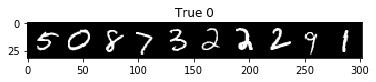

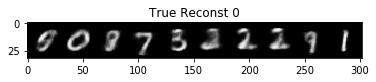

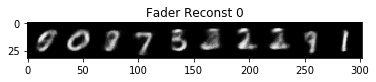


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 1 Fader Loss: 117.3874 | Adv Loss: 1.9688 | Rec Loss: 117.3874 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.4972


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 2 Fader Loss: 104.5255 | Adv Loss: 1.8968 | Rec Loss: 104.5255 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.5721


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 3 Fader Loss: 96.4554 | Adv Loss: 1.8584 | Rec Loss: 96.4554 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.6092


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 4 Fader Loss: 90.9497 | Adv Loss: 1.8377 | Rec Loss: 90.9497 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.6374


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 5 Fader Loss: 86.9075 | Adv Loss: 1.8154 | Rec Loss: 86.9075 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.6532


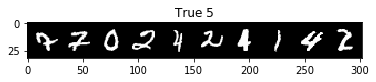

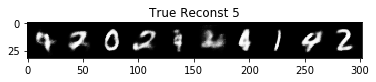

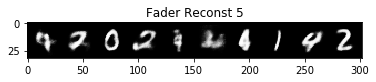


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 6 Fader Loss: 82.3206 | Adv Loss: 1.8015 | Rec Loss: 83.9584 
	| Adj Disc Loss: 4.9178 | Disc Acc: 0.6645


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 7 Fader Loss: 78.0559 | Adv Loss: 1.7930 | Rec Loss: 81.3159 
	| Adj Disc Loss: 9.7880 | Disc Acc: 0.6741


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 8 Fader Loss: 73.9460 | Adv Loss: 1.7922 | Rec Loss: 78.8339 
	| Adj Disc Loss: 14.6473 | Disc Acc: 0.6751


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 9 Fader Loss: 70.4437 | Adv Loss: 1.7887 | Rec Loss: 76.9479 
	| Adj Disc Loss: 19.5197 | Disc Acc: 0.6769


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 10 Fader Loss: 67.3565 | Adv Loss: 1.7894 | Rec Loss: 75.4900 
	| Adj Disc Loss: 24.4215 | Disc Acc: 0.6741


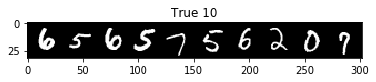

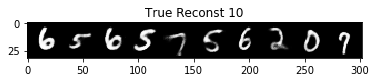

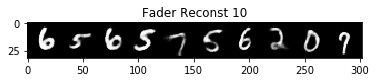


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 11 Fader Loss: 64.5119 | Adv Loss: 1.7916 | Rec Loss: 74.2840 
	| Adj Disc Loss: 29.3357 | Disc Acc: 0.6743


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 12 Fader Loss: 61.7417 | Adv Loss: 1.8009 | Rec Loss: 73.2022 
	| Adj Disc Loss: 34.3896 | Disc Acc: 0.6625


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 13 Fader Loss: 59.1855 | Adv Loss: 1.8174 | Rec Loss: 72.4030 
	| Adj Disc Loss: 39.6609 | Disc Acc: 0.6443


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 14 Fader Loss: 56.6755 | Adv Loss: 1.8399 | Rec Loss: 71.7293 
	| Adj Disc Loss: 45.1535 | Disc Acc: 0.6232


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 15 Fader Loss: 54.3007 | Adv Loss: 1.8505 | Rec Loss: 71.1236 
	| Adj Disc Loss: 50.4850 | Disc Acc: 0.6105


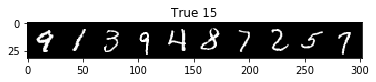

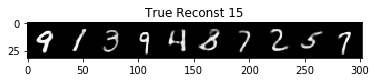

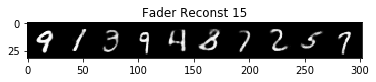


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 16 Fader Loss: 52.0656 | Adv Loss: 1.8658 | Rec Loss: 70.7240 
	| Adj Disc Loss: 56.0208 | Disc Acc: 0.5965


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 17 Fader Loss: 49.8238 | Adv Loss: 1.8762 | Rec Loss: 70.2909 
	| Adj Disc Loss: 61.5409 | Disc Acc: 0.5826


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 18 Fader Loss: 47.6476 | Adv Loss: 1.8917 | Rec Loss: 70.0044 
	| Adj Disc Loss: 67.0861 | Disc Acc: 0.5698


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 19 Fader Loss: 45.4848 | Adv Loss: 1.9179 | Rec Loss: 69.8950 
	| Adj Disc Loss: 73.2772 | Disc Acc: 0.5399


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 20 Fader Loss: 43.4893 | Adv Loss: 1.9715 | Rec Loss: 70.3729 
	| Adj Disc Loss: 80.6417 | Disc Acc: 0.4872


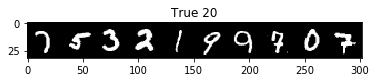

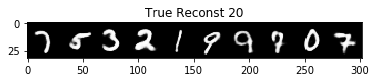

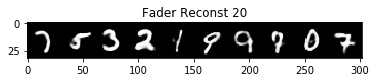


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 21 Fader Loss: 40.7797 | Adv Loss: 2.0078 | Rec Loss: 69.9847 
	| Adj Disc Loss: 87.7127 | Disc Acc: 0.4454


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 22 Fader Loss: 38.5337 | Adv Loss: 2.0478 | Rec Loss: 70.1814 
	| Adj Disc Loss: 95.0036 | Disc Acc: 0.4105


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 23 Fader Loss: 36.4424 | Adv Loss: 2.0786 | Rec Loss: 70.4553 
	| Adj Disc Loss: 102.1915 | Disc Acc: 0.3740


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 24 Fader Loss: 34.0186 | Adv Loss: 2.1190 | Rec Loss: 70.6201 
	| Adj Disc Loss: 109.9631 | Disc Acc: 0.3337


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 25 Fader Loss: 31.7929 | Adv Loss: 2.0972 | Rec Loss: 69.9243 
	| Adj Disc Loss: 114.4143 | Disc Acc: 0.3603


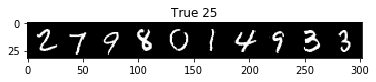

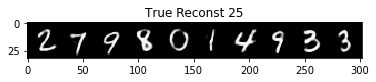

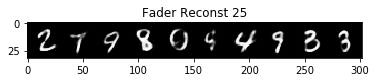


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 26 Fader Loss: 29.8485 | Adv Loss: 2.1026 | Rec Loss: 69.9883 
	| Adj Disc Loss: 120.4540 | Disc Acc: 0.3555


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 27 Fader Loss: 27.9515 | Adv Loss: 2.1118 | Rec Loss: 70.1872 
	| Adj Disc Loss: 126.7304 | Disc Acc: 0.3443


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 28 Fader Loss: 25.4250 | Adv Loss: 2.1258 | Rec Loss: 69.8729 
	| Adj Disc Loss: 133.3455 | Disc Acc: 0.3316


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 29 Fader Loss: 22.9251 | Adv Loss: 2.1546 | Rec Loss: 69.9341 
	| Adj Disc Loss: 141.1183 | Disc Acc: 0.2958


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 30 Fader Loss: 20.7501 | Adv Loss: 2.1763 | Rec Loss: 70.2106 
	| Adj Disc Loss: 148.4188 | Disc Acc: 0.2738


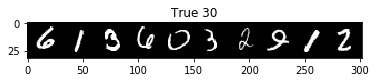

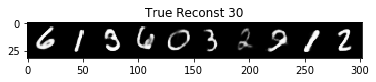

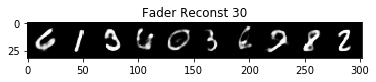


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 31 Fader Loss: 18.5030 | Adv Loss: 2.1746 | Rec Loss: 69.9017 
	| Adj Disc Loss: 154.3511 | Disc Acc: 0.2748


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 32 Fader Loss: 16.1455 | Adv Loss: 2.1850 | Rec Loss: 69.7782 
	| Adj Disc Loss: 161.0957 | Disc Acc: 0.2613


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 33 Fader Loss: 13.9462 | Adv Loss: 2.1975 | Rec Loss: 69.8820 
	| Adj Disc Loss: 167.8650 | Disc Acc: 0.2512


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 34 Fader Loss: 11.7332 | Adv Loss: 2.2050 | Rec Loss: 69.8643 
	| Adj Disc Loss: 174.4284 | Disc Acc: 0.2423


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 35 Fader Loss: 9.5653 | Adv Loss: 2.2056 | Rec Loss: 69.7193 
	| Adj Disc Loss: 180.7031 | Disc Acc: 0.2389


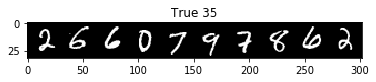

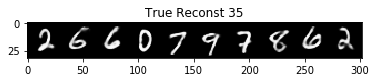

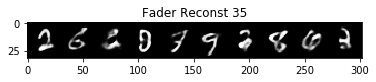


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 36 Fader Loss: 7.2494 | Adv Loss: 2.2154 | Rec Loss: 69.6837 
	| Adj Disc Loss: 187.3199 | Disc Acc: 0.2314


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 37 Fader Loss: 5.0762 | Adv Loss: 2.2160 | Rec Loss: 69.5420 
	| Adj Disc Loss: 193.4312 | Disc Acc: 0.2283


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 38 Fader Loss: 2.6964 | Adv Loss: 2.2290 | Rec Loss: 69.5656 
	| Adj Disc Loss: 200.4796 | Disc Acc: 0.2187


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 39 Fader Loss: 0.4438 | Adv Loss: 2.2367 | Rec Loss: 69.5776 
	| Adj Disc Loss: 207.5346 | Disc Acc: 0.2039


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 40 Fader Loss: -1.8941 | Adv Loss: 2.2407 | Rec Loss: 69.3996 
	| Adj Disc Loss: 214.0443 | Disc Acc: 0.2017


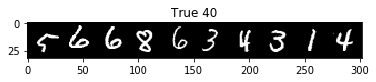

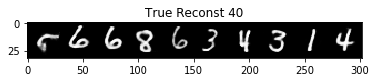

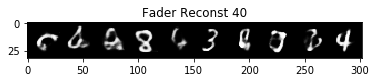


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 41 Fader Loss: -4.0070 | Adv Loss: 2.2479 | Rec Loss: 69.5596 
	| Adj Disc Loss: 220.9305 | Disc Acc: 0.1911


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 42 Fader Loss: -5.8934 | Adv Loss: 2.2448 | Rec Loss: 69.6129 
	| Adj Disc Loss: 226.6645 | Disc Acc: 0.1970


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 43 Fader Loss: -8.3317 | Adv Loss: 2.2485 | Rec Loss: 69.3452 
	| Adj Disc Loss: 233.2141 | Disc Acc: 0.1926


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 44 Fader Loss: -10.6270 | Adv Loss: 2.2516 | Rec Loss: 69.2020 
	| Adj Disc Loss: 239.7815 | Disc Acc: 0.1833


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 45 Fader Loss: -12.8737 | Adv Loss: 2.2536 | Rec Loss: 69.0765 
	| Adj Disc Loss: 245.9054 | Disc Acc: 0.1858


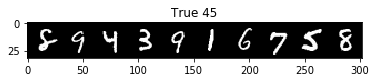

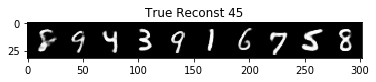

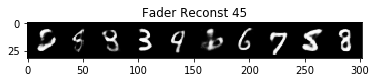


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 46 Fader Loss: -14.8972 | Adv Loss: 2.2523 | Rec Loss: 69.0517 
	| Adj Disc Loss: 252.0099 | Disc Acc: 0.1862


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 47 Fader Loss: -17.2898 | Adv Loss: 2.2678 | Rec Loss: 69.2991 
	| Adj Disc Loss: 259.7740 | Disc Acc: 0.1705


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 48 Fader Loss: -19.0775 | Adv Loss: 2.2710 | Rec Loss: 69.6981 
	| Adj Disc Loss: 266.4819 | Disc Acc: 0.1677


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 49 Fader Loss: -21.5776 | Adv Loss: 2.2726 | Rec Loss: 69.3246 
	| Adj Disc Loss: 272.8067 | Disc Acc: 0.1655


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 50 Fader Loss: -23.9020 | Adv Loss: 2.2680 | Rec Loss: 68.8799 
	| Adj Disc Loss: 278.6804 | Disc Acc: 0.1674


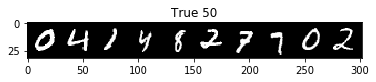

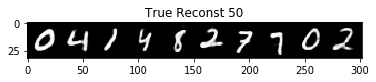

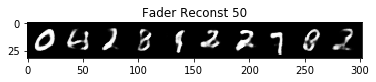


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 51 Fader Loss: -26.1436 | Adv Loss: 2.2667 | Rec Loss: 68.6458 
	| Adj Disc Loss: 284.3292 | Disc Acc: 0.1690


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 52 Fader Loss: -28.4337 | Adv Loss: 2.2710 | Rec Loss: 68.6005 
	| Adj Disc Loss: 291.0158 | Disc Acc: 0.1645


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 53 Fader Loss: -30.7515 | Adv Loss: 2.2788 | Rec Loss: 68.6867 
	| Adj Disc Loss: 298.3874 | Disc Acc: 0.1551


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 54 Fader Loss: -32.7691 | Adv Loss: 2.2771 | Rec Loss: 68.6638 
	| Adj Disc Loss: 304.5494 | Disc Acc: 0.1546


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 55 Fader Loss: -35.3842 | Adv Loss: 2.2834 | Rec Loss: 68.4089 
	| Adj Disc Loss: 311.5334 | Disc Acc: 0.1460


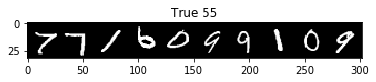

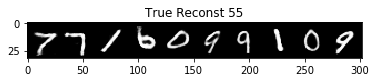

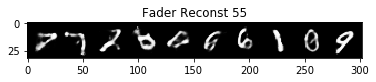


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 56 Fader Loss: -37.1707 | Adv Loss: 2.2746 | Rec Loss: 68.2882 
	| Adj Disc Loss: 316.2693 | Disc Acc: 0.1589


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 57 Fader Loss: -39.4600 | Adv Loss: 2.2796 | Rec Loss: 68.3045 
	| Adj Disc Loss: 323.5241 | Disc Acc: 0.1507


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 58 Fader Loss: -41.6704 | Adv Loss: 2.2842 | Rec Loss: 68.3858 
	| Adj Disc Loss: 330.2144 | Disc Acc: 0.1518


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 59 Fader Loss: -43.8117 | Adv Loss: 2.2833 | Rec Loss: 68.2796 
	| Adj Disc Loss: 336.3700 | Disc Acc: 0.1479


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 60 Fader Loss: -45.8965 | Adv Loss: 2.2799 | Rec Loss: 68.0998 
	| Adj Disc Loss: 341.9540 | Disc Acc: 0.1574


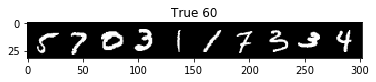

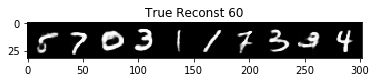

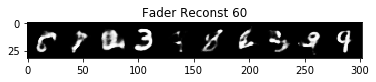


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 61 Fader Loss: -46.0652 | Adv Loss: 2.2831 | Rec Loss: 68.0894 
	| Adj Disc Loss: 342.3726 | Disc Acc: 0.1481


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 62 Fader Loss: -46.3592 | Adv Loss: 2.2886 | Rec Loss: 68.0722 
	| Adj Disc Loss: 343.2760 | Disc Acc: 0.1438


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 63 Fader Loss: -46.6634 | Adv Loss: 2.2902 | Rec Loss: 67.8485 
	| Adj Disc Loss: 343.4400 | Disc Acc: 0.1418


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 64 Fader Loss: -46.5114 | Adv Loss: 2.2861 | Rec Loss: 67.7936 
	| Adj Disc Loss: 343.0501 | Disc Acc: 0.1423


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 65 Fader Loss: -46.7132 | Adv Loss: 2.2876 | Rec Loss: 67.6690 
	| Adj Disc Loss: 343.3059 | Disc Acc: 0.1403


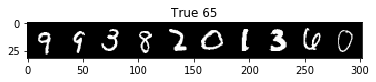

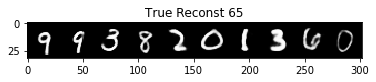

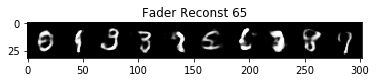


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 66 Fader Loss: -46.8479 | Adv Loss: 2.2858 | Rec Loss: 67.4422 
	| Adj Disc Loss: 342.9362 | Disc Acc: 0.1448


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 67 Fader Loss: -46.8697 | Adv Loss: 2.2836 | Rec Loss: 67.3079 
	| Adj Disc Loss: 342.7304 | Disc Acc: 0.1443


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 68 Fader Loss: -47.0207 | Adv Loss: 2.2851 | Rec Loss: 67.2362 
	| Adj Disc Loss: 342.9396 | Disc Acc: 0.1434


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 69 Fader Loss: -47.1487 | Adv Loss: 2.2843 | Rec Loss: 67.0642 
	| Adj Disc Loss: 342.6177 | Disc Acc: 0.1441


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 70 Fader Loss: -47.2382 | Adv Loss: 2.2863 | Rec Loss: 67.0780 
	| Adj Disc Loss: 343.0291 | Disc Acc: 0.1388


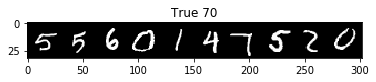

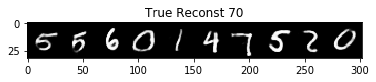

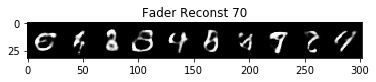


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 71 Fader Loss: -47.4434 | Adv Loss: 2.2880 | Rec Loss: 66.9577 
	| Adj Disc Loss: 343.2919 | Disc Acc: 0.1376


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 72 Fader Loss: -47.6130 | Adv Loss: 2.2881 | Rec Loss: 66.7913 
	| Adj Disc Loss: 343.1171 | Disc Acc: 0.1399


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 73 Fader Loss: -47.6513 | Adv Loss: 2.2868 | Rec Loss: 66.6889 
	| Adj Disc Loss: 343.2679 | Disc Acc: 0.1367


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 74 Fader Loss: -47.8280 | Adv Loss: 2.2876 | Rec Loss: 66.5506 
	| Adj Disc Loss: 343.1248 | Disc Acc: 0.1397


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 75 Fader Loss: -47.9012 | Adv Loss: 2.2871 | Rec Loss: 66.4516 
	| Adj Disc Loss: 343.1525 | Disc Acc: 0.1353


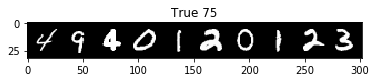

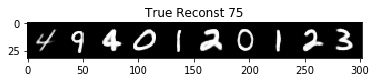

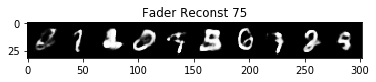


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 76 Fader Loss: -47.9951 | Adv Loss: 2.2867 | Rec Loss: 66.3378 
	| Adj Disc Loss: 342.9835 | Disc Acc: 0.1414


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 77 Fader Loss: -47.9174 | Adv Loss: 2.2857 | Rec Loss: 66.3682 
	| Adj Disc Loss: 342.9280 | Disc Acc: 0.1408


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 78 Fader Loss: -47.8339 | Adv Loss: 2.2837 | Rec Loss: 66.3514 
	| Adj Disc Loss: 342.5993 | Disc Acc: 0.1463


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 79 Fader Loss: -48.1955 | Adv Loss: 2.2880 | Rec Loss: 66.2032 
	| Adj Disc Loss: 343.2908 | Disc Acc: 0.1382


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 80 Fader Loss: -48.1543 | Adv Loss: 2.2845 | Rec Loss: 66.0690 
	| Adj Disc Loss: 342.6559 | Disc Acc: 0.1460


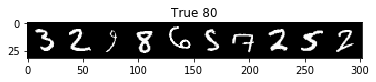

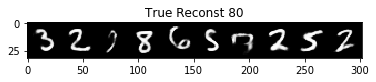

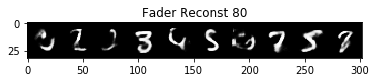


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 81 Fader Loss: -48.1732 | Adv Loss: 2.2863 | Rec Loss: 66.1440 
	| Adj Disc Loss: 343.0220 | Disc Acc: 0.1436


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 82 Fader Loss: -48.3951 | Adv Loss: 2.2889 | Rec Loss: 66.0504 
	| Adj Disc Loss: 343.2953 | Disc Acc: 0.1389


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 83 Fader Loss: -48.3932 | Adv Loss: 2.2879 | Rec Loss: 66.0028 
	| Adj Disc Loss: 343.2086 | Disc Acc: 0.1390


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 84 Fader Loss: -48.6208 | Adv Loss: 2.2882 | Rec Loss: 65.7905 
	| Adj Disc Loss: 343.1635 | Disc Acc: 0.1403


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 85 Fader Loss: -48.5988 | Adv Loss: 2.2885 | Rec Loss: 65.8256 
	| Adj Disc Loss: 343.3983 | Disc Acc: 0.1341


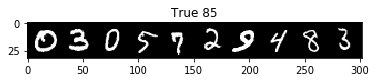

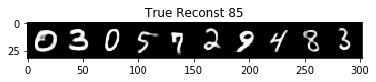

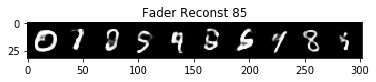


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 86 Fader Loss: -48.7712 | Adv Loss: 2.2903 | Rec Loss: 65.7437 
	| Adj Disc Loss: 343.5661 | Disc Acc: 0.1358


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 87 Fader Loss: -48.7504 | Adv Loss: 2.2884 | Rec Loss: 65.6706 
	| Adj Disc Loss: 343.4556 | Disc Acc: 0.1369


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 88 Fader Loss: -48.8424 | Adv Loss: 2.2879 | Rec Loss: 65.5526 
	| Adj Disc Loss: 343.2729 | Disc Acc: 0.1358


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 89 Fader Loss: -48.8589 | Adv Loss: 2.2905 | Rec Loss: 65.6651 
	| Adj Disc Loss: 343.5872 | Disc Acc: 0.1346


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 90 Fader Loss: -48.8982 | Adv Loss: 2.2901 | Rec Loss: 65.6073 
	| Adj Disc Loss: 343.5277 | Disc Acc: 0.1385


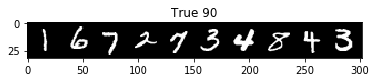

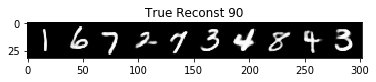

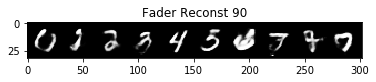


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 91 Fader Loss: -48.8817 | Adv Loss: 2.2901 | Rec Loss: 65.6210 
	| Adj Disc Loss: 343.5781 | Disc Acc: 0.1380


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 92 Fader Loss: -48.9975 | Adv Loss: 2.2918 | Rec Loss: 65.5913 
	| Adj Disc Loss: 343.8285 | Disc Acc: 0.1336


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 93 Fader Loss: -49.0372 | Adv Loss: 2.2901 | Rec Loss: 65.4698 
	| Adj Disc Loss: 343.5879 | Disc Acc: 0.1349


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 94 Fader Loss: -49.0508 | Adv Loss: 2.2896 | Rec Loss: 65.4279 
	| Adj Disc Loss: 343.4470 | Disc Acc: 0.1344


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 95 Fader Loss: -49.0535 | Adv Loss: 2.2891 | Rec Loss: 65.4007 
	| Adj Disc Loss: 343.5244 | Disc Acc: 0.1356


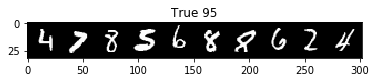

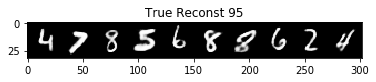

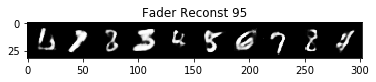


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 96 Fader Loss: -49.1449 | Adv Loss: 2.2886 | Rec Loss: 65.2861 
	| Adj Disc Loss: 343.3089 | Disc Acc: 0.1373


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 97 Fader Loss: -49.2186 | Adv Loss: 2.2889 | Rec Loss: 65.2251 
	| Adj Disc Loss: 343.3631 | Disc Acc: 0.1353


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 98 Fader Loss: -49.2386 | Adv Loss: 2.2881 | Rec Loss: 65.1647 
	| Adj Disc Loss: 343.2227 | Disc Acc: 0.1333


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 99 Fader Loss: -49.3365 | Adv Loss: 2.2878 | Rec Loss: 65.0548 
	| Adj Disc Loss: 343.1832 | Disc Acc: 0.1364


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 100 Fader Loss: -49.2920 | Adv Loss: 2.2867 | Rec Loss: 65.0409 
	| Adj Disc Loss: 343.1723 | Disc Acc: 0.1355


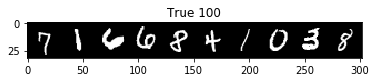

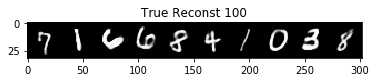

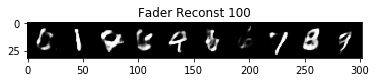


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 101 Fader Loss: -49.3538 | Adv Loss: 2.2874 | Rec Loss: 65.0169 
	| Adj Disc Loss: 343.1888 | Disc Acc: 0.1352


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 102 Fader Loss: -49.4463 | Adv Loss: 2.2874 | Rec Loss: 64.9230 
	| Adj Disc Loss: 343.0051 | Disc Acc: 0.1373


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 103 Fader Loss: -49.4011 | Adv Loss: 2.2852 | Rec Loss: 64.8574 
	| Adj Disc Loss: 342.8935 | Disc Acc: 0.1362


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 104 Fader Loss: -49.4834 | Adv Loss: 2.2861 | Rec Loss: 64.8232 
	| Adj Disc Loss: 342.9542 | Disc Acc: 0.1388


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 105 Fader Loss: -49.4685 | Adv Loss: 2.2855 | Rec Loss: 64.8044 
	| Adj Disc Loss: 342.8422 | Disc Acc: 0.1360


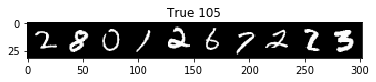

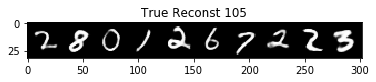

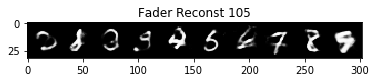


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 106 Fader Loss: -49.5255 | Adv Loss: 2.2858 | Rec Loss: 64.7652 
	| Adj Disc Loss: 342.8308 | Disc Acc: 0.1389


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 107 Fader Loss: -49.5172 | Adv Loss: 2.2852 | Rec Loss: 64.7447 
	| Adj Disc Loss: 342.8482 | Disc Acc: 0.1371


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 108 Fader Loss: -49.5924 | Adv Loss: 2.2862 | Rec Loss: 64.7174 
	| Adj Disc Loss: 342.9246 | Disc Acc: 0.1399


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 109 Fader Loss: -49.6764 | Adv Loss: 2.2866 | Rec Loss: 64.6546 
	| Adj Disc Loss: 343.0878 | Disc Acc: 0.1337


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 110 Fader Loss: -49.7437 | Adv Loss: 2.2876 | Rec Loss: 64.6387 
	| Adj Disc Loss: 343.1956 | Disc Acc: 0.1365


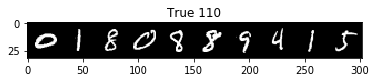

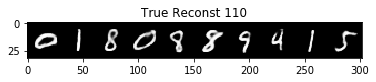

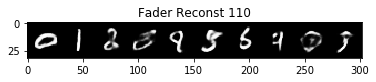


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 111 Fader Loss: -49.8591 | Adv Loss: 2.2883 | Rec Loss: 64.5567 
	| Adj Disc Loss: 343.2308 | Disc Acc: 0.1331


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 112 Fader Loss: -49.8501 | Adv Loss: 2.2868 | Rec Loss: 64.4917 
	| Adj Disc Loss: 343.1693 | Disc Acc: 0.1325


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 113 Fader Loss: -49.9243 | Adv Loss: 2.2871 | Rec Loss: 64.4284 
	| Adj Disc Loss: 343.0115 | Disc Acc: 0.1361


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 114 Fader Loss: -49.9444 | Adv Loss: 2.2872 | Rec Loss: 64.4171 
	| Adj Disc Loss: 343.1485 | Disc Acc: 0.1368


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 115 Fader Loss: -49.9638 | Adv Loss: 2.2872 | Rec Loss: 64.3948 
	| Adj Disc Loss: 343.0895 | Disc Acc: 0.1367


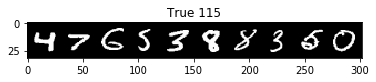

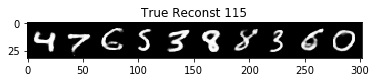

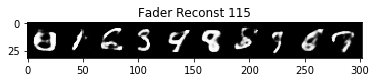


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 116 Fader Loss: -49.9748 | Adv Loss: 2.2858 | Rec Loss: 64.3162 
	| Adj Disc Loss: 342.9470 | Disc Acc: 0.1344


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 117 Fader Loss: -49.9819 | Adv Loss: 2.2870 | Rec Loss: 64.3657 
	| Adj Disc Loss: 343.0574 | Disc Acc: 0.1336


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 118 Fader Loss: -50.0315 | Adv Loss: 2.2864 | Rec Loss: 64.2878 
	| Adj Disc Loss: 343.0145 | Disc Acc: 0.1349


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 119 Fader Loss: -50.0804 | Adv Loss: 2.2854 | Rec Loss: 64.1890 
	| Adj Disc Loss: 342.8693 | Disc Acc: 0.1377


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 120 Fader Loss: -50.0903 | Adv Loss: 2.2859 | Rec Loss: 64.2043 
	| Adj Disc Loss: 343.0021 | Disc Acc: 0.1352


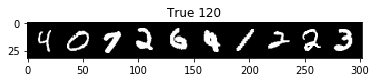

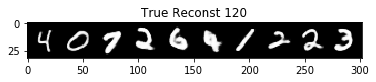

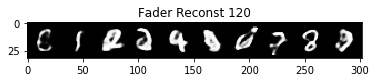


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 121 Fader Loss: -50.1271 | Adv Loss: 2.2873 | Rec Loss: 64.2356 
	| Adj Disc Loss: 343.1311 | Disc Acc: 0.1335


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 122 Fader Loss: -50.1802 | Adv Loss: 2.2880 | Rec Loss: 64.2195 
	| Adj Disc Loss: 343.2713 | Disc Acc: 0.1340


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 123 Fader Loss: -50.2611 | Adv Loss: 2.2891 | Rec Loss: 64.1946 
	| Adj Disc Loss: 343.3649 | Disc Acc: 0.1331


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 124 Fader Loss: -50.3377 | Adv Loss: 2.2893 | Rec Loss: 64.1273 
	| Adj Disc Loss: 343.3648 | Disc Acc: 0.1301


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 125 Fader Loss: -50.3304 | Adv Loss: 2.2887 | Rec Loss: 64.1023 
	| Adj Disc Loss: 343.4139 | Disc Acc: 0.1302


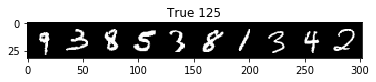

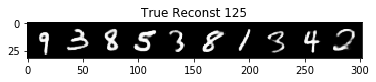

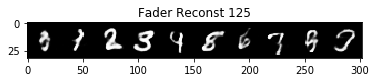


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 126 Fader Loss: -50.3171 | Adv Loss: 2.2882 | Rec Loss: 64.0930 
	| Adj Disc Loss: 343.3268 | Disc Acc: 0.1304


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 127 Fader Loss: -50.4195 | Adv Loss: 2.2879 | Rec Loss: 63.9733 
	| Adj Disc Loss: 343.1709 | Disc Acc: 0.1313


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 128 Fader Loss: -50.4330 | Adv Loss: 2.2873 | Rec Loss: 63.9299 
	| Adj Disc Loss: 343.1201 | Disc Acc: 0.1330


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 129 Fader Loss: -50.5383 | Adv Loss: 2.2889 | Rec Loss: 63.9054 
	| Adj Disc Loss: 343.4012 | Disc Acc: 0.1298


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 130 Fader Loss: -50.5871 | Adv Loss: 2.2888 | Rec Loss: 63.8552 
	| Adj Disc Loss: 343.3822 | Disc Acc: 0.1306


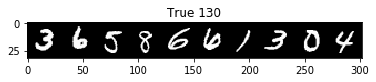

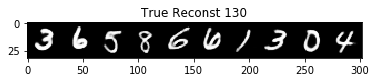

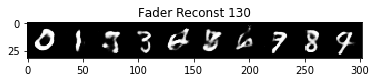


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 131 Fader Loss: -50.5787 | Adv Loss: 2.2889 | Rec Loss: 63.8687 
	| Adj Disc Loss: 343.4527 | Disc Acc: 0.1304


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 132 Fader Loss: -50.6522 | Adv Loss: 2.2904 | Rec Loss: 63.8691 
	| Adj Disc Loss: 343.5503 | Disc Acc: 0.1295


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 133 Fader Loss: -50.6720 | Adv Loss: 2.2901 | Rec Loss: 63.8355 
	| Adj Disc Loss: 343.6321 | Disc Acc: 0.1279


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 134 Fader Loss: -50.7916 | Adv Loss: 2.2910 | Rec Loss: 63.7605 
	| Adj Disc Loss: 343.5995 | Disc Acc: 0.1295


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 135 Fader Loss: -50.7848 | Adv Loss: 2.2902 | Rec Loss: 63.7269 
	| Adj Disc Loss: 343.5379 | Disc Acc: 0.1278


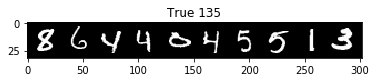

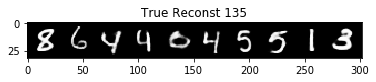

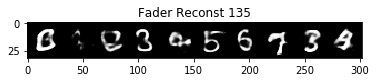


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 136 Fader Loss: -50.7690 | Adv Loss: 2.2899 | Rec Loss: 63.7285 
	| Adj Disc Loss: 343.5409 | Disc Acc: 0.1290


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 137 Fader Loss: -50.7341 | Adv Loss: 2.2895 | Rec Loss: 63.7410 
	| Adj Disc Loss: 343.6482 | Disc Acc: 0.1292


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 138 Fader Loss: -50.8928 | Adv Loss: 2.2905 | Rec Loss: 63.6324 
	| Adj Disc Loss: 343.7151 | Disc Acc: 0.1261


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 139 Fader Loss: -50.9254 | Adv Loss: 2.2903 | Rec Loss: 63.5906 
	| Adj Disc Loss: 343.6837 | Disc Acc: 0.1263


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 140 Fader Loss: -50.9530 | Adv Loss: 2.2917 | Rec Loss: 63.6331 
	| Adj Disc Loss: 343.8842 | Disc Acc: 0.1271


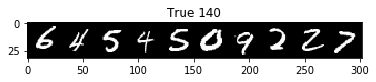

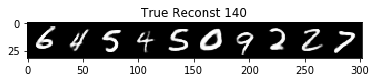

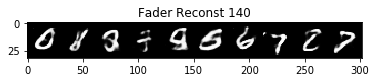


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 141 Fader Loss: -51.0089 | Adv Loss: 2.2906 | Rec Loss: 63.5235 
	| Adj Disc Loss: 343.6778 | Disc Acc: 0.1288


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 142 Fader Loss: -51.0287 | Adv Loss: 2.2906 | Rec Loss: 63.5036 
	| Adj Disc Loss: 343.7263 | Disc Acc: 0.1290


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 143 Fader Loss: -51.0719 | Adv Loss: 2.2913 | Rec Loss: 63.4947 
	| Adj Disc Loss: 343.8404 | Disc Acc: 0.1249


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 144 Fader Loss: -51.1307 | Adv Loss: 2.2896 | Rec Loss: 63.3501 
	| Adj Disc Loss: 343.5352 | Disc Acc: 0.1294


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 145 Fader Loss: -51.1471 | Adv Loss: 2.2923 | Rec Loss: 63.4684 
	| Adj Disc Loss: 343.9422 | Disc Acc: 0.1276


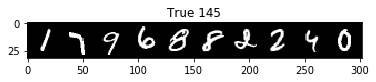

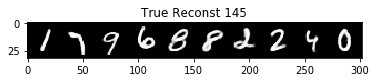

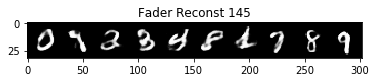


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 146 Fader Loss: -51.2278 | Adv Loss: 2.2921 | Rec Loss: 63.3772 
	| Adj Disc Loss: 343.9367 | Disc Acc: 0.1262


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 147 Fader Loss: -51.2322 | Adv Loss: 2.2920 | Rec Loss: 63.3661 
	| Adj Disc Loss: 343.8985 | Disc Acc: 0.1297


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 148 Fader Loss: -51.3151 | Adv Loss: 2.2935 | Rec Loss: 63.3619 
	| Adj Disc Loss: 344.0878 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 149 Fader Loss: -51.3569 | Adv Loss: 2.2932 | Rec Loss: 63.3014 
	| Adj Disc Loss: 344.0432 | Disc Acc: 0.1290


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 150 Fader Loss: -51.4037 | Adv Loss: 2.2933 | Rec Loss: 63.2620 
	| Adj Disc Loss: 344.0285 | Disc Acc: 0.1286


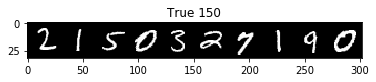

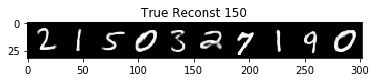

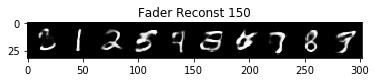


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 151 Fader Loss: -51.4514 | Adv Loss: 2.2933 | Rec Loss: 63.2126 
	| Adj Disc Loss: 343.9729 | Disc Acc: 0.1271


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 152 Fader Loss: -51.4410 | Adv Loss: 2.2929 | Rec Loss: 63.2040 
	| Adj Disc Loss: 343.8946 | Disc Acc: 0.1293


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 153 Fader Loss: -51.4584 | Adv Loss: 2.2931 | Rec Loss: 63.1967 
	| Adj Disc Loss: 343.9149 | Disc Acc: 0.1290


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 154 Fader Loss: -51.3404 | Adv Loss: 2.2912 | Rec Loss: 63.2173 
	| Adj Disc Loss: 343.8127 | Disc Acc: 0.1312


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 155 Fader Loss: -51.4060 | Adv Loss: 2.2914 | Rec Loss: 63.1659 
	| Adj Disc Loss: 343.6359 | Disc Acc: 0.1308


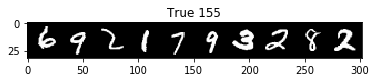

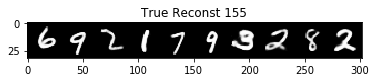

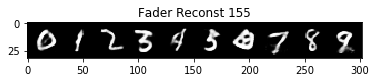


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 156 Fader Loss: -51.3511 | Adv Loss: 2.2922 | Rec Loss: 63.2575 
	| Adj Disc Loss: 343.8785 | Disc Acc: 0.1291


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 157 Fader Loss: -51.4017 | Adv Loss: 2.2910 | Rec Loss: 63.1500 
	| Adj Disc Loss: 343.6923 | Disc Acc: 0.1328


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 158 Fader Loss: -51.4242 | Adv Loss: 2.2906 | Rec Loss: 63.1043 
	| Adj Disc Loss: 343.6865 | Disc Acc: 0.1313


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 159 Fader Loss: -51.4551 | Adv Loss: 2.2912 | Rec Loss: 63.1060 
	| Adj Disc Loss: 343.8114 | Disc Acc: 0.1289


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 160 Fader Loss: -51.5071 | Adv Loss: 2.2914 | Rec Loss: 63.0628 
	| Adj Disc Loss: 343.6873 | Disc Acc: 0.1273


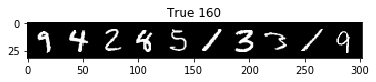

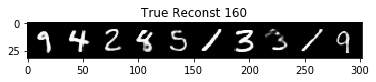

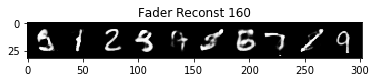


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 161 Fader Loss: -51.5081 | Adv Loss: 2.2912 | Rec Loss: 63.0497 
	| Adj Disc Loss: 343.8576 | Disc Acc: 0.1289


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 162 Fader Loss: -51.5650 | Adv Loss: 2.2908 | Rec Loss: 62.9734 
	| Adj Disc Loss: 343.7978 | Disc Acc: 0.1281


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 163 Fader Loss: -51.6394 | Adv Loss: 2.2914 | Rec Loss: 62.9297 
	| Adj Disc Loss: 343.7530 | Disc Acc: 0.1312


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 164 Fader Loss: -51.6254 | Adv Loss: 2.2907 | Rec Loss: 62.9105 
	| Adj Disc Loss: 343.7603 | Disc Acc: 0.1313


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 165 Fader Loss: -51.6952 | Adv Loss: 2.2924 | Rec Loss: 62.9226 
	| Adj Disc Loss: 343.8576 | Disc Acc: 0.1307


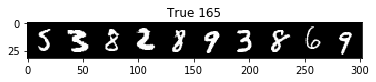

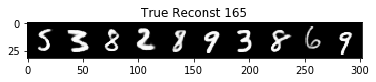

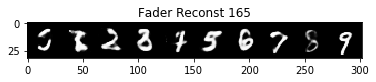


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 166 Fader Loss: -51.7010 | Adv Loss: 2.2930 | Rec Loss: 62.9490 
	| Adj Disc Loss: 344.0871 | Disc Acc: 0.1283


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 167 Fader Loss: -51.7964 | Adv Loss: 2.2928 | Rec Loss: 62.8452 
	| Adj Disc Loss: 343.9162 | Disc Acc: 0.1291


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 168 Fader Loss: -51.8048 | Adv Loss: 2.2924 | Rec Loss: 62.8135 
	| Adj Disc Loss: 343.8492 | Disc Acc: 0.1312


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 169 Fader Loss: -51.7919 | Adv Loss: 2.2922 | Rec Loss: 62.8205 
	| Adj Disc Loss: 343.9313 | Disc Acc: 0.1283


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 170 Fader Loss: -51.7993 | Adv Loss: 2.2921 | Rec Loss: 62.8040 
	| Adj Disc Loss: 343.8664 | Disc Acc: 0.1287


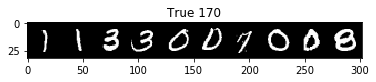

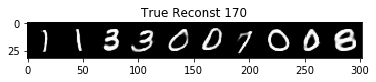

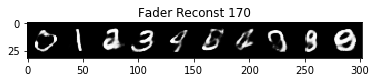


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 171 Fader Loss: -51.8187 | Adv Loss: 2.2932 | Rec Loss: 62.8411 
	| Adj Disc Loss: 343.9936 | Disc Acc: 0.1275


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 172 Fader Loss: -51.8157 | Adv Loss: 2.2926 | Rec Loss: 62.8123 
	| Adj Disc Loss: 343.9677 | Disc Acc: 0.1252


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 173 Fader Loss: -51.9197 | Adv Loss: 2.2932 | Rec Loss: 62.7418 
	| Adj Disc Loss: 343.9103 | Disc Acc: 0.1283


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 174 Fader Loss: -51.8838 | Adv Loss: 2.2927 | Rec Loss: 62.7489 
	| Adj Disc Loss: 343.9473 | Disc Acc: 0.1284


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 175 Fader Loss: -51.9489 | Adv Loss: 2.2928 | Rec Loss: 62.6913 
	| Adj Disc Loss: 343.9488 | Disc Acc: 0.1231


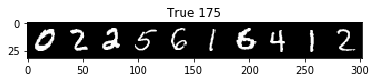

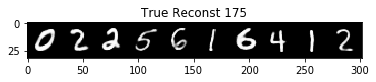

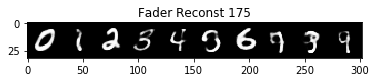


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 176 Fader Loss: -51.8852 | Adv Loss: 2.2898 | Rec Loss: 62.6067 
	| Adj Disc Loss: 343.5506 | Disc Acc: 0.1311


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 177 Fader Loss: -51.8499 | Adv Loss: 2.2904 | Rec Loss: 62.6701 
	| Adj Disc Loss: 343.6609 | Disc Acc: 0.1287


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 178 Fader Loss: -51.9805 | Adv Loss: 2.2926 | Rec Loss: 62.6490 
	| Adj Disc Loss: 343.9743 | Disc Acc: 0.1257


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 179 Fader Loss: -51.9593 | Adv Loss: 2.2925 | Rec Loss: 62.6680 
	| Adj Disc Loss: 343.9447 | Disc Acc: 0.1261


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 180 Fader Loss: -51.9846 | Adv Loss: 2.2927 | Rec Loss: 62.6514 
	| Adj Disc Loss: 344.0341 | Disc Acc: 0.1244


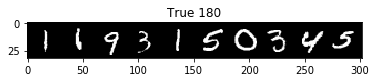

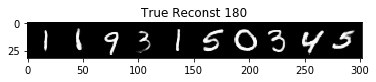

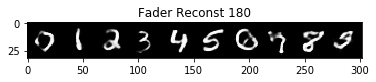


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 181 Fader Loss: -52.0467 | Adv Loss: 2.2952 | Rec Loss: 62.7143 
	| Adj Disc Loss: 344.4455 | Disc Acc: 0.1227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 182 Fader Loss: -52.1119 | Adv Loss: 2.2932 | Rec Loss: 62.5470 
	| Adj Disc Loss: 344.0310 | Disc Acc: 0.1242


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 183 Fader Loss: -52.1328 | Adv Loss: 2.2932 | Rec Loss: 62.5290 
	| Adj Disc Loss: 343.9951 | Disc Acc: 0.1262


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 184 Fader Loss: -52.1502 | Adv Loss: 2.2934 | Rec Loss: 62.5213 
	| Adj Disc Loss: 344.1538 | Disc Acc: 0.1244


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 185 Fader Loss: -52.1741 | Adv Loss: 2.2927 | Rec Loss: 62.4604 
	| Adj Disc Loss: 343.9499 | Disc Acc: 0.1250


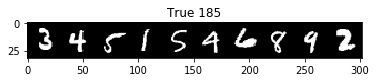

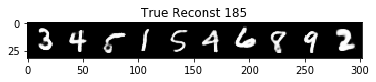

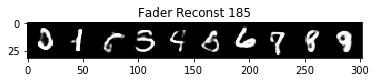


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 186 Fader Loss: -52.1897 | Adv Loss: 2.2935 | Rec Loss: 62.4843 
	| Adj Disc Loss: 344.0562 | Disc Acc: 0.1276


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 187 Fader Loss: -52.2617 | Adv Loss: 2.2944 | Rec Loss: 62.4570 
	| Adj Disc Loss: 344.1994 | Disc Acc: 0.1269


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 188 Fader Loss: -52.2978 | Adv Loss: 2.2949 | Rec Loss: 62.4471 
	| Adj Disc Loss: 344.2698 | Disc Acc: 0.1255


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 189 Fader Loss: -52.2504 | Adv Loss: 2.2925 | Rec Loss: 62.3725 
	| Adj Disc Loss: 344.0093 | Disc Acc: 0.1255


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 190 Fader Loss: -52.3036 | Adv Loss: 2.2936 | Rec Loss: 62.3780 
	| Adj Disc Loss: 344.0518 | Disc Acc: 0.1268


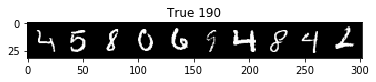

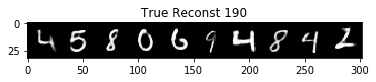

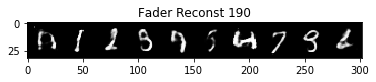


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 191 Fader Loss: -52.3343 | Adv Loss: 2.2934 | Rec Loss: 62.3374 
	| Adj Disc Loss: 344.0534 | Disc Acc: 0.1239


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 192 Fader Loss: -52.3466 | Adv Loss: 2.2929 | Rec Loss: 62.3007 
	| Adj Disc Loss: 344.0663 | Disc Acc: 0.1238


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 193 Fader Loss: -52.3642 | Adv Loss: 2.2938 | Rec Loss: 62.3280 
	| Adj Disc Loss: 344.0554 | Disc Acc: 0.1252


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 194 Fader Loss: -52.3535 | Adv Loss: 2.2930 | Rec Loss: 62.2954 
	| Adj Disc Loss: 344.1118 | Disc Acc: 0.1238


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 195 Fader Loss: -52.3680 | Adv Loss: 2.2933 | Rec Loss: 62.2969 
	| Adj Disc Loss: 343.9637 | Disc Acc: 0.1269


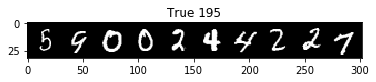

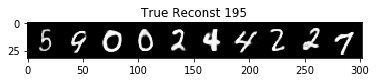

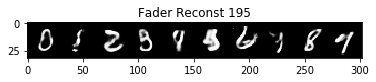


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 196 Fader Loss: -52.3983 | Adv Loss: 2.2932 | Rec Loss: 62.2621 
	| Adj Disc Loss: 343.9756 | Disc Acc: 0.1260


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 197 Fader Loss: -52.3654 | Adv Loss: 2.2922 | Rec Loss: 62.2447 
	| Adj Disc Loss: 343.9316 | Disc Acc: 0.1290


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 198 Fader Loss: -52.3917 | Adv Loss: 2.2932 | Rec Loss: 62.2682 
	| Adj Disc Loss: 343.9966 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 199 Fader Loss: -52.3700 | Adv Loss: 2.2937 | Rec Loss: 62.3150 
	| Adj Disc Loss: 344.0983 | Disc Acc: 0.1280


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 200 Fader Loss: -52.4762 | Adv Loss: 2.2947 | Rec Loss: 62.2576 
	| Adj Disc Loss: 344.1867 | Disc Acc: 0.1241


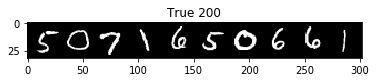

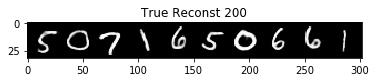

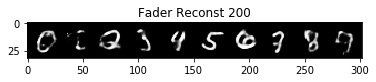


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 201 Fader Loss: -52.4757 | Adv Loss: 2.2938 | Rec Loss: 62.2135 
	| Adj Disc Loss: 344.1214 | Disc Acc: 0.1253


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 202 Fader Loss: -52.5208 | Adv Loss: 2.2945 | Rec Loss: 62.2029 
	| Adj Disc Loss: 344.2327 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 203 Fader Loss: -52.5857 | Adv Loss: 2.2944 | Rec Loss: 62.1355 
	| Adj Disc Loss: 344.1835 | Disc Acc: 0.1255


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 204 Fader Loss: -52.5614 | Adv Loss: 2.2942 | Rec Loss: 62.1495 
	| Adj Disc Loss: 344.1731 | Disc Acc: 0.1220


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 205 Fader Loss: -52.5556 | Adv Loss: 2.2939 | Rec Loss: 62.1375 
	| Adj Disc Loss: 344.1703 | Disc Acc: 0.1250


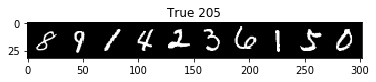

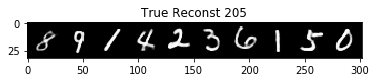

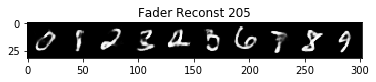


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 206 Fader Loss: -52.5511 | Adv Loss: 2.2935 | Rec Loss: 62.1230 
	| Adj Disc Loss: 344.1109 | Disc Acc: 0.1266


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 207 Fader Loss: -52.6188 | Adv Loss: 2.2946 | Rec Loss: 62.1104 
	| Adj Disc Loss: 344.2421 | Disc Acc: 0.1242


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 208 Fader Loss: -52.6027 | Adv Loss: 2.2937 | Rec Loss: 62.0813 
	| Adj Disc Loss: 344.0347 | Disc Acc: 0.1252


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 209 Fader Loss: -52.6413 | Adv Loss: 2.2941 | Rec Loss: 62.0658 
	| Adj Disc Loss: 344.1703 | Disc Acc: 0.1228


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 210 Fader Loss: -52.6626 | Adv Loss: 2.2942 | Rec Loss: 62.0469 
	| Adj Disc Loss: 344.0858 | Disc Acc: 0.1248


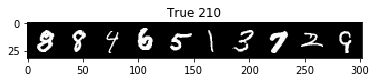

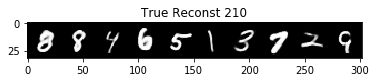

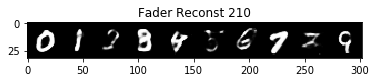


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 211 Fader Loss: -52.6634 | Adv Loss: 2.2939 | Rec Loss: 62.0310 
	| Adj Disc Loss: 344.0597 | Disc Acc: 0.1244


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 212 Fader Loss: -52.6427 | Adv Loss: 2.2931 | Rec Loss: 62.0140 
	| Adj Disc Loss: 344.0794 | Disc Acc: 0.1238


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 213 Fader Loss: -52.6718 | Adv Loss: 2.2931 | Rec Loss: 61.9808 
	| Adj Disc Loss: 344.0920 | Disc Acc: 0.1238


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 214 Fader Loss: -52.7549 | Adv Loss: 2.2942 | Rec Loss: 61.9541 
	| Adj Disc Loss: 344.0829 | Disc Acc: 0.1241


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 215 Fader Loss: -52.7214 | Adv Loss: 2.2933 | Rec Loss: 61.9448 
	| Adj Disc Loss: 344.1002 | Disc Acc: 0.1251


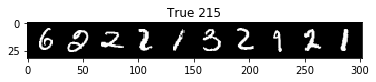

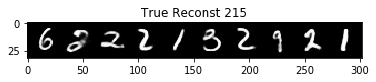

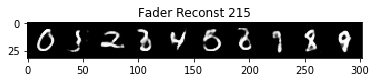


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 216 Fader Loss: -52.7133 | Adv Loss: 2.2929 | Rec Loss: 61.9322 
	| Adj Disc Loss: 344.2003 | Disc Acc: 0.1252


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 217 Fader Loss: -52.7765 | Adv Loss: 2.2936 | Rec Loss: 61.9059 
	| Adj Disc Loss: 344.2482 | Disc Acc: 0.1214


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 218 Fader Loss: -52.7980 | Adv Loss: 2.2935 | Rec Loss: 61.8788 
	| Adj Disc Loss: 344.2198 | Disc Acc: 0.1216


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 219 Fader Loss: -52.8513 | Adv Loss: 2.2954 | Rec Loss: 61.9207 
	| Adj Disc Loss: 344.3004 | Disc Acc: 0.1243


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 220 Fader Loss: -52.8831 | Adv Loss: 2.2956 | Rec Loss: 61.8948 
	| Adj Disc Loss: 344.3637 | Disc Acc: 0.1226


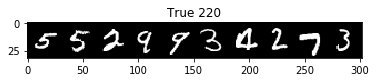

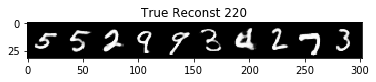

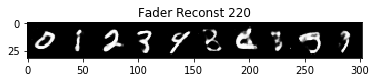


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 221 Fader Loss: -52.8377 | Adv Loss: 2.2944 | Rec Loss: 61.8846 
	| Adj Disc Loss: 344.3416 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 222 Fader Loss: -52.8976 | Adv Loss: 2.2946 | Rec Loss: 61.8345 
	| Adj Disc Loss: 344.2374 | Disc Acc: 0.1233


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 223 Fader Loss: -52.8775 | Adv Loss: 2.2937 | Rec Loss: 61.8082 
	| Adj Disc Loss: 344.1370 | Disc Acc: 0.1227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 224 Fader Loss: -52.8258 | Adv Loss: 2.2928 | Rec Loss: 61.8156 
	| Adj Disc Loss: 344.0180 | Disc Acc: 0.1256


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 225 Fader Loss: -52.8299 | Adv Loss: 2.2934 | Rec Loss: 61.8382 
	| Adj Disc Loss: 344.1133 | Disc Acc: 0.1261


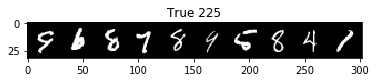

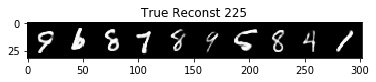

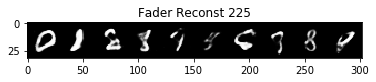


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 226 Fader Loss: -52.8744 | Adv Loss: 2.2944 | Rec Loss: 61.8456 
	| Adj Disc Loss: 344.2348 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 227 Fader Loss: -52.9104 | Adv Loss: 2.2938 | Rec Loss: 61.7810 
	| Adj Disc Loss: 344.1028 | Disc Acc: 0.1245


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 228 Fader Loss: -52.9244 | Adv Loss: 2.2950 | Rec Loss: 61.8244 
	| Adj Disc Loss: 344.2418 | Disc Acc: 0.1224


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 229 Fader Loss: -52.9516 | Adv Loss: 2.2940 | Rec Loss: 61.7461 
	| Adj Disc Loss: 344.1251 | Disc Acc: 0.1236


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 230 Fader Loss: -52.8827 | Adv Loss: 2.2924 | Rec Loss: 61.7385 
	| Adj Disc Loss: 344.0184 | Disc Acc: 0.1267


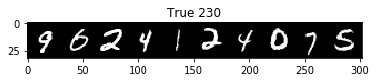

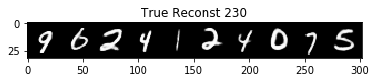

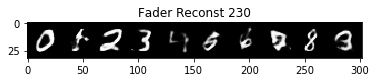


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 231 Fader Loss: -52.9613 | Adv Loss: 2.2945 | Rec Loss: 61.7631 
	| Adj Disc Loss: 344.1588 | Disc Acc: 0.1255


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 232 Fader Loss: -52.9348 | Adv Loss: 2.2928 | Rec Loss: 61.7072 
	| Adj Disc Loss: 344.0022 | Disc Acc: 0.1310


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 233 Fader Loss: -52.9600 | Adv Loss: 2.2932 | Rec Loss: 61.7002 
	| Adj Disc Loss: 344.1304 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 234 Fader Loss: -53.0149 | Adv Loss: 2.2949 | Rec Loss: 61.7320 
	| Adj Disc Loss: 344.3194 | Disc Acc: 0.1187


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 235 Fader Loss: -53.0660 | Adv Loss: 2.2946 | Rec Loss: 61.6658 
	| Adj Disc Loss: 344.2254 | Disc Acc: 0.1228


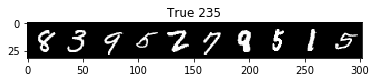

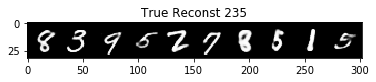

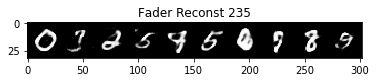


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 236 Fader Loss: -52.9861 | Adv Loss: 2.2920 | Rec Loss: 61.6132 
	| Adj Disc Loss: 343.9588 | Disc Acc: 0.1317


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 237 Fader Loss: -53.0473 | Adv Loss: 2.2944 | Rec Loss: 61.6739 
	| Adj Disc Loss: 344.2078 | Disc Acc: 0.1247


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 238 Fader Loss: -53.0875 | Adv Loss: 2.2947 | Rec Loss: 61.6475 
	| Adj Disc Loss: 344.2985 | Disc Acc: 0.1194


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 239 Fader Loss: -53.0447 | Adv Loss: 2.2924 | Rec Loss: 61.5737 
	| Adj Disc Loss: 343.8865 | Disc Acc: 0.1292


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 240 Fader Loss: -53.1515 | Adv Loss: 2.2952 | Rec Loss: 61.6085 
	| Adj Disc Loss: 344.2696 | Disc Acc: 0.1196


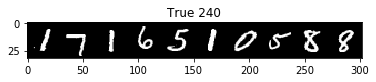

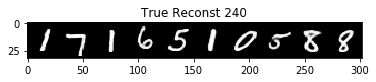

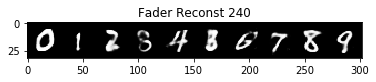


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 241 Fader Loss: -53.1524 | Adv Loss: 2.2945 | Rec Loss: 61.5747 
	| Adj Disc Loss: 344.2268 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 242 Fader Loss: -53.1363 | Adv Loss: 2.2942 | Rec Loss: 61.5736 
	| Adj Disc Loss: 344.2158 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 243 Fader Loss: -53.1656 | Adv Loss: 2.2941 | Rec Loss: 61.5408 
	| Adj Disc Loss: 344.1217 | Disc Acc: 0.1239


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 244 Fader Loss: -53.1522 | Adv Loss: 2.2942 | Rec Loss: 61.5594 
	| Adj Disc Loss: 344.2367 | Disc Acc: 0.1247


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 245 Fader Loss: -53.1902 | Adv Loss: 2.2947 | Rec Loss: 61.5440 
	| Adj Disc Loss: 344.2583 | Disc Acc: 0.1223


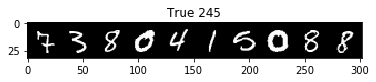

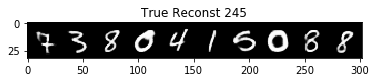

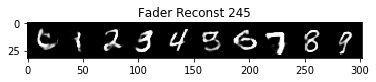


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 246 Fader Loss: -53.2249 | Adv Loss: 2.2949 | Rec Loss: 61.5188 
	| Adj Disc Loss: 344.2970 | Disc Acc: 0.1214


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 247 Fader Loss: -53.2502 | Adv Loss: 2.2954 | Rec Loss: 61.5182 
	| Adj Disc Loss: 344.3208 | Disc Acc: 0.1195


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 248 Fader Loss: -53.2623 | Adv Loss: 2.2951 | Rec Loss: 61.4919 
	| Adj Disc Loss: 344.2766 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 249 Fader Loss: -53.2649 | Adv Loss: 2.2946 | Rec Loss: 61.4657 
	| Adj Disc Loss: 344.2930 | Disc Acc: 0.1216


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 250 Fader Loss: -53.3095 | Adv Loss: 2.2947 | Rec Loss: 61.4271 
	| Adj Disc Loss: 344.1669 | Disc Acc: 0.1210


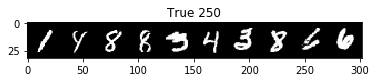

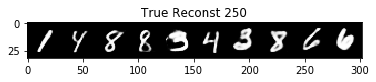

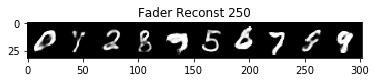


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 251 Fader Loss: -53.2370 | Adv Loss: 2.2943 | Rec Loss: 61.4786 
	| Adj Disc Loss: 344.2316 | Disc Acc: 0.1208


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 252 Fader Loss: -53.2552 | Adv Loss: 2.2943 | Rec Loss: 61.4573 
	| Adj Disc Loss: 344.2104 | Disc Acc: 0.1188


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 253 Fader Loss: -53.2470 | Adv Loss: 2.2940 | Rec Loss: 61.4546 
	| Adj Disc Loss: 344.1853 | Disc Acc: 0.1233


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 254 Fader Loss: -53.3030 | Adv Loss: 2.2950 | Rec Loss: 61.4490 
	| Adj Disc Loss: 344.2941 | Disc Acc: 0.1204


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 255 Fader Loss: -53.2894 | Adv Loss: 2.2948 | Rec Loss: 61.4485 
	| Adj Disc Loss: 344.2736 | Disc Acc: 0.1231


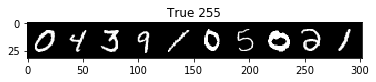

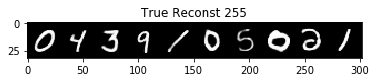

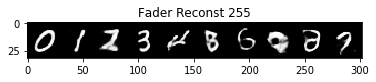


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 256 Fader Loss: -53.3476 | Adv Loss: 2.2955 | Rec Loss: 61.4257 
	| Adj Disc Loss: 344.3431 | Disc Acc: 0.1232


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 257 Fader Loss: -53.3313 | Adv Loss: 2.2946 | Rec Loss: 61.3983 
	| Adj Disc Loss: 344.3062 | Disc Acc: 0.1247


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 258 Fader Loss: -53.3635 | Adv Loss: 2.2951 | Rec Loss: 61.3934 
	| Adj Disc Loss: 344.3235 | Disc Acc: 0.1231


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 259 Fader Loss: -53.3629 | Adv Loss: 2.2953 | Rec Loss: 61.4013 
	| Adj Disc Loss: 344.3475 | Disc Acc: 0.1222


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 260 Fader Loss: -53.3991 | Adv Loss: 2.2953 | Rec Loss: 61.3653 
	| Adj Disc Loss: 344.4032 | Disc Acc: 0.1184


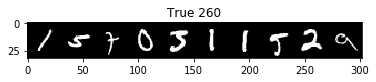

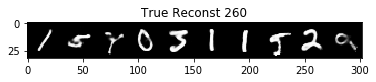

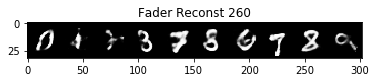


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 261 Fader Loss: -53.4177 | Adv Loss: 2.2955 | Rec Loss: 61.3554 
	| Adj Disc Loss: 344.3278 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 262 Fader Loss: -53.4314 | Adv Loss: 2.2955 | Rec Loss: 61.3415 
	| Adj Disc Loss: 344.4051 | Disc Acc: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 263 Fader Loss: -53.4451 | Adv Loss: 2.2957 | Rec Loss: 61.3417 
	| Adj Disc Loss: 344.3350 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 264 Fader Loss: -53.4075 | Adv Loss: 2.2950 | Rec Loss: 61.3419 
	| Adj Disc Loss: 344.3289 | Disc Acc: 0.1222


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 265 Fader Loss: -53.4331 | Adv Loss: 2.2952 | Rec Loss: 61.3255 
	| Adj Disc Loss: 344.3535 | Disc Acc: 0.1213


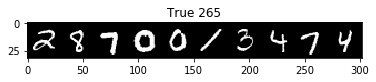

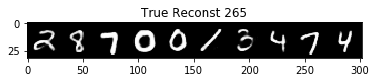

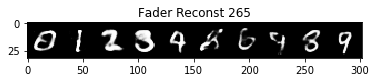


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 266 Fader Loss: -53.4669 | Adv Loss: 2.2953 | Rec Loss: 61.2998 
	| Adj Disc Loss: 344.4422 | Disc Acc: 0.1232


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 267 Fader Loss: -53.4724 | Adv Loss: 2.2952 | Rec Loss: 61.2859 
	| Adj Disc Loss: 344.3388 | Disc Acc: 0.1158


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 268 Fader Loss: -53.4553 | Adv Loss: 2.2949 | Rec Loss: 61.2890 
	| Adj Disc Loss: 344.3128 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 269 Fader Loss: -53.4511 | Adv Loss: 2.2942 | Rec Loss: 61.2600 
	| Adj Disc Loss: 344.1979 | Disc Acc: 0.1201


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 270 Fader Loss: -53.4375 | Adv Loss: 2.2939 | Rec Loss: 61.2560 
	| Adj Disc Loss: 344.1971 | Disc Acc: 0.1172


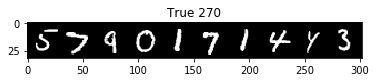

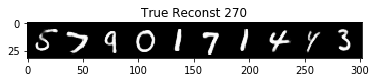

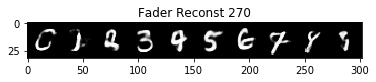


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 271 Fader Loss: -53.4693 | Adv Loss: 2.2947 | Rec Loss: 61.2640 
	| Adj Disc Loss: 344.1748 | Disc Acc: 0.1182


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 272 Fader Loss: -53.4326 | Adv Loss: 2.2937 | Rec Loss: 61.2520 
	| Adj Disc Loss: 344.1504 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 273 Fader Loss: -53.4780 | Adv Loss: 2.2944 | Rec Loss: 61.2434 
	| Adj Disc Loss: 344.2144 | Disc Acc: 0.1219


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 274 Fader Loss: -53.5176 | Adv Loss: 2.2955 | Rec Loss: 61.2569 
	| Adj Disc Loss: 344.2637 | Disc Acc: 0.1209


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 275 Fader Loss: -53.5130 | Adv Loss: 2.2950 | Rec Loss: 61.2378 
	| Adj Disc Loss: 344.3018 | Disc Acc: 0.1260


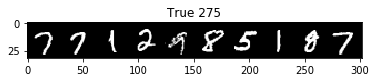

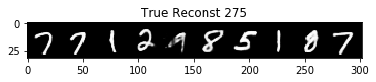

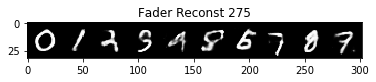


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 276 Fader Loss: -53.5318 | Adv Loss: 2.2951 | Rec Loss: 61.2210 
	| Adj Disc Loss: 344.2796 | Disc Acc: 0.1242


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 277 Fader Loss: -53.5602 | Adv Loss: 2.2952 | Rec Loss: 61.2017 
	| Adj Disc Loss: 344.3187 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 278 Fader Loss: -53.5948 | Adv Loss: 2.2960 | Rec Loss: 61.2043 
	| Adj Disc Loss: 344.4074 | Disc Acc: 0.1197


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 279 Fader Loss: -53.6075 | Adv Loss: 2.2954 | Rec Loss: 61.1607 
	| Adj Disc Loss: 344.3083 | Disc Acc: 0.1225


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 280 Fader Loss: -53.6115 | Adv Loss: 2.2947 | Rec Loss: 61.1235 
	| Adj Disc Loss: 344.2354 | Disc Acc: 0.1236


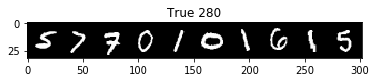

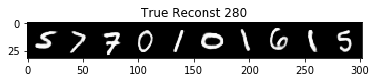

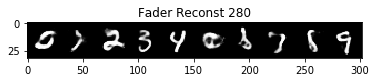


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 281 Fader Loss: -53.5978 | Adv Loss: 2.2947 | Rec Loss: 61.1355 
	| Adj Disc Loss: 344.2154 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 282 Fader Loss: -53.6226 | Adv Loss: 2.2951 | Rec Loss: 61.1328 
	| Adj Disc Loss: 344.3126 | Disc Acc: 0.1214


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 283 Fader Loss: -53.6237 | Adv Loss: 2.2950 | Rec Loss: 61.1256 
	| Adj Disc Loss: 344.2624 | Disc Acc: 0.1219


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 284 Fader Loss: -53.6558 | Adv Loss: 2.2952 | Rec Loss: 61.1048 
	| Adj Disc Loss: 344.3347 | Disc Acc: 0.1219


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 285 Fader Loss: -53.6361 | Adv Loss: 2.2947 | Rec Loss: 61.0967 
	| Adj Disc Loss: 344.3579 | Disc Acc: 0.1201


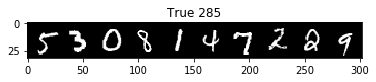

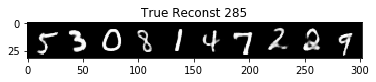

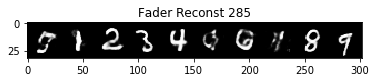


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 286 Fader Loss: -53.6364 | Adv Loss: 2.2941 | Rec Loss: 61.0710 
	| Adj Disc Loss: 344.3525 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 287 Fader Loss: -53.7190 | Adv Loss: 2.2960 | Rec Loss: 61.0809 
	| Adj Disc Loss: 344.3057 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 288 Fader Loss: -53.6635 | Adv Loss: 2.2947 | Rec Loss: 61.0694 
	| Adj Disc Loss: 344.3363 | Disc Acc: 0.1229


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 289 Fader Loss: -53.7021 | Adv Loss: 2.2953 | Rec Loss: 61.0649 
	| Adj Disc Loss: 344.2781 | Disc Acc: 0.1235


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 290 Fader Loss: -53.7144 | Adv Loss: 2.2954 | Rec Loss: 61.0536 
	| Adj Disc Loss: 344.3765 | Disc Acc: 0.1199


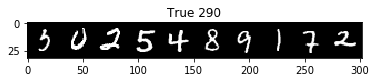

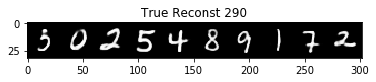

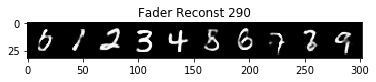


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 291 Fader Loss: -53.7188 | Adv Loss: 2.2951 | Rec Loss: 61.0378 
	| Adj Disc Loss: 344.3580 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 292 Fader Loss: -53.7442 | Adv Loss: 2.2956 | Rec Loss: 61.0356 
	| Adj Disc Loss: 344.3106 | Disc Acc: 0.1206


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 293 Fader Loss: -53.7249 | Adv Loss: 2.2950 | Rec Loss: 61.0256 
	| Adj Disc Loss: 344.3378 | Disc Acc: 0.1227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 294 Fader Loss: -53.7337 | Adv Loss: 2.2952 | Rec Loss: 61.0239 
	| Adj Disc Loss: 344.2952 | Disc Acc: 0.1231


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 295 Fader Loss: -53.7264 | Adv Loss: 2.2951 | Rec Loss: 61.0308 
	| Adj Disc Loss: 344.3066 | Disc Acc: 0.1214


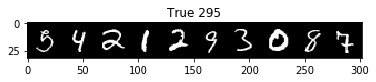

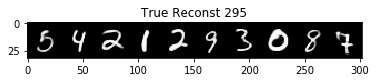

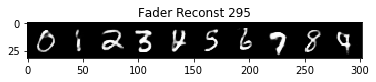


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 296 Fader Loss: -53.7305 | Adv Loss: 2.2959 | Rec Loss: 61.0646 
	| Adj Disc Loss: 344.3661 | Disc Acc: 0.1220


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 297 Fader Loss: -53.7090 | Adv Loss: 2.2951 | Rec Loss: 61.0466 
	| Adj Disc Loss: 344.3441 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 298 Fader Loss: -53.7756 | Adv Loss: 2.2962 | Rec Loss: 61.0346 
	| Adj Disc Loss: 344.4065 | Disc Acc: 0.1187


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 299 Fader Loss: -53.7633 | Adv Loss: 2.2956 | Rec Loss: 61.0156 
	| Adj Disc Loss: 344.4251 | Disc Acc: 0.1196


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 300 Fader Loss: -53.7850 | Adv Loss: 2.2961 | Rec Loss: 61.0209 
	| Adj Disc Loss: 344.4174 | Disc Acc: 0.1198


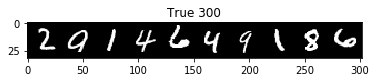

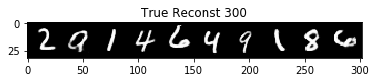

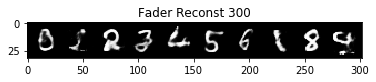


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 301 Fader Loss: -53.7979 | Adv Loss: 2.2954 | Rec Loss: 60.9732 
	| Adj Disc Loss: 344.3972 | Disc Acc: 0.1227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 302 Fader Loss: -53.7944 | Adv Loss: 2.2955 | Rec Loss: 60.9788 
	| Adj Disc Loss: 344.4561 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 303 Fader Loss: -53.8397 | Adv Loss: 2.2961 | Rec Loss: 60.9666 
	| Adj Disc Loss: 344.4935 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 304 Fader Loss: -53.8360 | Adv Loss: 2.2954 | Rec Loss: 60.9364 
	| Adj Disc Loss: 344.4094 | Disc Acc: 0.1258


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 305 Fader Loss: -53.8133 | Adv Loss: 2.2952 | Rec Loss: 60.9459 
	| Adj Disc Loss: 344.4119 | Disc Acc: 0.1212


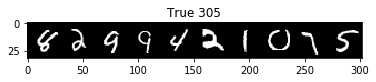

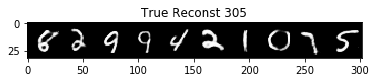

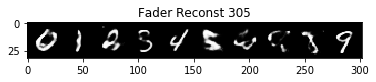


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 306 Fader Loss: -53.8473 | Adv Loss: 2.2958 | Rec Loss: 60.9436 
	| Adj Disc Loss: 344.4062 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 307 Fader Loss: -53.8383 | Adv Loss: 2.2957 | Rec Loss: 60.9442 
	| Adj Disc Loss: 344.3777 | Disc Acc: 0.1244


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 308 Fader Loss: -53.8371 | Adv Loss: 2.2959 | Rec Loss: 60.9562 
	| Adj Disc Loss: 344.4122 | Disc Acc: 0.1223


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 309 Fader Loss: -53.8132 | Adv Loss: 2.2950 | Rec Loss: 60.9384 
	| Adj Disc Loss: 344.3658 | Disc Acc: 0.1202


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 310 Fader Loss: -53.8044 | Adv Loss: 2.2951 | Rec Loss: 60.9502 
	| Adj Disc Loss: 344.2621 | Disc Acc: 0.1221


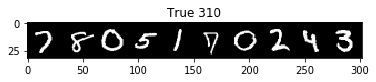

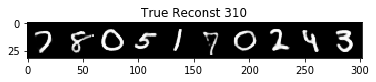

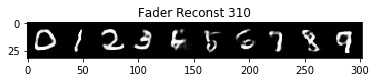


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 311 Fader Loss: -53.7977 | Adv Loss: 2.2944 | Rec Loss: 60.9245 
	| Adj Disc Loss: 344.2806 | Disc Acc: 0.1221


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 312 Fader Loss: -53.7612 | Adv Loss: 2.2937 | Rec Loss: 60.9248 
	| Adj Disc Loss: 344.1717 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 313 Fader Loss: -53.7486 | Adv Loss: 2.2941 | Rec Loss: 60.9584 
	| Adj Disc Loss: 344.1694 | Disc Acc: 0.1229


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 314 Fader Loss: -53.7572 | Adv Loss: 2.2938 | Rec Loss: 60.9307 
	| Adj Disc Loss: 344.1495 | Disc Acc: 0.1237


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 315 Fader Loss: -53.7564 | Adv Loss: 2.2941 | Rec Loss: 60.9505 
	| Adj Disc Loss: 344.2407 | Disc Acc: 0.1230


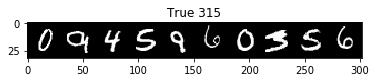

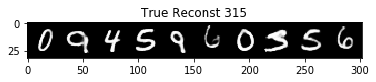

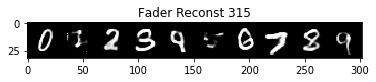


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 316 Fader Loss: -53.7832 | Adv Loss: 2.2945 | Rec Loss: 60.9413 
	| Adj Disc Loss: 344.2468 | Disc Acc: 0.1197


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 317 Fader Loss: -53.8072 | Adv Loss: 2.2944 | Rec Loss: 60.9139 
	| Adj Disc Loss: 344.1923 | Disc Acc: 0.1245


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 318 Fader Loss: -53.7894 | Adv Loss: 2.2937 | Rec Loss: 60.8965 
	| Adj Disc Loss: 344.1640 | Disc Acc: 0.1217


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 319 Fader Loss: -53.8044 | Adv Loss: 2.2942 | Rec Loss: 60.9041 
	| Adj Disc Loss: 344.2134 | Disc Acc: 0.1230


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 320 Fader Loss: -53.7986 | Adv Loss: 2.2939 | Rec Loss: 60.8939 
	| Adj Disc Loss: 344.1923 | Disc Acc: 0.1230


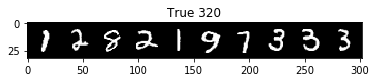

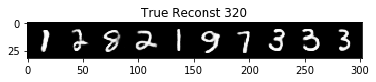

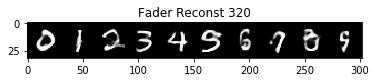


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 321 Fader Loss: -53.7918 | Adv Loss: 2.2942 | Rec Loss: 60.9165 
	| Adj Disc Loss: 344.2277 | Disc Acc: 0.1220


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 322 Fader Loss: -53.7971 | Adv Loss: 2.2941 | Rec Loss: 60.9073 
	| Adj Disc Loss: 344.1889 | Disc Acc: 0.1217


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 323 Fader Loss: -53.8090 | Adv Loss: 2.2939 | Rec Loss: 60.8859 
	| Adj Disc Loss: 344.1549 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 324 Fader Loss: -53.8285 | Adv Loss: 2.2943 | Rec Loss: 60.8875 
	| Adj Disc Loss: 344.1854 | Disc Acc: 0.1224


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 325 Fader Loss: -53.8224 | Adv Loss: 2.2943 | Rec Loss: 60.8947 
	| Adj Disc Loss: 344.2014 | Disc Acc: 0.1247


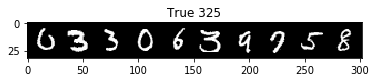

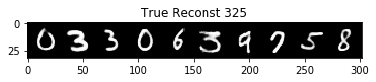

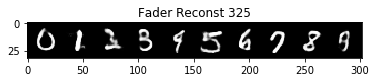


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 326 Fader Loss: -53.8260 | Adv Loss: 2.2944 | Rec Loss: 60.8934 
	| Adj Disc Loss: 344.2569 | Disc Acc: 0.1211


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 327 Fader Loss: -53.8199 | Adv Loss: 2.2940 | Rec Loss: 60.8777 
	| Adj Disc Loss: 344.1342 | Disc Acc: 0.1243


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 328 Fader Loss: -53.8048 | Adv Loss: 2.2934 | Rec Loss: 60.8674 
	| Adj Disc Loss: 344.1595 | Disc Acc: 0.1249


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 329 Fader Loss: -53.8461 | Adv Loss: 2.2965 | Rec Loss: 60.9766 
	| Adj Disc Loss: 344.5041 | Disc Acc: 0.1224


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 330 Fader Loss: -53.9017 | Adv Loss: 2.2966 | Rec Loss: 60.9301 
	| Adj Disc Loss: 344.4817 | Disc Acc: 0.1165


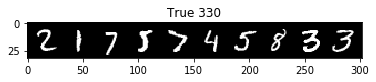

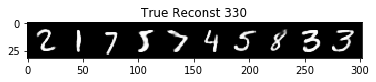

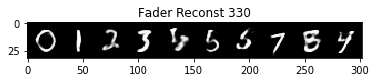


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 331 Fader Loss: -53.8632 | Adv Loss: 2.2945 | Rec Loss: 60.8639 
	| Adj Disc Loss: 344.2515 | Disc Acc: 0.1221


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 332 Fader Loss: -53.8569 | Adv Loss: 2.2951 | Rec Loss: 60.8989 
	| Adj Disc Loss: 344.2508 | Disc Acc: 0.1227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 333 Fader Loss: -53.8586 | Adv Loss: 2.2958 | Rec Loss: 60.9327 
	| Adj Disc Loss: 344.3928 | Disc Acc: 0.1163


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 334 Fader Loss: -53.8600 | Adv Loss: 2.2940 | Rec Loss: 60.8401 
	| Adj Disc Loss: 344.1850 | Disc Acc: 0.1229


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 335 Fader Loss: -53.8478 | Adv Loss: 2.2945 | Rec Loss: 60.8797 
	| Adj Disc Loss: 344.3190 | Disc Acc: 0.1224


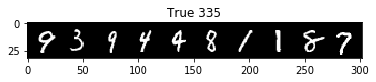

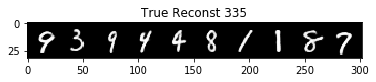

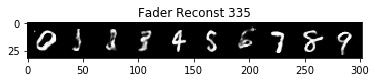


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 336 Fader Loss: -53.9125 | Adv Loss: 2.2948 | Rec Loss: 60.8287 
	| Adj Disc Loss: 344.2159 | Disc Acc: 0.1244


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 337 Fader Loss: -53.8957 | Adv Loss: 2.2946 | Rec Loss: 60.8332 
	| Adj Disc Loss: 344.3183 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 338 Fader Loss: -53.9640 | Adv Loss: 2.2963 | Rec Loss: 60.8508 
	| Adj Disc Loss: 344.4276 | Disc Acc: 0.1184


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 339 Fader Loss: -53.9506 | Adv Loss: 2.2959 | Rec Loss: 60.8423 
	| Adj Disc Loss: 344.4583 | Disc Acc: 0.1167


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 340 Fader Loss: -54.0175 | Adv Loss: 2.2954 | Rec Loss: 60.7546 
	| Adj Disc Loss: 344.3328 | Disc Acc: 0.1169


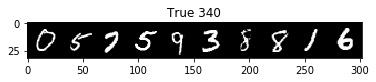

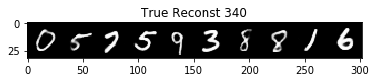

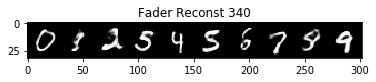


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 341 Fader Loss: -53.9979 | Adv Loss: 2.2946 | Rec Loss: 60.7336 
	| Adj Disc Loss: 344.2255 | Disc Acc: 0.1214


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 342 Fader Loss: -54.0128 | Adv Loss: 2.2949 | Rec Loss: 60.7327 
	| Adj Disc Loss: 344.1545 | Disc Acc: 0.1249


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 343 Fader Loss: -53.9756 | Adv Loss: 2.2944 | Rec Loss: 60.7427 
	| Adj Disc Loss: 344.2060 | Disc Acc: 0.1249


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 344 Fader Loss: -54.0370 | Adv Loss: 2.2959 | Rec Loss: 60.7558 
	| Adj Disc Loss: 344.3120 | Disc Acc: 0.1198


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 345 Fader Loss: -54.0107 | Adv Loss: 2.2949 | Rec Loss: 60.7342 
	| Adj Disc Loss: 344.3511 | Disc Acc: 0.1209


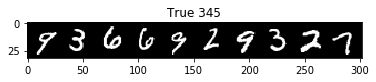

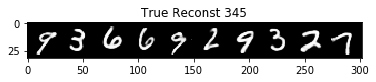

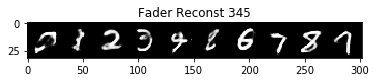


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 346 Fader Loss: -54.0048 | Adv Loss: 2.2956 | Rec Loss: 60.7735 
	| Adj Disc Loss: 344.4361 | Disc Acc: 0.1197


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 347 Fader Loss: -54.0462 | Adv Loss: 2.2955 | Rec Loss: 60.7274 
	| Adj Disc Loss: 344.3331 | Disc Acc: 0.1235


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 348 Fader Loss: -54.0516 | Adv Loss: 2.2956 | Rec Loss: 60.7290 
	| Adj Disc Loss: 344.4849 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 349 Fader Loss: -54.0702 | Adv Loss: 2.2956 | Rec Loss: 60.7107 
	| Adj Disc Loss: 344.3292 | Disc Acc: 0.1221


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 350 Fader Loss: -54.0694 | Adv Loss: 2.2962 | Rec Loss: 60.7424 
	| Adj Disc Loss: 344.5097 | Disc Acc: 0.1191


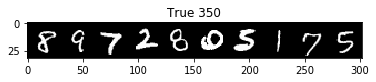

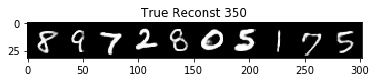

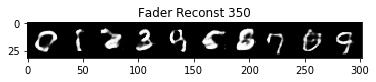


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 351 Fader Loss: -54.0825 | Adv Loss: 2.2957 | Rec Loss: 60.7037 
	| Adj Disc Loss: 344.4229 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 352 Fader Loss: -54.0834 | Adv Loss: 2.2952 | Rec Loss: 60.6749 
	| Adj Disc Loss: 344.2946 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 353 Fader Loss: -54.1016 | Adv Loss: 2.2953 | Rec Loss: 60.6632 
	| Adj Disc Loss: 344.3086 | Disc Acc: 0.1240


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 354 Fader Loss: -54.0902 | Adv Loss: 2.2955 | Rec Loss: 60.6827 
	| Adj Disc Loss: 344.3962 | Disc Acc: 0.1207


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 355 Fader Loss: -54.1108 | Adv Loss: 2.2954 | Rec Loss: 60.6608 
	| Adj Disc Loss: 344.4235 | Disc Acc: 0.1200


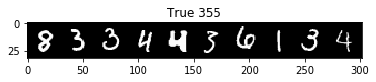

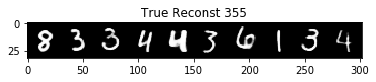

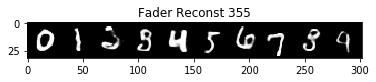


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 356 Fader Loss: -54.0859 | Adv Loss: 2.2956 | Rec Loss: 60.6966 
	| Adj Disc Loss: 344.4327 | Disc Acc: 0.1203


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 357 Fader Loss: -54.1443 | Adv Loss: 2.2957 | Rec Loss: 60.6391 
	| Adj Disc Loss: 344.4040 | Disc Acc: 0.1195


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 358 Fader Loss: -54.1578 | Adv Loss: 2.2969 | Rec Loss: 60.6881 
	| Adj Disc Loss: 344.5056 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 359 Fader Loss: -54.1571 | Adv Loss: 2.2956 | Rec Loss: 60.6221 
	| Adj Disc Loss: 344.3948 | Disc Acc: 0.1212


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 360 Fader Loss: -54.1885 | Adv Loss: 2.2956 | Rec Loss: 60.5897 
	| Adj Disc Loss: 344.3390 | Disc Acc: 0.1239


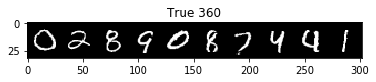

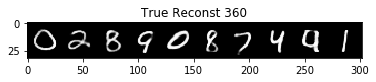

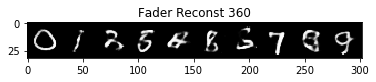


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 361 Fader Loss: -54.1823 | Adv Loss: 2.2965 | Rec Loss: 60.6409 
	| Adj Disc Loss: 344.3610 | Disc Acc: 0.1234


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 362 Fader Loss: -54.1554 | Adv Loss: 2.2954 | Rec Loss: 60.6169 
	| Adj Disc Loss: 344.3282 | Disc Acc: 0.1216


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 363 Fader Loss: -54.1601 | Adv Loss: 2.2960 | Rec Loss: 60.6376 
	| Adj Disc Loss: 344.3744 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 364 Fader Loss: -54.2121 | Adv Loss: 2.2966 | Rec Loss: 60.6194 
	| Adj Disc Loss: 344.4399 | Disc Acc: 0.1219


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 365 Fader Loss: -54.2190 | Adv Loss: 2.2969 | Rec Loss: 60.6261 
	| Adj Disc Loss: 344.4397 | Disc Acc: 0.1195


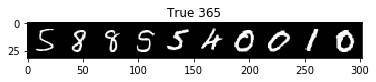

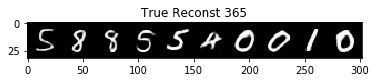

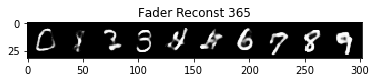


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 366 Fader Loss: -54.1922 | Adv Loss: 2.2958 | Rec Loss: 60.5973 
	| Adj Disc Loss: 344.4912 | Disc Acc: 0.1179


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 367 Fader Loss: -54.2268 | Adv Loss: 2.2965 | Rec Loss: 60.5973 
	| Adj Disc Loss: 344.5214 | Disc Acc: 0.1154


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 368 Fader Loss: -54.2155 | Adv Loss: 2.2956 | Rec Loss: 60.5643 
	| Adj Disc Loss: 344.4614 | Disc Acc: 0.1164


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 369 Fader Loss: -54.2106 | Adv Loss: 2.2958 | Rec Loss: 60.5807 
	| Adj Disc Loss: 344.4420 | Disc Acc: 0.1164


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 370 Fader Loss: -54.2242 | Adv Loss: 2.2960 | Rec Loss: 60.5737 
	| Adj Disc Loss: 344.4348 | Disc Acc: 0.1194


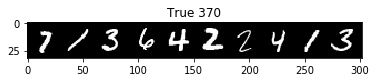

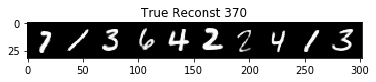

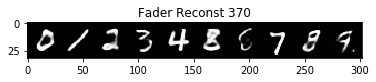


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 371 Fader Loss: -54.2327 | Adv Loss: 2.2958 | Rec Loss: 60.5586 
	| Adj Disc Loss: 344.4624 | Disc Acc: 0.1202


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 372 Fader Loss: -54.2489 | Adv Loss: 2.2959 | Rec Loss: 60.5460 
	| Adj Disc Loss: 344.4203 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 373 Fader Loss: -54.2338 | Adv Loss: 2.2959 | Rec Loss: 60.5600 
	| Adj Disc Loss: 344.4944 | Disc Acc: 0.1202


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 374 Fader Loss: -54.2555 | Adv Loss: 2.2962 | Rec Loss: 60.5549 
	| Adj Disc Loss: 344.4039 | Disc Acc: 0.1198


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 375 Fader Loss: -54.2574 | Adv Loss: 2.2965 | Rec Loss: 60.5660 
	| Adj Disc Loss: 344.4920 | Disc Acc: 0.1191


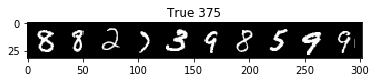

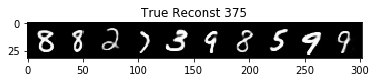

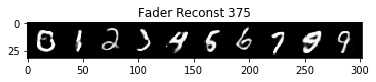


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 376 Fader Loss: -54.2811 | Adv Loss: 2.2963 | Rec Loss: 60.5355 
	| Adj Disc Loss: 344.3745 | Disc Acc: 0.1216


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 377 Fader Loss: -54.2917 | Adv Loss: 2.2958 | Rec Loss: 60.4971 
	| Adj Disc Loss: 344.4166 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 378 Fader Loss: -54.2629 | Adv Loss: 2.2961 | Rec Loss: 60.5405 
	| Adj Disc Loss: 344.3933 | Disc Acc: 0.1214


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 379 Fader Loss: -54.2275 | Adv Loss: 2.2952 | Rec Loss: 60.5340 
	| Adj Disc Loss: 344.3900 | Disc Acc: 0.1190


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 380 Fader Loss: -54.2772 | Adv Loss: 2.2956 | Rec Loss: 60.5034 
	| Adj Disc Loss: 344.3757 | Disc Acc: 0.1210


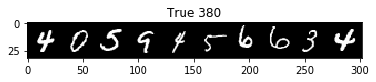

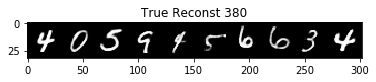

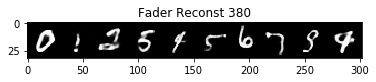


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 381 Fader Loss: -54.2992 | Adv Loss: 2.2958 | Rec Loss: 60.4926 
	| Adj Disc Loss: 344.3347 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 382 Fader Loss: -54.2759 | Adv Loss: 2.2954 | Rec Loss: 60.4959 
	| Adj Disc Loss: 344.3578 | Disc Acc: 0.1223


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 383 Fader Loss: -54.2559 | Adv Loss: 2.2953 | Rec Loss: 60.5107 
	| Adj Disc Loss: 344.3064 | Disc Acc: 0.1234


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 384 Fader Loss: -54.2637 | Adv Loss: 2.2956 | Rec Loss: 60.5149 
	| Adj Disc Loss: 344.4042 | Disc Acc: 0.1217


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 385 Fader Loss: -54.2732 | Adv Loss: 2.2954 | Rec Loss: 60.4972 
	| Adj Disc Loss: 344.3819 | Disc Acc: 0.1187


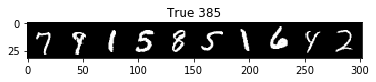

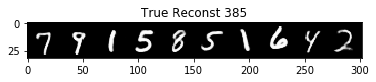

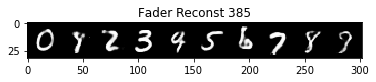


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 386 Fader Loss: -54.2976 | Adv Loss: 2.2951 | Rec Loss: 60.4572 
	| Adj Disc Loss: 344.2742 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 387 Fader Loss: -54.2748 | Adv Loss: 2.2950 | Rec Loss: 60.4739 
	| Adj Disc Loss: 344.3487 | Disc Acc: 0.1237


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 388 Fader Loss: -54.2946 | Adv Loss: 2.2953 | Rec Loss: 60.4722 
	| Adj Disc Loss: 344.3326 | Disc Acc: 0.1218


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 389 Fader Loss: -54.2652 | Adv Loss: 2.2948 | Rec Loss: 60.4758 
	| Adj Disc Loss: 344.2882 | Disc Acc: 0.1257


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 390 Fader Loss: -54.2996 | Adv Loss: 2.2953 | Rec Loss: 60.4636 
	| Adj Disc Loss: 344.3166 | Disc Acc: 0.1214


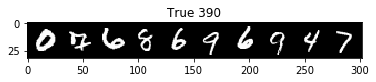

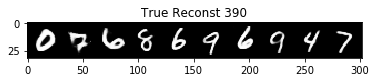

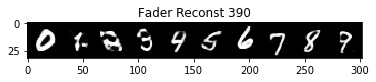


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 391 Fader Loss: -54.3888 | Adv Loss: 2.2959 | Rec Loss: 60.4071 
	| Adj Disc Loss: 344.2424 | Disc Acc: 0.1255


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 392 Fader Loss: -54.3312 | Adv Loss: 2.2958 | Rec Loss: 60.4593 
	| Adj Disc Loss: 344.4437 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 393 Fader Loss: -54.3557 | Adv Loss: 2.2964 | Rec Loss: 60.4637 
	| Adj Disc Loss: 344.4455 | Disc Acc: 0.1218


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 394 Fader Loss: -54.3393 | Adv Loss: 2.2956 | Rec Loss: 60.4421 
	| Adj Disc Loss: 344.4767 | Disc Acc: 0.1199


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 395 Fader Loss: -54.4268 | Adv Loss: 2.2965 | Rec Loss: 60.3971 
	| Adj Disc Loss: 344.4555 | Disc Acc: 0.1203


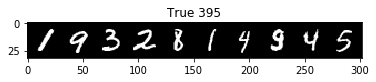

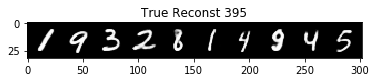

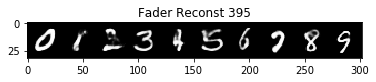


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 396 Fader Loss: -54.3943 | Adv Loss: 2.2954 | Rec Loss: 60.3757 
	| Adj Disc Loss: 344.2874 | Disc Acc: 0.1275


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 397 Fader Loss: -54.4207 | Adv Loss: 2.2964 | Rec Loss: 60.3979 
	| Adj Disc Loss: 344.4549 | Disc Acc: 0.1237


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 398 Fader Loss: -54.3880 | Adv Loss: 2.2957 | Rec Loss: 60.3991 
	| Adj Disc Loss: 344.4172 | Disc Acc: 0.1247


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 399 Fader Loss: -54.4567 | Adv Loss: 2.2967 | Rec Loss: 60.3796 
	| Adj Disc Loss: 344.4583 | Disc Acc: 0.1260


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 400 Fader Loss: -54.4307 | Adv Loss: 2.2966 | Rec Loss: 60.4007 
	| Adj Disc Loss: 344.4660 | Disc Acc: 0.1204


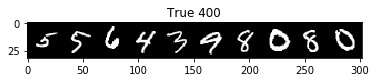

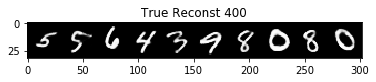

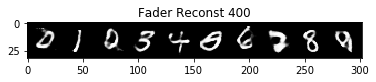


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 401 Fader Loss: -54.4166 | Adv Loss: 2.2960 | Rec Loss: 60.3825 
	| Adj Disc Loss: 344.5095 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 402 Fader Loss: -54.4508 | Adv Loss: 2.2963 | Rec Loss: 60.3644 
	| Adj Disc Loss: 344.4589 | Disc Acc: 0.1244


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 403 Fader Loss: -54.4234 | Adv Loss: 2.2958 | Rec Loss: 60.3674 
	| Adj Disc Loss: 344.4293 | Disc Acc: 0.1221


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 404 Fader Loss: -54.4055 | Adv Loss: 2.2963 | Rec Loss: 60.4080 
	| Adj Disc Loss: 344.3838 | Disc Acc: 0.1255


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 405 Fader Loss: -54.3839 | Adv Loss: 2.2962 | Rec Loss: 60.4245 
	| Adj Disc Loss: 344.4650 | Disc Acc: 0.1205


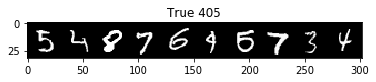

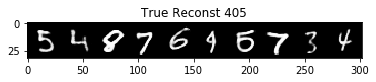

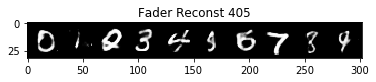


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 406 Fader Loss: -54.4471 | Adv Loss: 2.2963 | Rec Loss: 60.3682 
	| Adj Disc Loss: 344.5084 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 407 Fader Loss: -54.3914 | Adv Loss: 2.2953 | Rec Loss: 60.3717 
	| Adj Disc Loss: 344.4341 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 408 Fader Loss: -54.4321 | Adv Loss: 2.2960 | Rec Loss: 60.3686 
	| Adj Disc Loss: 344.4137 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 409 Fader Loss: -54.4090 | Adv Loss: 2.2957 | Rec Loss: 60.3760 
	| Adj Disc Loss: 344.5067 | Disc Acc: 0.1219


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 410 Fader Loss: -54.4170 | Adv Loss: 2.2957 | Rec Loss: 60.3694 
	| Adj Disc Loss: 344.4542 | Disc Acc: 0.1234


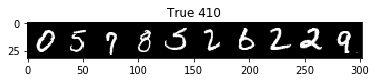

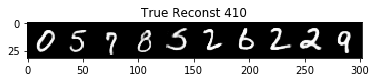

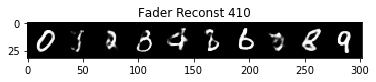


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 411 Fader Loss: -54.3985 | Adv Loss: 2.2955 | Rec Loss: 60.3741 
	| Adj Disc Loss: 344.4670 | Disc Acc: 0.1272


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 412 Fader Loss: -54.3975 | Adv Loss: 2.2963 | Rec Loss: 60.4183 
	| Adj Disc Loss: 344.4661 | Disc Acc: 0.1211


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 413 Fader Loss: -54.4110 | Adv Loss: 2.2958 | Rec Loss: 60.3770 
	| Adj Disc Loss: 344.4559 | Disc Acc: 0.1234


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 414 Fader Loss: -54.4526 | Adv Loss: 2.2963 | Rec Loss: 60.3631 
	| Adj Disc Loss: 344.3693 | Disc Acc: 0.1247


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 415 Fader Loss: -54.4155 | Adv Loss: 2.2956 | Rec Loss: 60.3622 
	| Adj Disc Loss: 344.3567 | Disc Acc: 0.1232


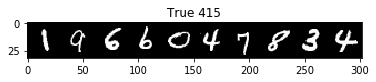

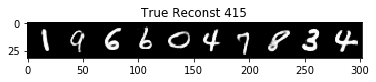

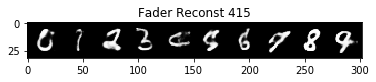


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 416 Fader Loss: -54.3923 | Adv Loss: 2.2949 | Rec Loss: 60.3531 
	| Adj Disc Loss: 344.3540 | Disc Acc: 0.1267


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 417 Fader Loss: -54.4473 | Adv Loss: 2.2959 | Rec Loss: 60.3455 
	| Adj Disc Loss: 344.3474 | Disc Acc: 0.1225


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 418 Fader Loss: -54.4014 | Adv Loss: 2.2957 | Rec Loss: 60.3824 
	| Adj Disc Loss: 344.4501 | Disc Acc: 0.1240


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 419 Fader Loss: -54.4183 | Adv Loss: 2.2958 | Rec Loss: 60.3706 
	| Adj Disc Loss: 344.3783 | Disc Acc: 0.1260


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 420 Fader Loss: -54.4054 | Adv Loss: 2.2956 | Rec Loss: 60.3759 
	| Adj Disc Loss: 344.3689 | Disc Acc: 0.1236


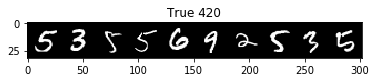

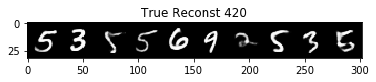

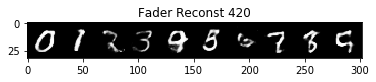


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 421 Fader Loss: -54.4635 | Adv Loss: 2.2966 | Rec Loss: 60.3640 
	| Adj Disc Loss: 344.4914 | Disc Acc: 0.1218


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 422 Fader Loss: -54.4200 | Adv Loss: 2.2958 | Rec Loss: 60.3711 
	| Adj Disc Loss: 344.4594 | Disc Acc: 0.1217


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 423 Fader Loss: -54.4406 | Adv Loss: 2.2958 | Rec Loss: 60.3506 
	| Adj Disc Loss: 344.5298 | Disc Acc: 0.1203


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 424 Fader Loss: -54.4931 | Adv Loss: 2.2957 | Rec Loss: 60.2897 
	| Adj Disc Loss: 344.3512 | Disc Acc: 0.1209


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 425 Fader Loss: -54.4115 | Adv Loss: 2.2947 | Rec Loss: 60.3233 
	| Adj Disc Loss: 344.3416 | Disc Acc: 0.1218


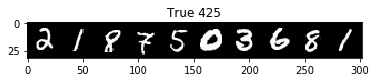

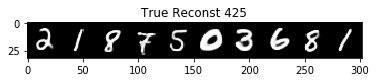

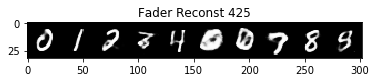


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 426 Fader Loss: -54.4739 | Adv Loss: 2.2956 | Rec Loss: 60.3059 
	| Adj Disc Loss: 344.3851 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 427 Fader Loss: -54.4550 | Adv Loss: 2.2947 | Rec Loss: 60.2817 
	| Adj Disc Loss: 344.2530 | Disc Acc: 0.1216


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 428 Fader Loss: -54.4529 | Adv Loss: 2.2947 | Rec Loss: 60.2842 
	| Adj Disc Loss: 344.2792 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 429 Fader Loss: -54.4588 | Adv Loss: 2.2950 | Rec Loss: 60.2890 
	| Adj Disc Loss: 344.2591 | Disc Acc: 0.1245


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 430 Fader Loss: -54.4557 | Adv Loss: 2.2952 | Rec Loss: 60.3029 
	| Adj Disc Loss: 344.3205 | Disc Acc: 0.1239


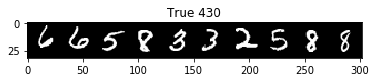

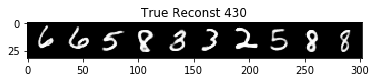

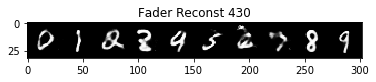


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 431 Fader Loss: -54.4541 | Adv Loss: 2.2956 | Rec Loss: 60.3234 
	| Adj Disc Loss: 344.3806 | Disc Acc: 0.1228


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 432 Fader Loss: -54.4589 | Adv Loss: 2.2955 | Rec Loss: 60.3155 
	| Adj Disc Loss: 344.3284 | Disc Acc: 0.1223


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 433 Fader Loss: -54.4643 | Adv Loss: 2.2956 | Rec Loss: 60.3139 
	| Adj Disc Loss: 344.3297 | Disc Acc: 0.1235


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 434 Fader Loss: -54.4223 | Adv Loss: 2.2941 | Rec Loss: 60.2842 
	| Adj Disc Loss: 344.1687 | Disc Acc: 0.1283


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 435 Fader Loss: -54.4476 | Adv Loss: 2.2950 | Rec Loss: 60.3021 
	| Adj Disc Loss: 344.2624 | Disc Acc: 0.1240


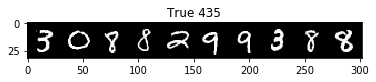

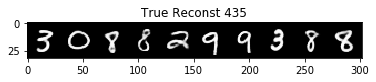

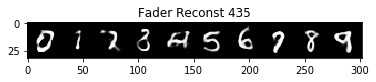


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 436 Fader Loss: -54.4512 | Adv Loss: 2.2948 | Rec Loss: 60.2893 
	| Adj Disc Loss: 344.1773 | Disc Acc: 0.1249


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 437 Fader Loss: -54.4113 | Adv Loss: 2.2945 | Rec Loss: 60.3115 
	| Adj Disc Loss: 344.2389 | Disc Acc: 0.1243


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 438 Fader Loss: -54.4561 | Adv Loss: 2.2948 | Rec Loss: 60.2816 
	| Adj Disc Loss: 344.2324 | Disc Acc: 0.1246


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 439 Fader Loss: -54.4753 | Adv Loss: 2.2948 | Rec Loss: 60.2634 
	| Adj Disc Loss: 344.2250 | Disc Acc: 0.1209


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 440 Fader Loss: -54.4797 | Adv Loss: 2.2949 | Rec Loss: 60.2668 
	| Adj Disc Loss: 344.2301 | Disc Acc: 0.1233


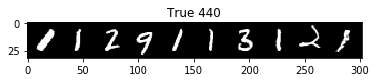

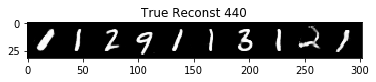

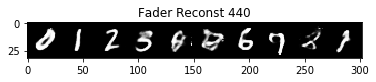


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 441 Fader Loss: -54.4765 | Adv Loss: 2.2951 | Rec Loss: 60.2776 
	| Adj Disc Loss: 344.3907 | Disc Acc: 0.1237


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 442 Fader Loss: -54.4885 | Adv Loss: 2.2956 | Rec Loss: 60.2916 
	| Adj Disc Loss: 344.2803 | Disc Acc: 0.1250


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 443 Fader Loss: -54.5128 | Adv Loss: 2.2954 | Rec Loss: 60.2578 
	| Adj Disc Loss: 344.3981 | Disc Acc: 0.1205


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 444 Fader Loss: -54.4824 | Adv Loss: 2.2953 | Rec Loss: 60.2821 
	| Adj Disc Loss: 344.3657 | Disc Acc: 0.1203


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 445 Fader Loss: -54.5377 | Adv Loss: 2.2958 | Rec Loss: 60.2500 
	| Adj Disc Loss: 344.3787 | Disc Acc: 0.1222


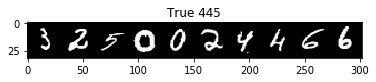

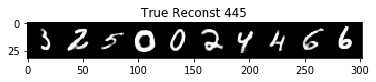

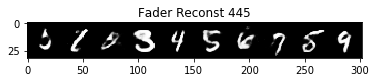


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 446 Fader Loss: -54.5235 | Adv Loss: 2.2954 | Rec Loss: 60.2461 
	| Adj Disc Loss: 344.3963 | Disc Acc: 0.1205


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 447 Fader Loss: -54.5814 | Adv Loss: 2.2958 | Rec Loss: 60.2068 
	| Adj Disc Loss: 344.3595 | Disc Acc: 0.1218


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 448 Fader Loss: -54.5845 | Adv Loss: 2.2955 | Rec Loss: 60.1890 
	| Adj Disc Loss: 344.3703 | Disc Acc: 0.1227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 449 Fader Loss: -54.5776 | Adv Loss: 2.2957 | Rec Loss: 60.2094 
	| Adj Disc Loss: 344.4231 | Disc Acc: 0.1212


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 450 Fader Loss: -54.6434 | Adv Loss: 2.2963 | Rec Loss: 60.1708 
	| Adj Disc Loss: 344.4364 | Disc Acc: 0.1204


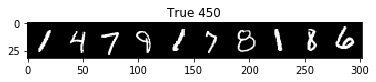

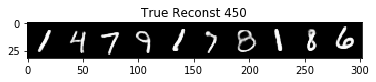

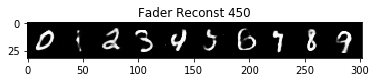


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 451 Fader Loss: -54.5996 | Adv Loss: 2.2953 | Rec Loss: 60.1633 
	| Adj Disc Loss: 344.3517 | Disc Acc: 0.1232


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 452 Fader Loss: -54.6003 | Adv Loss: 2.2952 | Rec Loss: 60.1621 
	| Adj Disc Loss: 344.3150 | Disc Acc: 0.1255


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 453 Fader Loss: -54.6365 | Adv Loss: 2.2957 | Rec Loss: 60.1479 
	| Adj Disc Loss: 344.3941 | Disc Acc: 0.1205


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 454 Fader Loss: -54.6215 | Adv Loss: 2.2957 | Rec Loss: 60.1621 
	| Adj Disc Loss: 344.4199 | Disc Acc: 0.1224


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 455 Fader Loss: -54.6323 | Adv Loss: 2.2956 | Rec Loss: 60.1484 
	| Adj Disc Loss: 344.4251 | Disc Acc: 0.1208


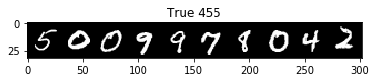

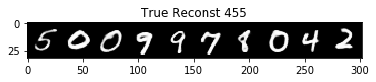

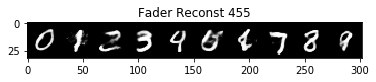


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 456 Fader Loss: -54.6518 | Adv Loss: 2.2954 | Rec Loss: 60.1162 
	| Adj Disc Loss: 344.3966 | Disc Acc: 0.1195


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 457 Fader Loss: -54.6308 | Adv Loss: 2.2956 | Rec Loss: 60.1511 
	| Adj Disc Loss: 344.3548 | Disc Acc: 0.1235


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 458 Fader Loss: -54.6908 | Adv Loss: 2.2960 | Rec Loss: 60.1099 
	| Adj Disc Loss: 344.3815 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 459 Fader Loss: -54.6629 | Adv Loss: 2.2955 | Rec Loss: 60.1144 
	| Adj Disc Loss: 344.3504 | Disc Acc: 0.1192


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 460 Fader Loss: -54.6410 | Adv Loss: 2.2951 | Rec Loss: 60.1164 
	| Adj Disc Loss: 344.3309 | Disc Acc: 0.1206


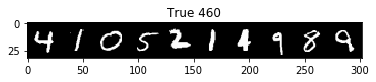

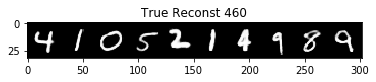

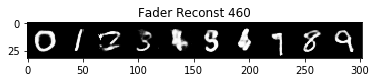


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 461 Fader Loss: -54.7288 | Adv Loss: 2.2964 | Rec Loss: 60.0922 
	| Adj Disc Loss: 344.4342 | Disc Acc: 0.1155


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 462 Fader Loss: -54.6883 | Adv Loss: 2.2954 | Rec Loss: 60.0814 
	| Adj Disc Loss: 344.3304 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 463 Fader Loss: -54.6687 | Adv Loss: 2.2952 | Rec Loss: 60.0933 
	| Adj Disc Loss: 344.3627 | Disc Acc: 0.1182


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 464 Fader Loss: -54.6568 | Adv Loss: 2.2950 | Rec Loss: 60.0914 
	| Adj Disc Loss: 344.2320 | Disc Acc: 0.1216


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 465 Fader Loss: -54.6740 | Adv Loss: 2.2952 | Rec Loss: 60.0865 
	| Adj Disc Loss: 344.2659 | Disc Acc: 0.1182


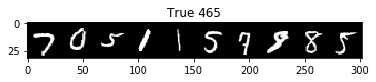

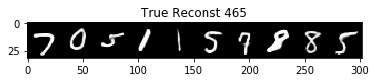

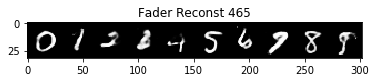


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 466 Fader Loss: -54.6396 | Adv Loss: 2.2949 | Rec Loss: 60.1036 
	| Adj Disc Loss: 344.2647 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 467 Fader Loss: -54.6488 | Adv Loss: 2.2951 | Rec Loss: 60.1079 
	| Adj Disc Loss: 344.2706 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 468 Fader Loss: -54.6427 | Adv Loss: 2.2951 | Rec Loss: 60.1138 
	| Adj Disc Loss: 344.3330 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 469 Fader Loss: -54.7052 | Adv Loss: 2.2960 | Rec Loss: 60.0935 
	| Adj Disc Loss: 344.3973 | Disc Acc: 0.1189


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 470 Fader Loss: -54.6814 | Adv Loss: 2.2956 | Rec Loss: 60.0966 
	| Adj Disc Loss: 344.3814 | Disc Acc: 0.1238


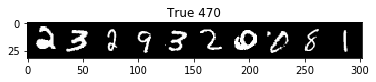

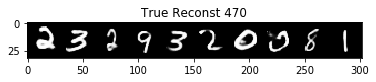

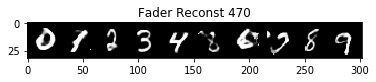


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 471 Fader Loss: -54.7119 | Adv Loss: 2.2960 | Rec Loss: 60.0892 
	| Adj Disc Loss: 344.3760 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 472 Fader Loss: -54.7173 | Adv Loss: 2.2962 | Rec Loss: 60.0905 
	| Adj Disc Loss: 344.3664 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 473 Fader Loss: -54.7032 | Adv Loss: 2.2957 | Rec Loss: 60.0842 
	| Adj Disc Loss: 344.2339 | Disc Acc: 0.1220


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 474 Fader Loss: -54.6825 | Adv Loss: 2.2957 | Rec Loss: 60.1037 
	| Adj Disc Loss: 344.3580 | Disc Acc: 0.1215


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 475 Fader Loss: -54.6749 | Adv Loss: 2.2955 | Rec Loss: 60.0999 
	| Adj Disc Loss: 344.3489 | Disc Acc: 0.1216


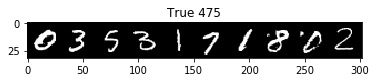

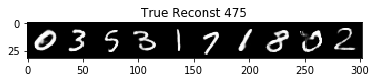

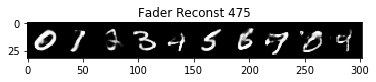


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 476 Fader Loss: -54.6678 | Adv Loss: 2.2952 | Rec Loss: 60.0927 
	| Adj Disc Loss: 344.2629 | Disc Acc: 0.1249


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 477 Fader Loss: -54.7002 | Adv Loss: 2.2952 | Rec Loss: 60.0607 
	| Adj Disc Loss: 344.3292 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 478 Fader Loss: -54.6958 | Adv Loss: 2.2956 | Rec Loss: 60.0825 
	| Adj Disc Loss: 344.3974 | Disc Acc: 0.1229


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 479 Fader Loss: -54.7237 | Adv Loss: 2.2956 | Rec Loss: 60.0565 
	| Adj Disc Loss: 344.4421 | Disc Acc: 0.1203


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 480 Fader Loss: -54.7529 | Adv Loss: 2.2959 | Rec Loss: 60.0420 
	| Adj Disc Loss: 344.4136 | Disc Acc: 0.1244


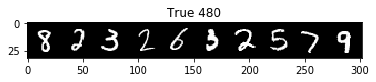

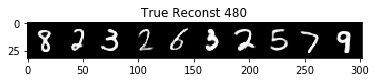

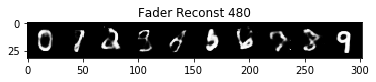


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 481 Fader Loss: -54.7512 | Adv Loss: 2.2958 | Rec Loss: 60.0378 
	| Adj Disc Loss: 344.3884 | Disc Acc: 0.1196


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 482 Fader Loss: -54.7395 | Adv Loss: 2.2956 | Rec Loss: 60.0381 
	| Adj Disc Loss: 344.3406 | Disc Acc: 0.1219


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 483 Fader Loss: -54.7688 | Adv Loss: 2.2959 | Rec Loss: 60.0261 
	| Adj Disc Loss: 344.4159 | Disc Acc: 0.1152


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 484 Fader Loss: -54.7911 | Adv Loss: 2.2958 | Rec Loss: 59.9972 
	| Adj Disc Loss: 344.3709 | Disc Acc: 0.1198


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 485 Fader Loss: -54.7685 | Adv Loss: 2.2950 | Rec Loss: 59.9791 
	| Adj Disc Loss: 344.3863 | Disc Acc: 0.1193


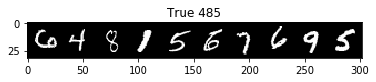

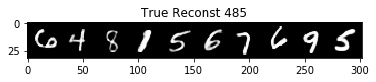

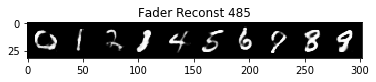


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 486 Fader Loss: -54.7495 | Adv Loss: 2.2947 | Rec Loss: 59.9838 
	| Adj Disc Loss: 344.2825 | Disc Acc: 0.1193


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 487 Fader Loss: -54.7498 | Adv Loss: 2.2947 | Rec Loss: 59.9847 
	| Adj Disc Loss: 344.2703 | Disc Acc: 0.1188


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 488 Fader Loss: -54.7258 | Adv Loss: 2.2944 | Rec Loss: 59.9951 
	| Adj Disc Loss: 344.2225 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 489 Fader Loss: -54.7379 | Adv Loss: 2.2948 | Rec Loss: 59.9996 
	| Adj Disc Loss: 344.2585 | Disc Acc: 0.1173


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 490 Fader Loss: -54.7294 | Adv Loss: 2.2944 | Rec Loss: 59.9901 
	| Adj Disc Loss: 344.1859 | Disc Acc: 0.1214


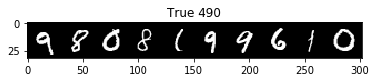

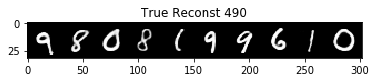

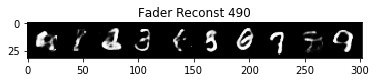


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 491 Fader Loss: -54.7203 | Adv Loss: 2.2956 | Rec Loss: 60.0585 
	| Adj Disc Loss: 344.2844 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 492 Fader Loss: -54.7517 | Adv Loss: 2.2951 | Rec Loss: 60.0024 
	| Adj Disc Loss: 344.3063 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 493 Fader Loss: -54.7552 | Adv Loss: 2.2952 | Rec Loss: 60.0052 
	| Adj Disc Loss: 344.2584 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 494 Fader Loss: -54.6844 | Adv Loss: 2.2943 | Rec Loss: 60.0310 
	| Adj Disc Loss: 344.2167 | Disc Acc: 0.1214


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 495 Fader Loss: -54.7000 | Adv Loss: 2.2947 | Rec Loss: 60.0374 
	| Adj Disc Loss: 344.2105 | Disc Acc: 0.1203


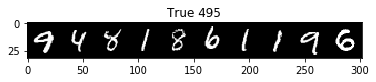

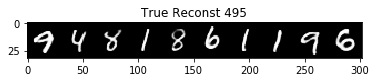

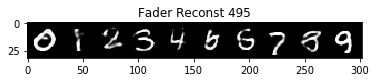


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 496 Fader Loss: -54.6589 | Adv Loss: 2.2941 | Rec Loss: 60.0437 
	| Adj Disc Loss: 344.1784 | Disc Acc: 0.1190


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 497 Fader Loss: -54.7052 | Adv Loss: 2.2951 | Rec Loss: 60.0521 
	| Adj Disc Loss: 344.3742 | Disc Acc: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 498 Fader Loss: -54.7566 | Adv Loss: 2.2952 | Rec Loss: 60.0031 
	| Adj Disc Loss: 344.3083 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 499 Fader Loss: -54.7258 | Adv Loss: 2.2947 | Rec Loss: 60.0097 
	| Adj Disc Loss: 344.2623 | Disc Acc: 0.1202


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 500 Fader Loss: -54.7111 | Adv Loss: 2.2948 | Rec Loss: 60.0313 
	| Adj Disc Loss: 344.2937 | Disc Acc: 0.1225


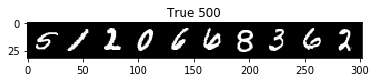

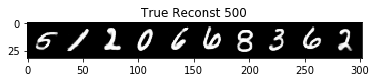

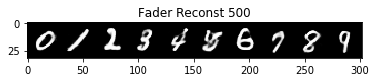


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 501 Fader Loss: -54.7518 | Adv Loss: 2.2958 | Rec Loss: 60.0398 
	| Adj Disc Loss: 344.4095 | Disc Acc: 0.1199


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 502 Fader Loss: -54.7005 | Adv Loss: 2.2948 | Rec Loss: 60.0404 
	| Adj Disc Loss: 344.3752 | Disc Acc: 0.1198


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 503 Fader Loss: -54.7494 | Adv Loss: 2.2955 | Rec Loss: 60.0279 
	| Adj Disc Loss: 344.4081 | Disc Acc: 0.1210


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 504 Fader Loss: -54.7840 | Adv Loss: 2.2953 | Rec Loss: 59.9821 
	| Adj Disc Loss: 344.3331 | Disc Acc: 0.1209


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 505 Fader Loss: -54.7290 | Adv Loss: 2.2950 | Rec Loss: 60.0202 
	| Adj Disc Loss: 344.3819 | Disc Acc: 0.1237


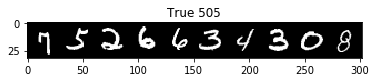

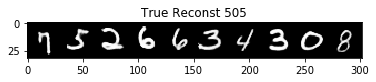

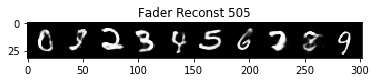


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 506 Fader Loss: -54.7734 | Adv Loss: 2.2954 | Rec Loss: 59.9986 
	| Adj Disc Loss: 344.3001 | Disc Acc: 0.1232


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 507 Fader Loss: -54.8091 | Adv Loss: 2.2963 | Rec Loss: 60.0048 
	| Adj Disc Loss: 344.4573 | Disc Acc: 0.1198


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 508 Fader Loss: -54.7988 | Adv Loss: 2.2962 | Rec Loss: 60.0134 
	| Adj Disc Loss: 344.4578 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 509 Fader Loss: -54.8094 | Adv Loss: 2.2964 | Rec Loss: 60.0114 
	| Adj Disc Loss: 344.4366 | Disc Acc: 0.1219


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 510 Fader Loss: -54.8026 | Adv Loss: 2.2969 | Rec Loss: 60.0413 
	| Adj Disc Loss: 344.5355 | Disc Acc: 0.1178


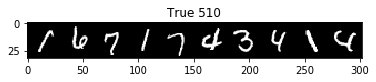

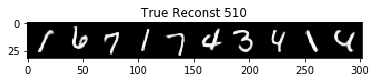

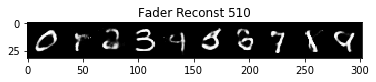


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 511 Fader Loss: -54.8059 | Adv Loss: 2.2961 | Rec Loss: 59.9980 
	| Adj Disc Loss: 344.4244 | Disc Acc: 0.1232


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 512 Fader Loss: -54.8130 | Adv Loss: 2.2965 | Rec Loss: 60.0107 
	| Adj Disc Loss: 344.4362 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 513 Fader Loss: -54.7976 | Adv Loss: 2.2964 | Rec Loss: 60.0205 
	| Adj Disc Loss: 344.4292 | Disc Acc: 0.1229


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 514 Fader Loss: -54.7770 | Adv Loss: 2.2959 | Rec Loss: 60.0202 
	| Adj Disc Loss: 344.5519 | Disc Acc: 0.1216


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 515 Fader Loss: -54.8142 | Adv Loss: 2.2961 | Rec Loss: 59.9896 
	| Adj Disc Loss: 344.4559 | Disc Acc: 0.1209


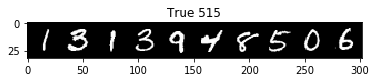

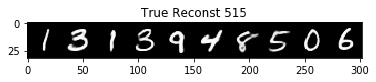

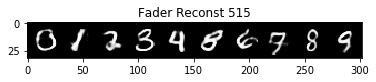


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 516 Fader Loss: -54.8414 | Adv Loss: 2.2962 | Rec Loss: 59.9703 
	| Adj Disc Loss: 344.5102 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 517 Fader Loss: -54.8117 | Adv Loss: 2.2956 | Rec Loss: 59.9699 
	| Adj Disc Loss: 344.3617 | Disc Acc: 0.1255


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 518 Fader Loss: -54.7857 | Adv Loss: 2.2958 | Rec Loss: 60.0060 
	| Adj Disc Loss: 344.4703 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 519 Fader Loss: -54.8022 | Adv Loss: 2.2961 | Rec Loss: 60.0026 
	| Adj Disc Loss: 344.4758 | Disc Acc: 0.1210


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 520 Fader Loss: -54.8066 | Adv Loss: 2.2959 | Rec Loss: 59.9887 
	| Adj Disc Loss: 344.4270 | Disc Acc: 0.1235


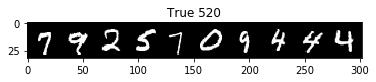

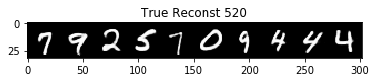

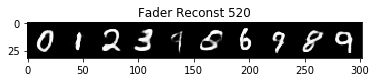


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 521 Fader Loss: -54.8059 | Adv Loss: 2.2964 | Rec Loss: 60.0133 
	| Adj Disc Loss: 344.4556 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 522 Fader Loss: -54.8130 | Adv Loss: 2.2961 | Rec Loss: 59.9898 
	| Adj Disc Loss: 344.4685 | Disc Acc: 0.1205


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 523 Fader Loss: -54.8130 | Adv Loss: 2.2960 | Rec Loss: 59.9882 
	| Adj Disc Loss: 344.4700 | Disc Acc: 0.1227


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 524 Fader Loss: -54.8466 | Adv Loss: 2.2965 | Rec Loss: 59.9765 
	| Adj Disc Loss: 344.5177 | Disc Acc: 0.1223


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 525 Fader Loss: -54.8319 | Adv Loss: 2.2958 | Rec Loss: 59.9599 
	| Adj Disc Loss: 344.3709 | Disc Acc: 0.1218


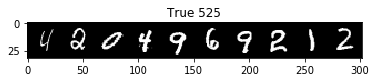

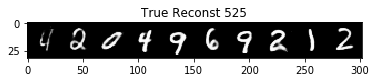

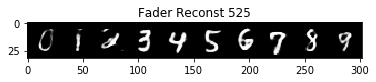


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 526 Fader Loss: -54.8537 | Adv Loss: 2.2962 | Rec Loss: 59.9548 
	| Adj Disc Loss: 344.4606 | Disc Acc: 0.1222


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 527 Fader Loss: -54.8330 | Adv Loss: 2.2958 | Rec Loss: 59.9547 
	| Adj Disc Loss: 344.4466 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 528 Fader Loss: -54.8525 | Adv Loss: 2.2961 | Rec Loss: 59.9505 
	| Adj Disc Loss: 344.4492 | Disc Acc: 0.1228


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 529 Fader Loss: -54.8080 | Adv Loss: 2.2954 | Rec Loss: 59.9623 
	| Adj Disc Loss: 344.3805 | Disc Acc: 0.1265


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 530 Fader Loss: -54.8396 | Adv Loss: 2.2964 | Rec Loss: 59.9792 
	| Adj Disc Loss: 344.5439 | Disc Acc: 0.1225


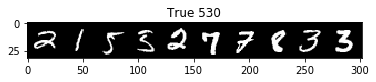

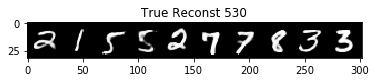

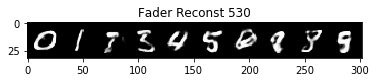


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 531 Fader Loss: -54.8350 | Adv Loss: 2.2961 | Rec Loss: 59.9691 
	| Adj Disc Loss: 344.4365 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 532 Fader Loss: -54.8688 | Adv Loss: 2.2958 | Rec Loss: 59.9234 
	| Adj Disc Loss: 344.4529 | Disc Acc: 0.1198


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 533 Fader Loss: -54.8839 | Adv Loss: 2.2963 | Rec Loss: 59.9332 
	| Adj Disc Loss: 344.5165 | Disc Acc: 0.1170


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 534 Fader Loss: -54.8763 | Adv Loss: 2.2965 | Rec Loss: 59.9476 
	| Adj Disc Loss: 344.4312 | Disc Acc: 0.1250


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 535 Fader Loss: -54.8676 | Adv Loss: 2.2967 | Rec Loss: 59.9664 
	| Adj Disc Loss: 344.5002 | Disc Acc: 0.1212


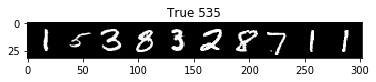

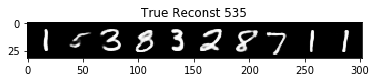

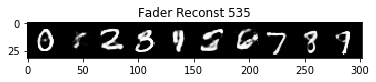


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 536 Fader Loss: -54.8858 | Adv Loss: 2.2960 | Rec Loss: 59.9152 
	| Adj Disc Loss: 344.4511 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 537 Fader Loss: -54.9193 | Adv Loss: 2.2971 | Rec Loss: 59.9370 
	| Adj Disc Loss: 344.5147 | Disc Acc: 0.1199


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 538 Fader Loss: -54.9031 | Adv Loss: 2.2964 | Rec Loss: 59.9173 
	| Adj Disc Loss: 344.4997 | Disc Acc: 0.1179


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 539 Fader Loss: -54.8917 | Adv Loss: 2.2965 | Rec Loss: 59.9350 
	| Adj Disc Loss: 344.5786 | Disc Acc: 0.1216


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 540 Fader Loss: -54.9354 | Adv Loss: 2.2966 | Rec Loss: 59.8933 
	| Adj Disc Loss: 344.5001 | Disc Acc: 0.1195


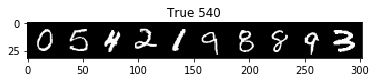

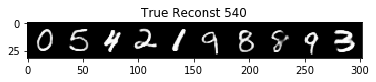

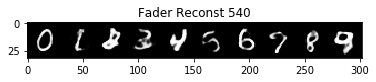


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 541 Fader Loss: -54.8714 | Adv Loss: 2.2956 | Rec Loss: 59.9108 
	| Adj Disc Loss: 344.4722 | Disc Acc: 0.1167


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 542 Fader Loss: -54.8977 | Adv Loss: 2.2955 | Rec Loss: 59.8758 
	| Adj Disc Loss: 344.4368 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 543 Fader Loss: -54.8749 | Adv Loss: 2.2954 | Rec Loss: 59.8943 
	| Adj Disc Loss: 344.3717 | Disc Acc: 0.1191


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 544 Fader Loss: -54.8448 | Adv Loss: 2.2958 | Rec Loss: 59.9452 
	| Adj Disc Loss: 344.3928 | Disc Acc: 0.1200


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 545 Fader Loss: -54.8444 | Adv Loss: 2.2963 | Rec Loss: 59.9727 
	| Adj Disc Loss: 344.5007 | Disc Acc: 0.1198


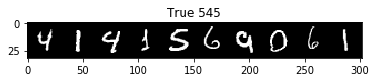

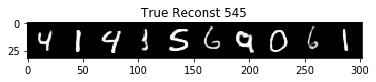

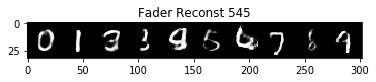


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 546 Fader Loss: -54.8497 | Adv Loss: 2.2959 | Rec Loss: 59.9433 
	| Adj Disc Loss: 344.4828 | Disc Acc: 0.1188


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 547 Fader Loss: -54.8655 | Adv Loss: 2.2957 | Rec Loss: 59.9171 
	| Adj Disc Loss: 344.4445 | Disc Acc: 0.1217


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 548 Fader Loss: -54.9083 | Adv Loss: 2.2963 | Rec Loss: 59.9057 
	| Adj Disc Loss: 344.4968 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 549 Fader Loss: -54.9428 | Adv Loss: 2.2969 | Rec Loss: 59.9041 
	| Adj Disc Loss: 344.5066 | Disc Acc: 0.1171


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 550 Fader Loss: -54.9361 | Adv Loss: 2.2964 | Rec Loss: 59.8863 
	| Adj Disc Loss: 344.4987 | Disc Acc: 0.1221


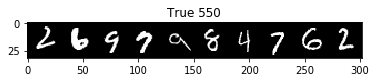

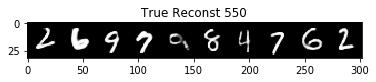

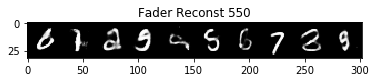


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 551 Fader Loss: -54.9292 | Adv Loss: 2.2970 | Rec Loss: 59.9205 
	| Adj Disc Loss: 344.6001 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 552 Fader Loss: -54.9418 | Adv Loss: 2.2962 | Rec Loss: 59.8677 
	| Adj Disc Loss: 344.4797 | Disc Acc: 0.1218


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 553 Fader Loss: -54.9487 | Adv Loss: 2.2962 | Rec Loss: 59.8600 
	| Adj Disc Loss: 344.4720 | Disc Acc: 0.1214


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 554 Fader Loss: -54.9491 | Adv Loss: 2.2964 | Rec Loss: 59.8696 
	| Adj Disc Loss: 344.4949 | Disc Acc: 0.1216


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 555 Fader Loss: -54.9497 | Adv Loss: 2.2968 | Rec Loss: 59.8908 
	| Adj Disc Loss: 344.5111 | Disc Acc: 0.1240


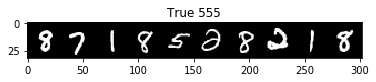

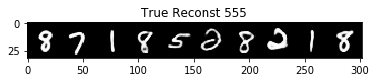

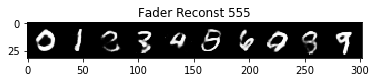


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 556 Fader Loss: -54.9318 | Adv Loss: 2.2962 | Rec Loss: 59.8785 
	| Adj Disc Loss: 344.4917 | Disc Acc: 0.1196


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 557 Fader Loss: -54.9512 | Adv Loss: 2.2962 | Rec Loss: 59.8610 
	| Adj Disc Loss: 344.5419 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 558 Fader Loss: -54.9640 | Adv Loss: 2.2967 | Rec Loss: 59.8723 
	| Adj Disc Loss: 344.5759 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 559 Fader Loss: -54.9314 | Adv Loss: 2.2959 | Rec Loss: 59.8623 
	| Adj Disc Loss: 344.5741 | Disc Acc: 0.1170


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 560 Fader Loss: -55.0040 | Adv Loss: 2.2971 | Rec Loss: 59.8533 
	| Adj Disc Loss: 344.5334 | Disc Acc: 0.1179


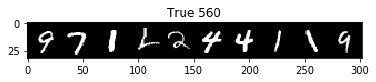

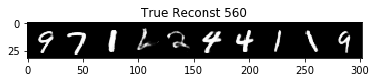

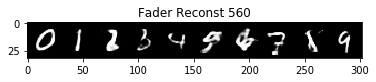


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 561 Fader Loss: -54.9964 | Adv Loss: 2.2971 | Rec Loss: 59.8604 
	| Adj Disc Loss: 344.5680 | Disc Acc: 0.1208


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 562 Fader Loss: -54.9725 | Adv Loss: 2.2965 | Rec Loss: 59.8530 
	| Adj Disc Loss: 344.5201 | Disc Acc: 0.1206


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 563 Fader Loss: -54.9752 | Adv Loss: 2.2971 | Rec Loss: 59.8792 
	| Adj Disc Loss: 344.5511 | Disc Acc: 0.1199


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 564 Fader Loss: -55.0039 | Adv Loss: 2.2976 | Rec Loss: 59.8773 
	| Adj Disc Loss: 344.6044 | Disc Acc: 0.1179


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 565 Fader Loss: -55.0065 | Adv Loss: 2.2977 | Rec Loss: 59.8808 
	| Adj Disc Loss: 344.6488 | Disc Acc: 0.1173


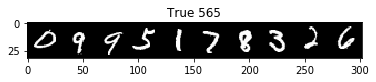

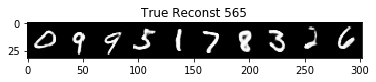

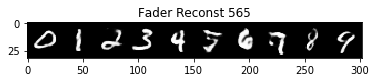


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 566 Fader Loss: -55.0111 | Adv Loss: 2.2973 | Rec Loss: 59.8533 
	| Adj Disc Loss: 344.6970 | Disc Acc: 0.1175


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 567 Fader Loss: -55.0349 | Adv Loss: 2.2973 | Rec Loss: 59.8321 
	| Adj Disc Loss: 344.5938 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 568 Fader Loss: -55.0306 | Adv Loss: 2.2969 | Rec Loss: 59.8152 
	| Adj Disc Loss: 344.5959 | Disc Acc: 0.1190


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 569 Fader Loss: -54.9969 | Adv Loss: 2.2968 | Rec Loss: 59.8427 
	| Adj Disc Loss: 344.6301 | Disc Acc: 0.1166


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 570 Fader Loss: -55.0532 | Adv Loss: 2.2974 | Rec Loss: 59.8159 
	| Adj Disc Loss: 344.6378 | Disc Acc: 0.1167


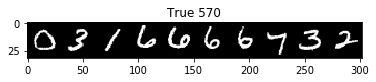

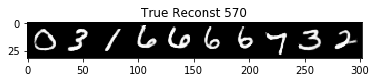

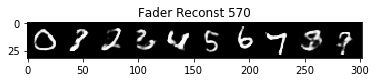


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 571 Fader Loss: -55.0175 | Adv Loss: 2.2972 | Rec Loss: 59.8415 
	| Adj Disc Loss: 344.6942 | Disc Acc: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 572 Fader Loss: -55.0172 | Adv Loss: 2.2973 | Rec Loss: 59.8496 
	| Adj Disc Loss: 344.7209 | Disc Acc: 0.1147


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 573 Fader Loss: -55.0485 | Adv Loss: 2.2969 | Rec Loss: 59.7941 
	| Adj Disc Loss: 344.5781 | Disc Acc: 0.1158


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 574 Fader Loss: -55.0701 | Adv Loss: 2.2973 | Rec Loss: 59.7954 
	| Adj Disc Loss: 344.5990 | Disc Acc: 0.1197


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 575 Fader Loss: -55.0779 | Adv Loss: 2.2970 | Rec Loss: 59.7710 
	| Adj Disc Loss: 344.5495 | Disc Acc: 0.1189


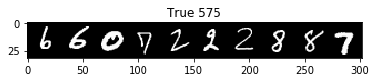

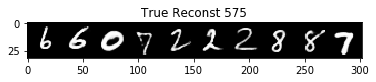

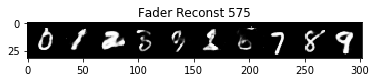


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 576 Fader Loss: -55.0441 | Adv Loss: 2.2966 | Rec Loss: 59.7874 
	| Adj Disc Loss: 344.5807 | Disc Acc: 0.1206


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 577 Fader Loss: -55.0623 | Adv Loss: 2.2965 | Rec Loss: 59.7647 
	| Adj Disc Loss: 344.6255 | Disc Acc: 0.1183


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 578 Fader Loss: -55.0780 | Adv Loss: 2.2966 | Rec Loss: 59.7534 
	| Adj Disc Loss: 344.5576 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 579 Fader Loss: -55.0705 | Adv Loss: 2.2968 | Rec Loss: 59.7691 
	| Adj Disc Loss: 344.5918 | Disc Acc: 0.1161


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 580 Fader Loss: -55.1183 | Adv Loss: 2.2974 | Rec Loss: 59.7515 
	| Adj Disc Loss: 344.6266 | Disc Acc: 0.1200


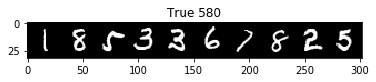

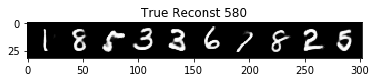

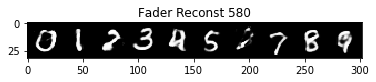


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 581 Fader Loss: -55.1151 | Adv Loss: 2.2966 | Rec Loss: 59.7132 
	| Adj Disc Loss: 344.5283 | Disc Acc: 0.1150


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 582 Fader Loss: -55.1174 | Adv Loss: 2.2965 | Rec Loss: 59.7073 
	| Adj Disc Loss: 344.5012 | Disc Acc: 0.1148


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 583 Fader Loss: -55.0840 | Adv Loss: 2.2967 | Rec Loss: 59.7492 
	| Adj Disc Loss: 344.4708 | Disc Acc: 0.1205


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 584 Fader Loss: -55.0507 | Adv Loss: 2.2964 | Rec Loss: 59.7703 
	| Adj Disc Loss: 344.4887 | Disc Acc: 0.1208


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 585 Fader Loss: -55.0573 | Adv Loss: 2.2962 | Rec Loss: 59.7543 
	| Adj Disc Loss: 344.4647 | Disc Acc: 0.1195


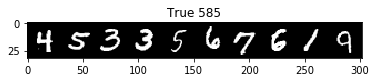

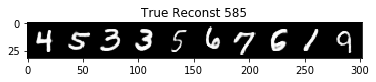

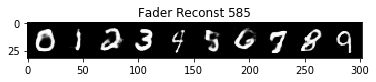


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 586 Fader Loss: -55.0436 | Adv Loss: 2.2966 | Rec Loss: 59.7870 
	| Adj Disc Loss: 344.5282 | Disc Acc: 0.1180


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 587 Fader Loss: -55.0384 | Adv Loss: 2.2960 | Rec Loss: 59.7613 
	| Adj Disc Loss: 344.4782 | Disc Acc: 0.1221


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 588 Fader Loss: -55.0747 | Adv Loss: 2.2964 | Rec Loss: 59.7461 
	| Adj Disc Loss: 344.4614 | Disc Acc: 0.1199


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 589 Fader Loss: -55.0372 | Adv Loss: 2.2954 | Rec Loss: 59.7307 
	| Adj Disc Loss: 344.4791 | Disc Acc: 0.1191


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 590 Fader Loss: -55.0777 | Adv Loss: 2.2960 | Rec Loss: 59.7212 
	| Adj Disc Loss: 344.4121 | Disc Acc: 0.1206


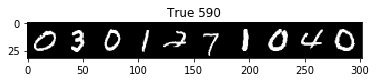

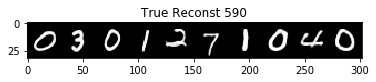

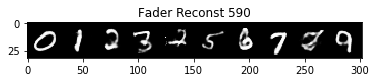


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 591 Fader Loss: -55.0617 | Adv Loss: 2.2964 | Rec Loss: 59.7600 
	| Adj Disc Loss: 344.4933 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 592 Fader Loss: -55.0480 | Adv Loss: 2.2959 | Rec Loss: 59.7464 
	| Adj Disc Loss: 344.4454 | Disc Acc: 0.1225


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 593 Fader Loss: -55.0802 | Adv Loss: 2.2962 | Rec Loss: 59.7322 
	| Adj Disc Loss: 344.4394 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 594 Fader Loss: -55.0347 | Adv Loss: 2.2958 | Rec Loss: 59.7544 
	| Adj Disc Loss: 344.4561 | Disc Acc: 0.1223


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 595 Fader Loss: -55.0417 | Adv Loss: 2.2957 | Rec Loss: 59.7456 
	| Adj Disc Loss: 344.3873 | Disc Acc: 0.1231


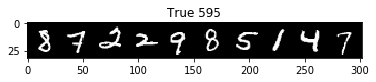

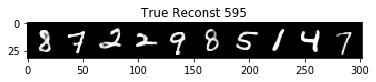

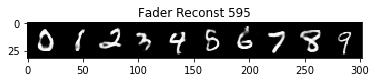


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 596 Fader Loss: -55.0408 | Adv Loss: 2.2960 | Rec Loss: 59.7582 
	| Adj Disc Loss: 344.4683 | Disc Acc: 0.1218


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 597 Fader Loss: -55.0477 | Adv Loss: 2.2967 | Rec Loss: 59.7851 
	| Adj Disc Loss: 344.5495 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 598 Fader Loss: -55.0738 | Adv Loss: 2.2965 | Rec Loss: 59.7509 
	| Adj Disc Loss: 344.5078 | Disc Acc: 0.1231


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 599 Fader Loss: -55.0935 | Adv Loss: 2.2966 | Rec Loss: 59.7385 
	| Adj Disc Loss: 344.5730 | Disc Acc: 0.1191


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 600 Fader Loss: -55.0906 | Adv Loss: 2.2966 | Rec Loss: 59.7373 
	| Adj Disc Loss: 344.5052 | Disc Acc: 0.1179


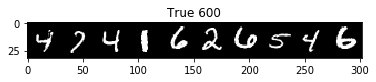

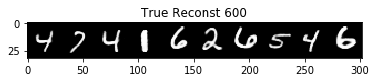

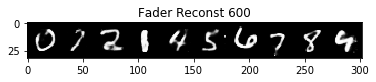


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 601 Fader Loss: -55.0920 | Adv Loss: 2.2965 | Rec Loss: 59.7310 
	| Adj Disc Loss: 344.4893 | Disc Acc: 0.1195


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 602 Fader Loss: -55.0894 | Adv Loss: 2.2960 | Rec Loss: 59.7100 
	| Adj Disc Loss: 344.4275 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 603 Fader Loss: -55.0604 | Adv Loss: 2.2961 | Rec Loss: 59.7470 
	| Adj Disc Loss: 344.4906 | Disc Acc: 0.1166


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 604 Fader Loss: -55.0780 | Adv Loss: 2.2961 | Rec Loss: 59.7285 
	| Adj Disc Loss: 344.4005 | Disc Acc: 0.1190


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 605 Fader Loss: -55.0768 | Adv Loss: 2.2959 | Rec Loss: 59.7203 
	| Adj Disc Loss: 344.4351 | Disc Acc: 0.1169


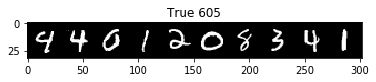

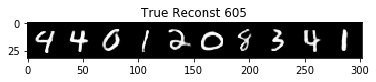

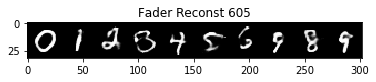


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 606 Fader Loss: -55.0302 | Adv Loss: 2.2950 | Rec Loss: 59.7179 
	| Adj Disc Loss: 344.3469 | Disc Acc: 0.1244


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 607 Fader Loss: -55.0643 | Adv Loss: 2.2964 | Rec Loss: 59.7581 
	| Adj Disc Loss: 344.4930 | Disc Acc: 0.1203


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 608 Fader Loss: -55.0688 | Adv Loss: 2.2959 | Rec Loss: 59.7276 
	| Adj Disc Loss: 344.3854 | Disc Acc: 0.1210


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 609 Fader Loss: -55.0946 | Adv Loss: 2.2963 | Rec Loss: 59.7206 
	| Adj Disc Loss: 344.5072 | Disc Acc: 0.1216


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 610 Fader Loss: -55.1295 | Adv Loss: 2.2968 | Rec Loss: 59.7108 
	| Adj Disc Loss: 344.4570 | Disc Acc: 0.1202


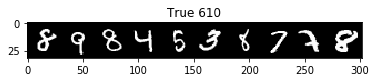

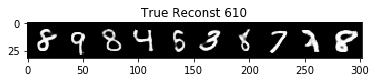

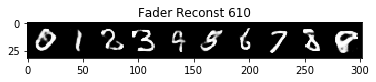


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 611 Fader Loss: -55.0828 | Adv Loss: 2.2957 | Rec Loss: 59.7017 
	| Adj Disc Loss: 344.5104 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 612 Fader Loss: -55.0992 | Adv Loss: 2.2956 | Rec Loss: 59.6786 
	| Adj Disc Loss: 344.4000 | Disc Acc: 0.1221


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 613 Fader Loss: -55.1210 | Adv Loss: 2.2957 | Rec Loss: 59.6660 
	| Adj Disc Loss: 344.4390 | Disc Acc: 0.1216


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 614 Fader Loss: -55.1329 | Adv Loss: 2.2960 | Rec Loss: 59.6681 
	| Adj Disc Loss: 344.4193 | Disc Acc: 0.1214


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 615 Fader Loss: -55.0926 | Adv Loss: 2.2953 | Rec Loss: 59.6723 
	| Adj Disc Loss: 344.4019 | Disc Acc: 0.1222


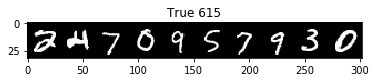

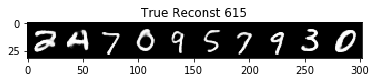

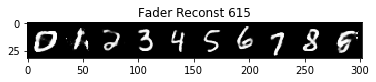


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 616 Fader Loss: -55.1187 | Adv Loss: 2.2955 | Rec Loss: 59.6539 
	| Adj Disc Loss: 344.3787 | Disc Acc: 0.1220


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 617 Fader Loss: -55.0770 | Adv Loss: 2.2948 | Rec Loss: 59.6642 
	| Adj Disc Loss: 344.2838 | Disc Acc: 0.1222


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 618 Fader Loss: -55.0615 | Adv Loss: 2.2949 | Rec Loss: 59.6859 
	| Adj Disc Loss: 344.3374 | Disc Acc: 0.1248


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 619 Fader Loss: -55.0591 | Adv Loss: 2.2956 | Rec Loss: 59.7224 
	| Adj Disc Loss: 344.4190 | Disc Acc: 0.1216


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 620 Fader Loss: -55.0784 | Adv Loss: 2.2960 | Rec Loss: 59.7234 
	| Adj Disc Loss: 344.4574 | Disc Acc: 0.1191


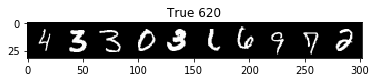

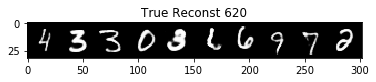

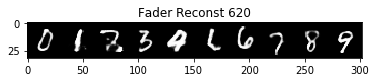


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 621 Fader Loss: -55.1002 | Adv Loss: 2.2960 | Rec Loss: 59.6980 
	| Adj Disc Loss: 344.4850 | Disc Acc: 0.1228


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 622 Fader Loss: -55.1010 | Adv Loss: 2.2952 | Rec Loss: 59.6598 
	| Adj Disc Loss: 344.3577 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 623 Fader Loss: -55.1154 | Adv Loss: 2.2953 | Rec Loss: 59.6506 
	| Adj Disc Loss: 344.3906 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 624 Fader Loss: -55.1478 | Adv Loss: 2.2957 | Rec Loss: 59.6389 
	| Adj Disc Loss: 344.3609 | Disc Acc: 0.1217


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 625 Fader Loss: -55.1273 | Adv Loss: 2.2961 | Rec Loss: 59.6755 
	| Adj Disc Loss: 344.4641 | Disc Acc: 0.1189


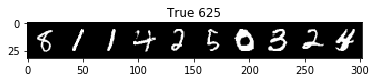

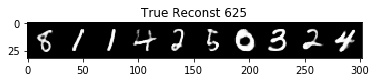

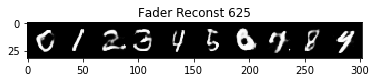


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 626 Fader Loss: -55.1413 | Adv Loss: 2.2959 | Rec Loss: 59.6517 
	| Adj Disc Loss: 344.3842 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 627 Fader Loss: -55.1351 | Adv Loss: 2.2959 | Rec Loss: 59.6589 
	| Adj Disc Loss: 344.5280 | Disc Acc: 0.1165


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 628 Fader Loss: -55.1654 | Adv Loss: 2.2965 | Rec Loss: 59.6600 
	| Adj Disc Loss: 344.5101 | Disc Acc: 0.1168


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 629 Fader Loss: -55.1980 | Adv Loss: 2.2966 | Rec Loss: 59.6321 
	| Adj Disc Loss: 344.5192 | Disc Acc: 0.1169


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 630 Fader Loss: -55.1884 | Adv Loss: 2.2963 | Rec Loss: 59.6271 
	| Adj Disc Loss: 344.4700 | Disc Acc: 0.1182


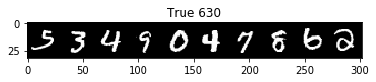

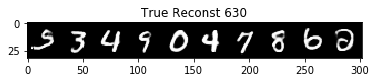

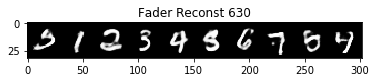


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 631 Fader Loss: -55.1497 | Adv Loss: 2.2961 | Rec Loss: 59.6541 
	| Adj Disc Loss: 344.4656 | Disc Acc: 0.1208


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 632 Fader Loss: -55.2028 | Adv Loss: 2.2969 | Rec Loss: 59.6414 
	| Adj Disc Loss: 344.5712 | Disc Acc: 0.1176


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 633 Fader Loss: -55.2034 | Adv Loss: 2.2964 | Rec Loss: 59.6180 
	| Adj Disc Loss: 344.5050 | Disc Acc: 0.1178


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 634 Fader Loss: -55.2032 | Adv Loss: 2.2967 | Rec Loss: 59.6314 
	| Adj Disc Loss: 344.4908 | Disc Acc: 0.1187


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 635 Fader Loss: -55.1969 | Adv Loss: 2.2969 | Rec Loss: 59.6459 
	| Adj Disc Loss: 344.6812 | Disc Acc: 0.1097


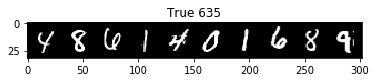

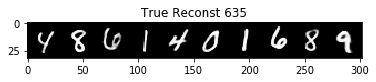

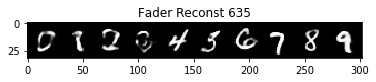


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 636 Fader Loss: -55.2430 | Adv Loss: 2.2968 | Rec Loss: 59.5988 
	| Adj Disc Loss: 344.5504 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 637 Fader Loss: -55.2376 | Adv Loss: 2.2971 | Rec Loss: 59.6154 
	| Adj Disc Loss: 344.5861 | Disc Acc: 0.1159


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 638 Fader Loss: -55.2655 | Adv Loss: 2.2975 | Rec Loss: 59.6104 
	| Adj Disc Loss: 344.6334 | Disc Acc: 0.1194


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 639 Fader Loss: -55.1911 | Adv Loss: 2.2967 | Rec Loss: 59.6441 
	| Adj Disc Loss: 344.6211 | Disc Acc: 0.1227


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 640 Fader Loss: -55.2436 | Adv Loss: 2.2977 | Rec Loss: 59.6431 
	| Adj Disc Loss: 344.7168 | Disc Acc: 0.1164


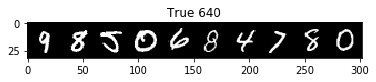

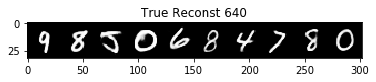

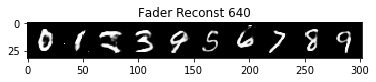


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 641 Fader Loss: -55.2905 | Adv Loss: 2.2982 | Rec Loss: 59.6172 
	| Adj Disc Loss: 344.7727 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 642 Fader Loss: -55.2508 | Adv Loss: 2.2970 | Rec Loss: 59.5995 
	| Adj Disc Loss: 344.6590 | Disc Acc: 0.1167


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 643 Fader Loss: -55.2378 | Adv Loss: 2.2968 | Rec Loss: 59.6024 
	| Adj Disc Loss: 344.6280 | Disc Acc: 0.1178


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 644 Fader Loss: -55.2703 | Adv Loss: 2.2973 | Rec Loss: 59.5951 
	| Adj Disc Loss: 344.6353 | Disc Acc: 0.1203


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 645 Fader Loss: -55.2642 | Adv Loss: 2.2985 | Rec Loss: 59.6600 
	| Adj Disc Loss: 344.9041 | Disc Acc: 0.1113


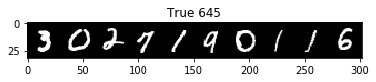

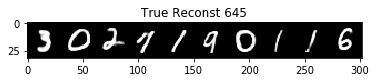

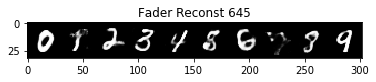


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 646 Fader Loss: -55.3266 | Adv Loss: 2.2978 | Rec Loss: 59.5622 
	| Adj Disc Loss: 344.6579 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 647 Fader Loss: -55.2761 | Adv Loss: 2.2972 | Rec Loss: 59.5827 
	| Adj Disc Loss: 344.6361 | Disc Acc: 0.1167


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 648 Fader Loss: -55.2797 | Adv Loss: 2.2968 | Rec Loss: 59.5617 
	| Adj Disc Loss: 344.5492 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 649 Fader Loss: -55.2577 | Adv Loss: 2.2973 | Rec Loss: 59.6077 
	| Adj Disc Loss: 344.6043 | Disc Acc: 0.1176


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 650 Fader Loss: -55.2741 | Adv Loss: 2.2964 | Rec Loss: 59.5473 
	| Adj Disc Loss: 344.5377 | Disc Acc: 0.1194


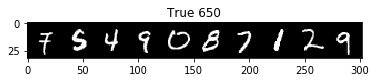

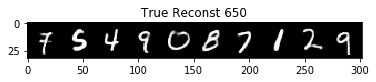

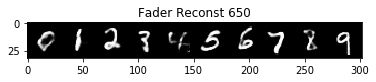


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 651 Fader Loss: -55.2843 | Adv Loss: 2.2966 | Rec Loss: 59.5448 
	| Adj Disc Loss: 344.5311 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 652 Fader Loss: -55.2853 | Adv Loss: 2.2969 | Rec Loss: 59.5588 
	| Adj Disc Loss: 344.4859 | Disc Acc: 0.1160


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 653 Fader Loss: -55.2568 | Adv Loss: 2.2962 | Rec Loss: 59.5514 
	| Adj Disc Loss: 344.4674 | Disc Acc: 0.1156


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 654 Fader Loss: -55.2456 | Adv Loss: 2.2958 | Rec Loss: 59.5443 
	| Adj Disc Loss: 344.4660 | Disc Acc: 0.1149


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 655 Fader Loss: -55.2066 | Adv Loss: 2.2951 | Rec Loss: 59.5507 
	| Adj Disc Loss: 344.3697 | Disc Acc: 0.1182


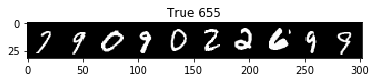

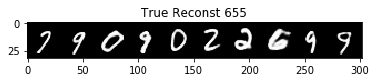

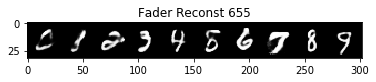


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 656 Fader Loss: -55.1980 | Adv Loss: 2.2958 | Rec Loss: 59.5898 
	| Adj Disc Loss: 344.4229 | Disc Acc: 0.1190


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 657 Fader Loss: -55.2134 | Adv Loss: 2.2964 | Rec Loss: 59.6091 
	| Adj Disc Loss: 344.4319 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 658 Fader Loss: -55.2116 | Adv Loss: 2.2958 | Rec Loss: 59.5768 
	| Adj Disc Loss: 344.3610 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 659 Fader Loss: -55.1919 | Adv Loss: 2.2954 | Rec Loss: 59.5759 
	| Adj Disc Loss: 344.3929 | Disc Acc: 0.1195


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 660 Fader Loss: -55.2110 | Adv Loss: 2.2957 | Rec Loss: 59.5752 
	| Adj Disc Loss: 344.4038 | Disc Acc: 0.1164


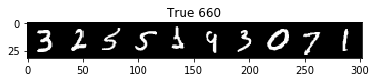

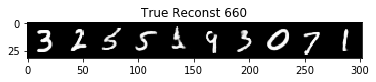

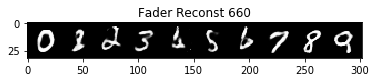


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 661 Fader Loss: -55.2246 | Adv Loss: 2.2952 | Rec Loss: 59.5367 
	| Adj Disc Loss: 344.3734 | Disc Acc: 0.1187


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 662 Fader Loss: -55.2047 | Adv Loss: 2.2951 | Rec Loss: 59.5479 
	| Adj Disc Loss: 344.2736 | Disc Acc: 0.1196


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 663 Fader Loss: -55.2225 | Adv Loss: 2.2954 | Rec Loss: 59.5464 
	| Adj Disc Loss: 344.3074 | Disc Acc: 0.1197


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 664 Fader Loss: -55.1895 | Adv Loss: 2.2954 | Rec Loss: 59.5815 
	| Adj Disc Loss: 344.4450 | Disc Acc: 0.1218


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 665 Fader Loss: -55.2375 | Adv Loss: 2.2959 | Rec Loss: 59.5568 
	| Adj Disc Loss: 344.3824 | Disc Acc: 0.1185


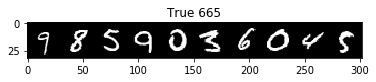

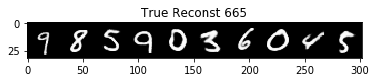

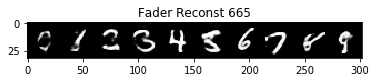


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 666 Fader Loss: -55.2429 | Adv Loss: 2.2956 | Rec Loss: 59.5354 
	| Adj Disc Loss: 344.3800 | Disc Acc: 0.1197


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 667 Fader Loss: -55.2479 | Adv Loss: 2.2957 | Rec Loss: 59.5352 
	| Adj Disc Loss: 344.3562 | Disc Acc: 0.1222


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 668 Fader Loss: -55.2119 | Adv Loss: 2.2951 | Rec Loss: 59.5425 
	| Adj Disc Loss: 344.3714 | Disc Acc: 0.1198


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 669 Fader Loss: -55.2135 | Adv Loss: 2.2954 | Rec Loss: 59.5574 
	| Adj Disc Loss: 344.3949 | Disc Acc: 0.1182


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 670 Fader Loss: -55.2352 | Adv Loss: 2.2953 | Rec Loss: 59.5299 
	| Adj Disc Loss: 344.4065 | Disc Acc: 0.1210


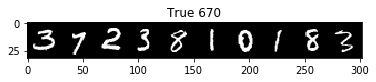

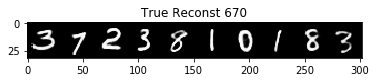

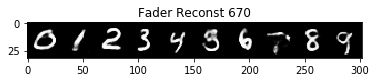


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 671 Fader Loss: -55.2595 | Adv Loss: 2.2955 | Rec Loss: 59.5141 
	| Adj Disc Loss: 344.3150 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 672 Fader Loss: -55.2407 | Adv Loss: 2.2956 | Rec Loss: 59.5389 
	| Adj Disc Loss: 344.4062 | Disc Acc: 0.1202


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 673 Fader Loss: -55.2345 | Adv Loss: 2.2959 | Rec Loss: 59.5595 
	| Adj Disc Loss: 344.4583 | Disc Acc: 0.1148


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 674 Fader Loss: -55.2444 | Adv Loss: 2.2955 | Rec Loss: 59.5298 
	| Adj Disc Loss: 344.4375 | Disc Acc: 0.1183


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 675 Fader Loss: -55.2498 | Adv Loss: 2.2964 | Rec Loss: 59.5697 
	| Adj Disc Loss: 344.4176 | Disc Acc: 0.1165


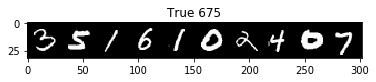

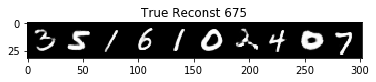

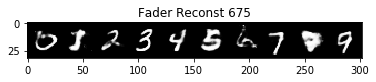


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 676 Fader Loss: -55.2676 | Adv Loss: 2.2959 | Rec Loss: 59.5281 
	| Adj Disc Loss: 344.4035 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 677 Fader Loss: -55.2613 | Adv Loss: 2.2963 | Rec Loss: 59.5534 
	| Adj Disc Loss: 344.4396 | Disc Acc: 0.1190


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 678 Fader Loss: -55.2408 | Adv Loss: 2.2959 | Rec Loss: 59.5554 
	| Adj Disc Loss: 344.5353 | Disc Acc: 0.1149


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 679 Fader Loss: -55.3069 | Adv Loss: 2.2966 | Rec Loss: 59.5251 
	| Adj Disc Loss: 344.4545 | Disc Acc: 0.1187


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 680 Fader Loss: -55.2723 | Adv Loss: 2.2958 | Rec Loss: 59.5170 
	| Adj Disc Loss: 344.4541 | Disc Acc: 0.1176


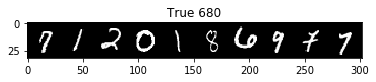

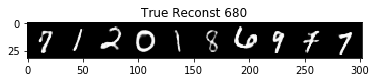

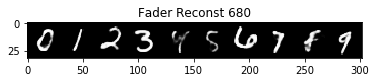


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 681 Fader Loss: -55.2864 | Adv Loss: 2.2960 | Rec Loss: 59.5136 
	| Adj Disc Loss: 344.4214 | Disc Acc: 0.1162


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 682 Fader Loss: -55.2438 | Adv Loss: 2.2955 | Rec Loss: 59.5290 
	| Adj Disc Loss: 344.3918 | Disc Acc: 0.1177


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 683 Fader Loss: -55.2572 | Adv Loss: 2.2957 | Rec Loss: 59.5296 
	| Adj Disc Loss: 344.4010 | Disc Acc: 0.1187


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 684 Fader Loss: -55.2309 | Adv Loss: 2.2954 | Rec Loss: 59.5397 
	| Adj Disc Loss: 344.4321 | Disc Acc: 0.1184


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 685 Fader Loss: -55.2467 | Adv Loss: 2.2958 | Rec Loss: 59.5448 
	| Adj Disc Loss: 344.3577 | Disc Acc: 0.1197


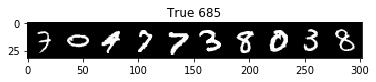

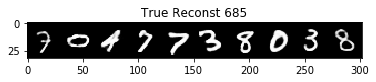

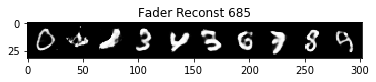


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 686 Fader Loss: -55.2443 | Adv Loss: 2.2960 | Rec Loss: 59.5582 
	| Adj Disc Loss: 344.4001 | Disc Acc: 0.1258


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 687 Fader Loss: -55.2720 | Adv Loss: 2.2966 | Rec Loss: 59.5594 
	| Adj Disc Loss: 344.5046 | Disc Acc: 0.1251


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 688 Fader Loss: -55.2723 | Adv Loss: 2.2967 | Rec Loss: 59.5609 
	| Adj Disc Loss: 344.5033 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 689 Fader Loss: -55.3260 | Adv Loss: 2.2965 | Rec Loss: 59.4987 
	| Adj Disc Loss: 344.4538 | Disc Acc: 0.1195


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 690 Fader Loss: -55.2800 | Adv Loss: 2.2962 | Rec Loss: 59.5280 
	| Adj Disc Loss: 344.4336 | Disc Acc: 0.1213


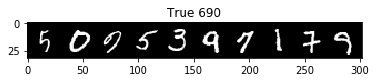

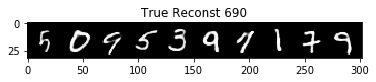

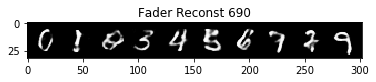


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 691 Fader Loss: -55.2908 | Adv Loss: 2.2961 | Rec Loss: 59.5143 
	| Adj Disc Loss: 344.4712 | Disc Acc: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 692 Fader Loss: -55.2950 | Adv Loss: 2.2960 | Rec Loss: 59.5052 
	| Adj Disc Loss: 344.4638 | Disc Acc: 0.1161


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 693 Fader Loss: -55.2940 | Adv Loss: 2.2959 | Rec Loss: 59.5003 
	| Adj Disc Loss: 344.4506 | Disc Acc: 0.1198


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 694 Fader Loss: -55.2888 | Adv Loss: 2.2956 | Rec Loss: 59.4896 
	| Adj Disc Loss: 344.3691 | Disc Acc: 0.1212


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 695 Fader Loss: -55.3121 | Adv Loss: 2.2958 | Rec Loss: 59.4778 
	| Adj Disc Loss: 344.3768 | Disc Acc: 0.1174


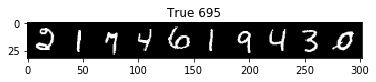

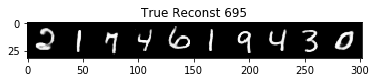

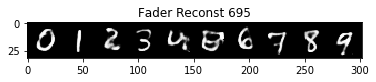


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 696 Fader Loss: -55.2952 | Adv Loss: 2.2956 | Rec Loss: 59.4866 
	| Adj Disc Loss: 344.3588 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 697 Fader Loss: -55.3252 | Adv Loss: 2.2961 | Rec Loss: 59.4803 
	| Adj Disc Loss: 344.4484 | Disc Acc: 0.1169


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 698 Fader Loss: -55.3255 | Adv Loss: 2.2961 | Rec Loss: 59.4808 
	| Adj Disc Loss: 344.4352 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 699 Fader Loss: -55.3299 | Adv Loss: 2.2958 | Rec Loss: 59.4626 
	| Adj Disc Loss: 344.3886 | Disc Acc: 0.1191


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 700 Fader Loss: -55.3236 | Adv Loss: 2.2962 | Rec Loss: 59.4845 
	| Adj Disc Loss: 344.4332 | Disc Acc: 0.1190


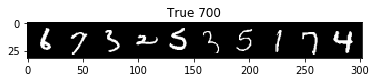

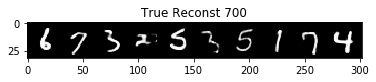

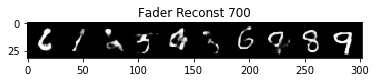


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 701 Fader Loss: -55.3211 | Adv Loss: 2.2962 | Rec Loss: 59.4886 
	| Adj Disc Loss: 344.4997 | Disc Acc: 0.1191


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 702 Fader Loss: -55.3520 | Adv Loss: 2.2964 | Rec Loss: 59.4681 
	| Adj Disc Loss: 344.5091 | Disc Acc: 0.1171


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 703 Fader Loss: -55.3483 | Adv Loss: 2.2962 | Rec Loss: 59.4632 
	| Adj Disc Loss: 344.4753 | Disc Acc: 0.1194


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 704 Fader Loss: -55.3542 | Adv Loss: 2.2970 | Rec Loss: 59.4979 
	| Adj Disc Loss: 344.5187 | Disc Acc: 0.1190


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 705 Fader Loss: -55.3028 | Adv Loss: 2.2961 | Rec Loss: 59.5001 
	| Adj Disc Loss: 344.4993 | Disc Acc: 0.1177


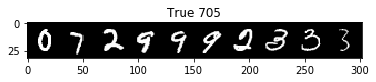

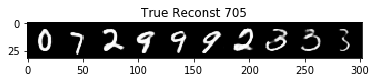

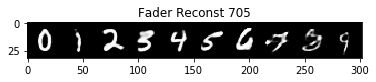


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 706 Fader Loss: -55.3441 | Adv Loss: 2.2960 | Rec Loss: 59.4583 
	| Adj Disc Loss: 344.5003 | Disc Acc: 0.1172


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 707 Fader Loss: -55.3690 | Adv Loss: 2.2966 | Rec Loss: 59.4605 
	| Adj Disc Loss: 344.4361 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 708 Fader Loss: -55.3294 | Adv Loss: 2.2967 | Rec Loss: 59.5032 
	| Adj Disc Loss: 344.5436 | Disc Acc: 0.1220


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 709 Fader Loss: -55.3382 | Adv Loss: 2.2964 | Rec Loss: 59.4820 
	| Adj Disc Loss: 344.5268 | Disc Acc: 0.1213


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 710 Fader Loss: -55.3470 | Adv Loss: 2.2958 | Rec Loss: 59.4428 
	| Adj Disc Loss: 344.4473 | Disc Acc: 0.1203


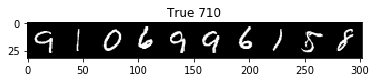

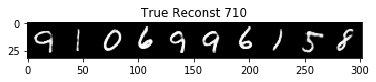

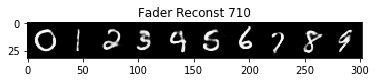


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 711 Fader Loss: -55.3405 | Adv Loss: 2.2959 | Rec Loss: 59.4528 
	| Adj Disc Loss: 344.4616 | Disc Acc: 0.1248


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 712 Fader Loss: -55.3453 | Adv Loss: 2.2962 | Rec Loss: 59.4671 
	| Adj Disc Loss: 344.5037 | Disc Acc: 0.1188


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 713 Fader Loss: -55.3629 | Adv Loss: 2.2963 | Rec Loss: 59.4522 
	| Adj Disc Loss: 344.5066 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 714 Fader Loss: -55.4014 | Adv Loss: 2.2969 | Rec Loss: 59.4433 
	| Adj Disc Loss: 344.4287 | Disc Acc: 0.1227


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 715 Fader Loss: -55.3550 | Adv Loss: 2.2963 | Rec Loss: 59.4602 
	| Adj Disc Loss: 344.4863 | Disc Acc: 0.1205


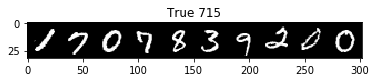

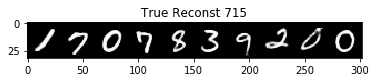

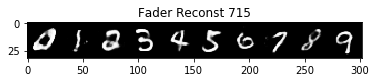


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 716 Fader Loss: -55.3442 | Adv Loss: 2.2959 | Rec Loss: 59.4509 
	| Adj Disc Loss: 344.4554 | Disc Acc: 0.1205


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 717 Fader Loss: -55.3756 | Adv Loss: 2.2966 | Rec Loss: 59.4522 
	| Adj Disc Loss: 344.4703 | Disc Acc: 0.1211


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 718 Fader Loss: -55.3816 | Adv Loss: 2.2964 | Rec Loss: 59.4397 
	| Adj Disc Loss: 344.5171 | Disc Acc: 0.1193


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 719 Fader Loss: -55.3698 | Adv Loss: 2.2960 | Rec Loss: 59.4325 
	| Adj Disc Loss: 344.5282 | Disc Acc: 0.1178


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 720 Fader Loss: -55.3651 | Adv Loss: 2.2962 | Rec Loss: 59.4462 
	| Adj Disc Loss: 344.5035 | Disc Acc: 0.1204


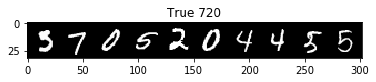

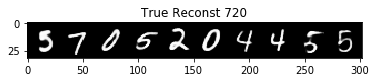

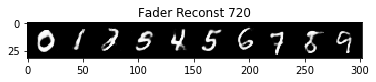


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 721 Fader Loss: -55.3697 | Adv Loss: 2.2973 | Rec Loss: 59.4975 
	| Adj Disc Loss: 344.6096 | Disc Acc: 0.1128


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 722 Fader Loss: -55.3820 | Adv Loss: 2.2966 | Rec Loss: 59.4465 
	| Adj Disc Loss: 344.5652 | Disc Acc: 0.1148


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 723 Fader Loss: -55.3986 | Adv Loss: 2.2962 | Rec Loss: 59.4122 
	| Adj Disc Loss: 344.4874 | Disc Acc: 0.1216


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 724 Fader Loss: -55.3934 | Adv Loss: 2.2961 | Rec Loss: 59.4136 
	| Adj Disc Loss: 344.4149 | Disc Acc: 0.1203


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 725 Fader Loss: -55.3618 | Adv Loss: 2.2959 | Rec Loss: 59.4340 
	| Adj Disc Loss: 344.4687 | Disc Acc: 0.1201


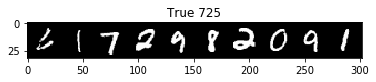

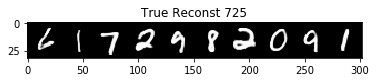

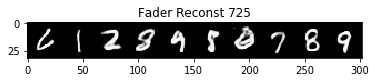


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 726 Fader Loss: -55.3951 | Adv Loss: 2.2964 | Rec Loss: 59.4243 
	| Adj Disc Loss: 344.4917 | Disc Acc: 0.1203


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 727 Fader Loss: -55.4211 | Adv Loss: 2.2969 | Rec Loss: 59.4254 
	| Adj Disc Loss: 344.4763 | Disc Acc: 0.1203


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 728 Fader Loss: -55.4200 | Adv Loss: 2.2967 | Rec Loss: 59.4134 
	| Adj Disc Loss: 344.4713 | Disc Acc: 0.1177


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 729 Fader Loss: -55.3798 | Adv Loss: 2.2965 | Rec Loss: 59.4464 
	| Adj Disc Loss: 344.5236 | Disc Acc: 0.1177


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 730 Fader Loss: -55.3943 | Adv Loss: 2.2961 | Rec Loss: 59.4123 
	| Adj Disc Loss: 344.5618 | Disc Acc: 0.1195


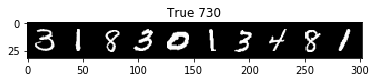

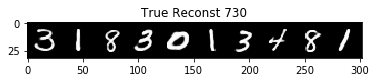

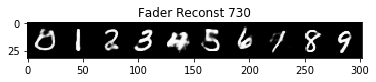


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 731 Fader Loss: -55.4362 | Adv Loss: 2.2971 | Rec Loss: 59.4191 
	| Adj Disc Loss: 344.5815 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 732 Fader Loss: -55.4142 | Adv Loss: 2.2967 | Rec Loss: 59.4195 
	| Adj Disc Loss: 344.5797 | Disc Acc: 0.1195


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 733 Fader Loss: -55.4060 | Adv Loss: 2.2968 | Rec Loss: 59.4323 
	| Adj Disc Loss: 344.6092 | Disc Acc: 0.1178


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 734 Fader Loss: -55.4171 | Adv Loss: 2.2968 | Rec Loss: 59.4218 
	| Adj Disc Loss: 344.5681 | Disc Acc: 0.1198


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 735 Fader Loss: -55.4328 | Adv Loss: 2.2970 | Rec Loss: 59.4157 
	| Adj Disc Loss: 344.6446 | Disc Acc: 0.1165


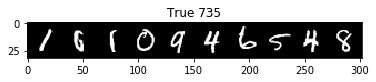

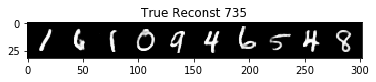

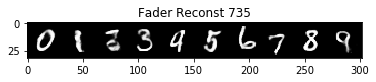


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 736 Fader Loss: -55.4303 | Adv Loss: 2.2969 | Rec Loss: 59.4145 
	| Adj Disc Loss: 344.5895 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 737 Fader Loss: -55.4351 | Adv Loss: 2.2969 | Rec Loss: 59.4098 
	| Adj Disc Loss: 344.6001 | Disc Acc: 0.1193


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 738 Fader Loss: -55.4299 | Adv Loss: 2.2976 | Rec Loss: 59.4491 
	| Adj Disc Loss: 344.6720 | Disc Acc: 0.1171


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 739 Fader Loss: -55.4300 | Adv Loss: 2.2975 | Rec Loss: 59.4465 
	| Adj Disc Loss: 344.6295 | Disc Acc: 0.1183


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 740 Fader Loss: -55.4382 | Adv Loss: 2.2973 | Rec Loss: 59.4274 
	| Adj Disc Loss: 344.6626 | Disc Acc: 0.1235


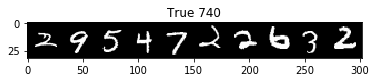

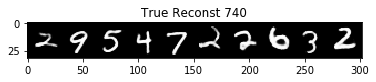

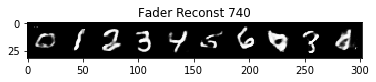


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 741 Fader Loss: -55.4200 | Adv Loss: 2.2966 | Rec Loss: 59.4106 
	| Adj Disc Loss: 344.5116 | Disc Acc: 0.1194


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 742 Fader Loss: -55.4294 | Adv Loss: 2.2968 | Rec Loss: 59.4103 
	| Adj Disc Loss: 344.6046 | Disc Acc: 0.1169


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 743 Fader Loss: -55.4465 | Adv Loss: 2.2972 | Rec Loss: 59.4156 
	| Adj Disc Loss: 344.6405 | Disc Acc: 0.1163


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 744 Fader Loss: -55.4710 | Adv Loss: 2.2971 | Rec Loss: 59.3848 
	| Adj Disc Loss: 344.5732 | Disc Acc: 0.1207


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 745 Fader Loss: -55.4659 | Adv Loss: 2.2972 | Rec Loss: 59.3941 
	| Adj Disc Loss: 344.6158 | Disc Acc: 0.1159


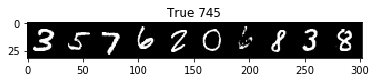

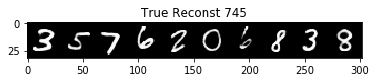

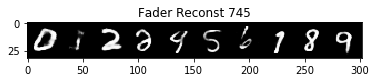


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 746 Fader Loss: -55.4688 | Adv Loss: 2.2972 | Rec Loss: 59.3918 
	| Adj Disc Loss: 344.5975 | Disc Acc: 0.1232


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 747 Fader Loss: -55.4786 | Adv Loss: 2.2978 | Rec Loss: 59.4098 
	| Adj Disc Loss: 344.7124 | Disc Acc: 0.1096


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 748 Fader Loss: -55.5246 | Adv Loss: 2.2976 | Rec Loss: 59.3536 
	| Adj Disc Loss: 344.6759 | Disc Acc: 0.1163


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 749 Fader Loss: -55.5032 | Adv Loss: 2.2967 | Rec Loss: 59.3312 
	| Adj Disc Loss: 344.5503 | Disc Acc: 0.1213


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 750 Fader Loss: -55.5002 | Adv Loss: 2.2965 | Rec Loss: 59.3223 
	| Adj Disc Loss: 344.5655 | Disc Acc: 0.1178


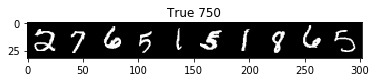

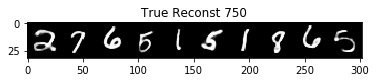

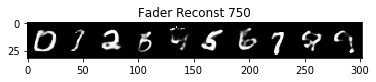


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 751 Fader Loss: -55.4832 | Adv Loss: 2.2964 | Rec Loss: 59.3344 
	| Adj Disc Loss: 344.4708 | Disc Acc: 0.1183


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 752 Fader Loss: -55.5170 | Adv Loss: 2.2968 | Rec Loss: 59.3220 
	| Adj Disc Loss: 344.5084 | Disc Acc: 0.1183


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 753 Fader Loss: -55.5340 | Adv Loss: 2.2972 | Rec Loss: 59.3277 
	| Adj Disc Loss: 344.5426 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 754 Fader Loss: -55.4745 | Adv Loss: 2.2961 | Rec Loss: 59.3288 
	| Adj Disc Loss: 344.5032 | Disc Acc: 0.1199


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 755 Fader Loss: -55.4909 | Adv Loss: 2.2963 | Rec Loss: 59.3259 
	| Adj Disc Loss: 344.5428 | Disc Acc: 0.1179


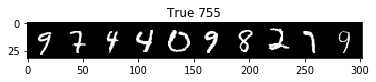

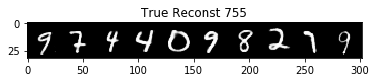

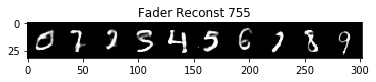


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 756 Fader Loss: -55.5168 | Adv Loss: 2.2967 | Rec Loss: 59.3167 
	| Adj Disc Loss: 344.5865 | Disc Acc: 0.1187


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 757 Fader Loss: -55.5164 | Adv Loss: 2.2963 | Rec Loss: 59.2979 
	| Adj Disc Loss: 344.4718 | Disc Acc: 0.1211


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 758 Fader Loss: -55.4913 | Adv Loss: 2.2960 | Rec Loss: 59.3068 
	| Adj Disc Loss: 344.4946 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 759 Fader Loss: -55.5125 | Adv Loss: 2.2963 | Rec Loss: 59.3033 
	| Adj Disc Loss: 344.5362 | Disc Acc: 0.1159


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 760 Fader Loss: -55.5490 | Adv Loss: 2.2970 | Rec Loss: 59.3009 
	| Adj Disc Loss: 344.5511 | Disc Acc: 0.1201


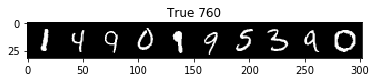

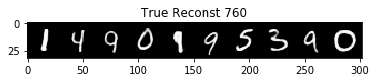

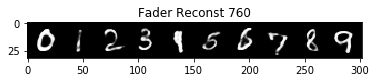


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 761 Fader Loss: -55.5257 | Adv Loss: 2.2967 | Rec Loss: 59.3117 
	| Adj Disc Loss: 344.5496 | Disc Acc: 0.1202


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 762 Fader Loss: -55.4880 | Adv Loss: 2.2960 | Rec Loss: 59.3126 
	| Adj Disc Loss: 344.5127 | Disc Acc: 0.1158


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 763 Fader Loss: -55.5219 | Adv Loss: 2.2964 | Rec Loss: 59.2985 
	| Adj Disc Loss: 344.5159 | Disc Acc: 0.1187


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 764 Fader Loss: -55.4995 | Adv Loss: 2.2965 | Rec Loss: 59.3263 
	| Adj Disc Loss: 344.5054 | Disc Acc: 0.1213


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 765 Fader Loss: -55.5036 | Adv Loss: 2.2965 | Rec Loss: 59.3202 
	| Adj Disc Loss: 344.5470 | Disc Acc: 0.1160


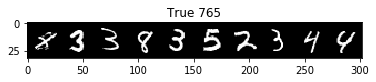

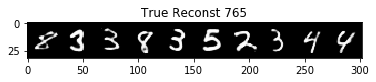

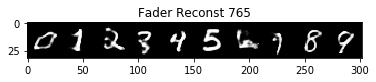


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 766 Fader Loss: -55.5080 | Adv Loss: 2.2965 | Rec Loss: 59.3158 
	| Adj Disc Loss: 344.5370 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 767 Fader Loss: -55.4927 | Adv Loss: 2.2964 | Rec Loss: 59.3264 
	| Adj Disc Loss: 344.5757 | Disc Acc: 0.1157


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 768 Fader Loss: -55.4941 | Adv Loss: 2.2968 | Rec Loss: 59.3481 
	| Adj Disc Loss: 344.5685 | Disc Acc: 0.1210


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 769 Fader Loss: -55.4614 | Adv Loss: 2.2964 | Rec Loss: 59.3602 
	| Adj Disc Loss: 344.5306 | Disc Acc: 0.1191


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 770 Fader Loss: -55.4770 | Adv Loss: 2.2966 | Rec Loss: 59.3522 
	| Adj Disc Loss: 344.6118 | Disc Acc: 0.1181


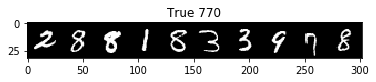

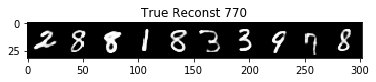

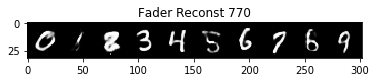


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 771 Fader Loss: -55.4980 | Adv Loss: 2.2978 | Rec Loss: 59.3936 
	| Adj Disc Loss: 344.6643 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 772 Fader Loss: -55.4817 | Adv Loss: 2.2969 | Rec Loss: 59.3637 
	| Adj Disc Loss: 344.6461 | Disc Acc: 0.1174


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 773 Fader Loss: -55.5021 | Adv Loss: 2.2972 | Rec Loss: 59.3573 
	| Adj Disc Loss: 344.6134 | Disc Acc: 0.1179


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 774 Fader Loss: -55.5313 | Adv Loss: 2.2976 | Rec Loss: 59.3468 
	| Adj Disc Loss: 344.5858 | Disc Acc: 0.1189


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 775 Fader Loss: -55.4887 | Adv Loss: 2.2968 | Rec Loss: 59.3504 
	| Adj Disc Loss: 344.6336 | Disc Acc: 0.1164


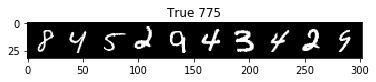

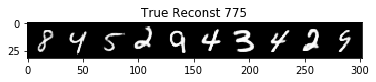

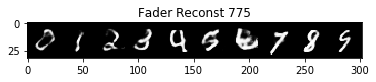


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 776 Fader Loss: -55.4867 | Adv Loss: 2.2964 | Rec Loss: 59.3355 
	| Adj Disc Loss: 344.5848 | Disc Acc: 0.1224


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 777 Fader Loss: -55.5538 | Adv Loss: 2.2975 | Rec Loss: 59.3199 
	| Adj Disc Loss: 344.5764 | Disc Acc: 0.1191


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 778 Fader Loss: -55.4863 | Adv Loss: 2.2964 | Rec Loss: 59.3355 
	| Adj Disc Loss: 344.5247 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 779 Fader Loss: -55.4837 | Adv Loss: 2.2966 | Rec Loss: 59.3461 
	| Adj Disc Loss: 344.6042 | Disc Acc: 0.1183


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 780 Fader Loss: -55.4937 | Adv Loss: 2.2966 | Rec Loss: 59.3345 
	| Adj Disc Loss: 344.5297 | Disc Acc: 0.1211


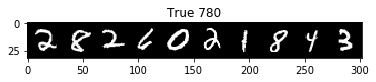

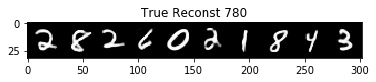

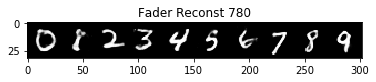


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 781 Fader Loss: -55.4985 | Adv Loss: 2.2968 | Rec Loss: 59.3409 
	| Adj Disc Loss: 344.5629 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 782 Fader Loss: -55.5113 | Adv Loss: 2.2967 | Rec Loss: 59.3233 
	| Adj Disc Loss: 344.5756 | Disc Acc: 0.1184


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 783 Fader Loss: -55.5006 | Adv Loss: 2.2961 | Rec Loss: 59.3030 
	| Adj Disc Loss: 344.4926 | Disc Acc: 0.1180


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 784 Fader Loss: -55.5002 | Adv Loss: 2.2964 | Rec Loss: 59.3216 
	| Adj Disc Loss: 344.5093 | Disc Acc: 0.1190


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 785 Fader Loss: -55.4798 | Adv Loss: 2.2960 | Rec Loss: 59.3216 
	| Adj Disc Loss: 344.5291 | Disc Acc: 0.1198


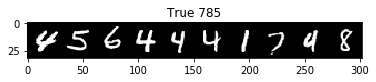

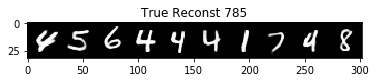

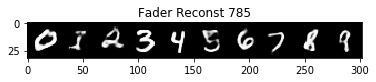


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 786 Fader Loss: -55.5253 | Adv Loss: 2.2971 | Rec Loss: 59.3284 
	| Adj Disc Loss: 344.5377 | Disc Acc: 0.1173


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 787 Fader Loss: -55.4964 | Adv Loss: 2.2958 | Rec Loss: 59.2913 
	| Adj Disc Loss: 344.5183 | Disc Acc: 0.1193


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 788 Fader Loss: -55.5349 | Adv Loss: 2.2961 | Rec Loss: 59.2722 
	| Adj Disc Loss: 344.5136 | Disc Acc: 0.1167


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 789 Fader Loss: -55.5123 | Adv Loss: 2.2964 | Rec Loss: 59.3094 
	| Adj Disc Loss: 344.4884 | Disc Acc: 0.1175


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 790 Fader Loss: -55.5591 | Adv Loss: 2.2972 | Rec Loss: 59.3031 
	| Adj Disc Loss: 344.5502 | Disc Acc: 0.1168


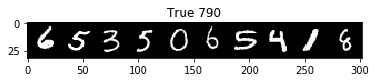

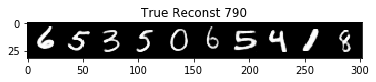

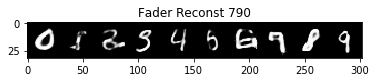


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 791 Fader Loss: -55.5194 | Adv Loss: 2.2965 | Rec Loss: 59.3037 
	| Adj Disc Loss: 344.5536 | Disc Acc: 0.1184


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 792 Fader Loss: -55.5399 | Adv Loss: 2.2965 | Rec Loss: 59.2868 
	| Adj Disc Loss: 344.5559 | Disc Acc: 0.1173


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 793 Fader Loss: -55.5561 | Adv Loss: 2.2966 | Rec Loss: 59.2732 
	| Adj Disc Loss: 344.5315 | Disc Acc: 0.1171


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 794 Fader Loss: -55.5545 | Adv Loss: 2.2969 | Rec Loss: 59.2921 
	| Adj Disc Loss: 344.5132 | Disc Acc: 0.1174


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 795 Fader Loss: -55.5466 | Adv Loss: 2.2963 | Rec Loss: 59.2704 
	| Adj Disc Loss: 344.4982 | Disc Acc: 0.1196


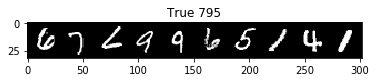

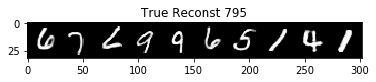

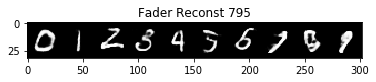


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 796 Fader Loss: -55.5476 | Adv Loss: 2.2961 | Rec Loss: 59.2570 
	| Adj Disc Loss: 344.4537 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 797 Fader Loss: -55.5083 | Adv Loss: 2.2958 | Rec Loss: 59.2839 
	| Adj Disc Loss: 344.4489 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 798 Fader Loss: -55.5255 | Adv Loss: 2.2965 | Rec Loss: 59.3019 
	| Adj Disc Loss: 344.4090 | Disc Acc: 0.1224


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 799 Fader Loss: -55.5180 | Adv Loss: 2.2963 | Rec Loss: 59.2951 
	| Adj Disc Loss: 344.4738 | Disc Acc: 0.1176


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 800 Fader Loss: -55.5234 | Adv Loss: 2.2964 | Rec Loss: 59.2951 
	| Adj Disc Loss: 344.4834 | Disc Acc: 0.1202


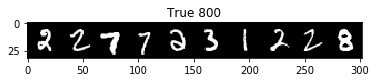

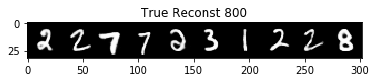

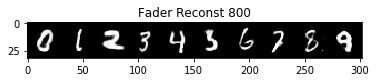


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 801 Fader Loss: -55.4840 | Adv Loss: 2.2960 | Rec Loss: 59.3172 
	| Adj Disc Loss: 344.4990 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 802 Fader Loss: -55.5380 | Adv Loss: 2.2964 | Rec Loss: 59.2808 
	| Adj Disc Loss: 344.4641 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 803 Fader Loss: -55.5357 | Adv Loss: 2.2972 | Rec Loss: 59.3266 
	| Adj Disc Loss: 344.5868 | Disc Acc: 0.1178


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 804 Fader Loss: -55.5394 | Adv Loss: 2.2970 | Rec Loss: 59.3101 
	| Adj Disc Loss: 344.5964 | Disc Acc: 0.1154


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 805 Fader Loss: -55.5668 | Adv Loss: 2.2973 | Rec Loss: 59.2977 
	| Adj Disc Loss: 344.5856 | Disc Acc: 0.1179


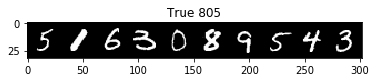

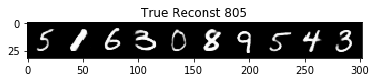

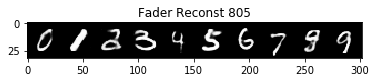


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 806 Fader Loss: -55.5438 | Adv Loss: 2.2971 | Rec Loss: 59.3114 
	| Adj Disc Loss: 344.5798 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 807 Fader Loss: -55.5498 | Adv Loss: 2.2965 | Rec Loss: 59.2737 
	| Adj Disc Loss: 344.5511 | Disc Acc: 0.1147


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 808 Fader Loss: -55.5264 | Adv Loss: 2.2964 | Rec Loss: 59.2942 
	| Adj Disc Loss: 344.4668 | Disc Acc: 0.1138


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 809 Fader Loss: -55.5241 | Adv Loss: 2.2963 | Rec Loss: 59.2909 
	| Adj Disc Loss: 344.4401 | Disc Acc: 0.1192


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 810 Fader Loss: -55.5404 | Adv Loss: 2.2968 | Rec Loss: 59.2983 
	| Adj Disc Loss: 344.4799 | Disc Acc: 0.1194


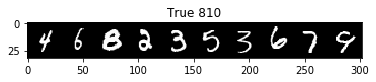

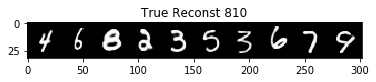

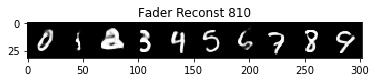


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 811 Fader Loss: -55.5749 | Adv Loss: 2.2973 | Rec Loss: 59.2900 
	| Adj Disc Loss: 344.5312 | Disc Acc: 0.1170


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 812 Fader Loss: -55.5248 | Adv Loss: 2.2969 | Rec Loss: 59.3191 
	| Adj Disc Loss: 344.5890 | Disc Acc: 0.1172


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 813 Fader Loss: -55.5184 | Adv Loss: 2.2971 | Rec Loss: 59.3376 
	| Adj Disc Loss: 344.6713 | Disc Acc: 0.1146


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 814 Fader Loss: -55.5370 | Adv Loss: 2.2966 | Rec Loss: 59.2929 
	| Adj Disc Loss: 344.5063 | Disc Acc: 0.1178


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 815 Fader Loss: -55.5683 | Adv Loss: 2.2967 | Rec Loss: 59.2674 
	| Adj Disc Loss: 344.5361 | Disc Acc: 0.1165


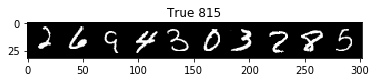

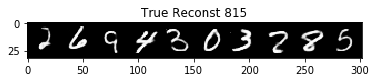

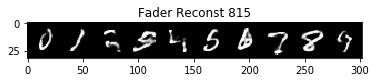


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 816 Fader Loss: -55.5897 | Adv Loss: 2.2972 | Rec Loss: 59.2680 
	| Adj Disc Loss: 344.5262 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 817 Fader Loss: -55.5790 | Adv Loss: 2.2967 | Rec Loss: 59.2556 
	| Adj Disc Loss: 344.5319 | Disc Acc: 0.1211


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 818 Fader Loss: -55.5497 | Adv Loss: 2.2969 | Rec Loss: 59.2973 
	| Adj Disc Loss: 344.5394 | Disc Acc: 0.1177


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 819 Fader Loss: -55.5522 | Adv Loss: 2.2969 | Rec Loss: 59.2917 
	| Adj Disc Loss: 344.5772 | Disc Acc: 0.1167


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 820 Fader Loss: -55.5542 | Adv Loss: 2.2965 | Rec Loss: 59.2731 
	| Adj Disc Loss: 344.5483 | Disc Acc: 0.1158


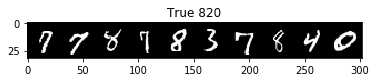

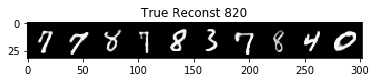

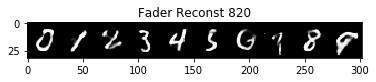


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 821 Fader Loss: -55.5412 | Adv Loss: 2.2962 | Rec Loss: 59.2669 
	| Adj Disc Loss: 344.4962 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 822 Fader Loss: -55.5265 | Adv Loss: 2.2963 | Rec Loss: 59.2900 
	| Adj Disc Loss: 344.5163 | Disc Acc: 0.1183


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 823 Fader Loss: -55.5534 | Adv Loss: 2.2964 | Rec Loss: 59.2688 
	| Adj Disc Loss: 344.5221 | Disc Acc: 0.1161


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 824 Fader Loss: -55.5827 | Adv Loss: 2.2971 | Rec Loss: 59.2744 
	| Adj Disc Loss: 344.4925 | Disc Acc: 0.1179


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 825 Fader Loss: -55.5287 | Adv Loss: 2.2964 | Rec Loss: 59.2923 
	| Adj Disc Loss: 344.5084 | Disc Acc: 0.1187


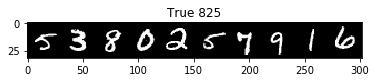

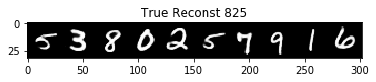

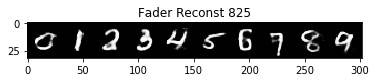


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 826 Fader Loss: -55.5672 | Adv Loss: 2.2975 | Rec Loss: 59.3057 
	| Adj Disc Loss: 344.5888 | Disc Acc: 0.1195


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 827 Fader Loss: -55.5497 | Adv Loss: 2.2977 | Rec Loss: 59.3340 
	| Adj Disc Loss: 344.6670 | Disc Acc: 0.1174


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 828 Fader Loss: -55.5951 | Adv Loss: 2.2981 | Rec Loss: 59.3079 
	| Adj Disc Loss: 344.7268 | Disc Acc: 0.1149


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 829 Fader Loss: -55.5820 | Adv Loss: 2.2972 | Rec Loss: 59.2757 
	| Adj Disc Loss: 344.6450 | Disc Acc: 0.1206


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 830 Fader Loss: -55.5269 | Adv Loss: 2.2961 | Rec Loss: 59.2802 
	| Adj Disc Loss: 344.5994 | Disc Acc: 0.1201


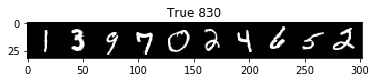

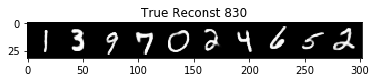

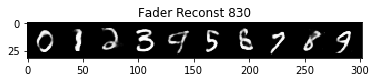


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 831 Fader Loss: -55.5523 | Adv Loss: 2.2967 | Rec Loss: 59.2817 
	| Adj Disc Loss: 344.5979 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 832 Fader Loss: -55.6324 | Adv Loss: 2.2982 | Rec Loss: 59.2799 
	| Adj Disc Loss: 344.6956 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 833 Fader Loss: -55.6035 | Adv Loss: 2.2973 | Rec Loss: 59.2603 
	| Adj Disc Loss: 344.6076 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 834 Fader Loss: -55.6249 | Adv Loss: 2.2975 | Rec Loss: 59.2503 
	| Adj Disc Loss: 344.6580 | Disc Acc: 0.1170


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 835 Fader Loss: -55.6493 | Adv Loss: 2.2979 | Rec Loss: 59.2462 
	| Adj Disc Loss: 344.6698 | Disc Acc: 0.1170


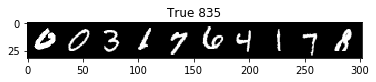

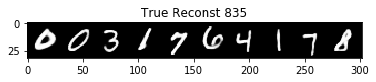

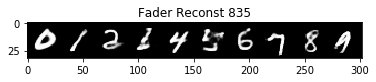


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 836 Fader Loss: -55.6010 | Adv Loss: 2.2967 | Rec Loss: 59.2361 
	| Adj Disc Loss: 344.5821 | Disc Acc: 0.1229


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 837 Fader Loss: -55.6043 | Adv Loss: 2.2975 | Rec Loss: 59.2685 
	| Adj Disc Loss: 344.6475 | Disc Acc: 0.1168


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 838 Fader Loss: -55.6403 | Adv Loss: 2.2971 | Rec Loss: 59.2152 
	| Adj Disc Loss: 344.5601 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 839 Fader Loss: -55.6263 | Adv Loss: 2.2966 | Rec Loss: 59.2045 
	| Adj Disc Loss: 344.5044 | Disc Acc: 0.1205


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 840 Fader Loss: -55.6144 | Adv Loss: 2.2967 | Rec Loss: 59.2201 
	| Adj Disc Loss: 344.5176 | Disc Acc: 0.1199


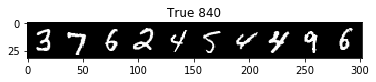

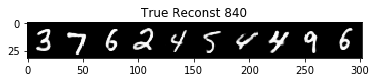

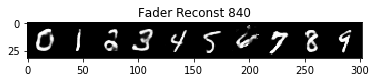


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 841 Fader Loss: -55.6067 | Adv Loss: 2.2967 | Rec Loss: 59.2280 
	| Adj Disc Loss: 344.5766 | Disc Acc: 0.1219


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 842 Fader Loss: -55.6175 | Adv Loss: 2.2972 | Rec Loss: 59.2443 
	| Adj Disc Loss: 344.5633 | Disc Acc: 0.1173


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 843 Fader Loss: -55.6206 | Adv Loss: 2.2965 | Rec Loss: 59.2065 
	| Adj Disc Loss: 344.5714 | Disc Acc: 0.1190


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 844 Fader Loss: -55.5851 | Adv Loss: 2.2963 | Rec Loss: 59.2302 
	| Adj Disc Loss: 344.5527 | Disc Acc: 0.1205


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 845 Fader Loss: -55.5843 | Adv Loss: 2.2962 | Rec Loss: 59.2260 
	| Adj Disc Loss: 344.5767 | Disc Acc: 0.1216


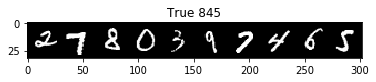

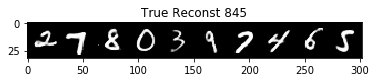

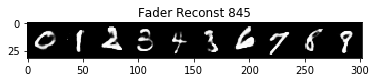


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 846 Fader Loss: -55.6327 | Adv Loss: 2.2972 | Rec Loss: 59.2278 
	| Adj Disc Loss: 344.5493 | Disc Acc: 0.1174


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 847 Fader Loss: -55.5926 | Adv Loss: 2.2968 | Rec Loss: 59.2456 
	| Adj Disc Loss: 344.5718 | Disc Acc: 0.1173


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 848 Fader Loss: -55.6364 | Adv Loss: 2.2975 | Rec Loss: 59.2367 
	| Adj Disc Loss: 344.6351 | Disc Acc: 0.1148


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 849 Fader Loss: -55.6154 | Adv Loss: 2.2969 | Rec Loss: 59.2313 
	| Adj Disc Loss: 344.5616 | Disc Acc: 0.1210


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 850 Fader Loss: -55.5991 | Adv Loss: 2.2965 | Rec Loss: 59.2243 
	| Adj Disc Loss: 344.4594 | Disc Acc: 0.1187


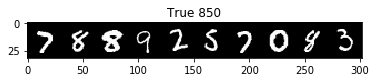

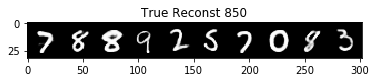

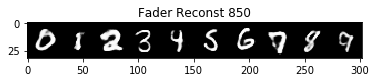


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 851 Fader Loss: -55.5993 | Adv Loss: 2.2962 | Rec Loss: 59.2130 
	| Adj Disc Loss: 344.5060 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 852 Fader Loss: -55.6099 | Adv Loss: 2.2967 | Rec Loss: 59.2250 
	| Adj Disc Loss: 344.5397 | Disc Acc: 0.1202


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 853 Fader Loss: -55.5776 | Adv Loss: 2.2965 | Rec Loss: 59.2468 
	| Adj Disc Loss: 344.5813 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 854 Fader Loss: -55.5596 | Adv Loss: 2.2962 | Rec Loss: 59.2510 
	| Adj Disc Loss: 344.5862 | Disc Acc: 0.1208


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 855 Fader Loss: -55.5768 | Adv Loss: 2.2967 | Rec Loss: 59.2591 
	| Adj Disc Loss: 344.5854 | Disc Acc: 0.1191


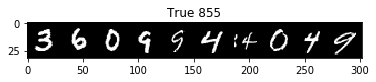

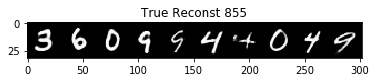

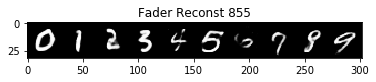


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 856 Fader Loss: -55.5533 | Adv Loss: 2.2958 | Rec Loss: 59.2384 
	| Adj Disc Loss: 344.4655 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 857 Fader Loss: -55.5821 | Adv Loss: 2.2967 | Rec Loss: 59.2531 
	| Adj Disc Loss: 344.6267 | Disc Acc: 0.1215


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 858 Fader Loss: -55.6208 | Adv Loss: 2.2973 | Rec Loss: 59.2457 
	| Adj Disc Loss: 344.5818 | Disc Acc: 0.1226


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 859 Fader Loss: -55.5787 | Adv Loss: 2.2968 | Rec Loss: 59.2604 
	| Adj Disc Loss: 344.6642 | Disc Acc: 0.1193


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 860 Fader Loss: -55.6151 | Adv Loss: 2.2978 | Rec Loss: 59.2762 
	| Adj Disc Loss: 344.7163 | Disc Acc: 0.1190


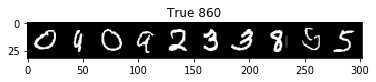

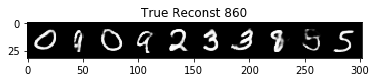

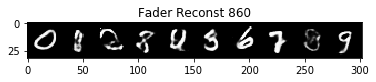


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 861 Fader Loss: -55.6096 | Adv Loss: 2.2968 | Rec Loss: 59.2317 
	| Adj Disc Loss: 344.5862 | Disc Acc: 0.1211


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 862 Fader Loss: -55.6267 | Adv Loss: 2.2973 | Rec Loss: 59.2397 
	| Adj Disc Loss: 344.5995 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 863 Fader Loss: -55.6280 | Adv Loss: 2.2968 | Rec Loss: 59.2107 
	| Adj Disc Loss: 344.5758 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 864 Fader Loss: -55.6135 | Adv Loss: 2.2974 | Rec Loss: 59.2556 
	| Adj Disc Loss: 344.6086 | Disc Acc: 0.1204


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 865 Fader Loss: -55.6008 | Adv Loss: 2.2970 | Rec Loss: 59.2502 
	| Adj Disc Loss: 344.6134 | Disc Acc: 0.1171


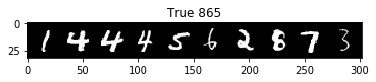

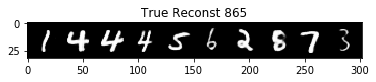

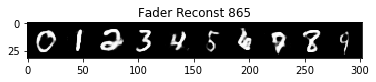


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 866 Fader Loss: -55.5953 | Adv Loss: 2.2965 | Rec Loss: 59.2300 
	| Adj Disc Loss: 344.5967 | Disc Acc: 0.1209


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 867 Fader Loss: -55.6047 | Adv Loss: 2.2971 | Rec Loss: 59.2509 
	| Adj Disc Loss: 344.5975 | Disc Acc: 0.1194


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 868 Fader Loss: -55.6273 | Adv Loss: 2.2983 | Rec Loss: 59.2859 
	| Adj Disc Loss: 344.7915 | Disc Acc: 0.1180


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 869 Fader Loss: -55.6179 | Adv Loss: 2.2972 | Rec Loss: 59.2434 
	| Adj Disc Loss: 344.6810 | Disc Acc: 0.1200


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 870 Fader Loss: -55.6525 | Adv Loss: 2.2977 | Rec Loss: 59.2310 
	| Adj Disc Loss: 344.6987 | Disc Acc: 0.1210


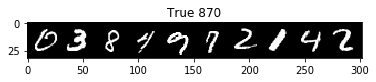

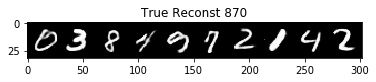

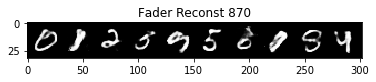


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 871 Fader Loss: -55.6391 | Adv Loss: 2.2971 | Rec Loss: 59.2167 
	| Adj Disc Loss: 344.5669 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 872 Fader Loss: -55.5932 | Adv Loss: 2.2963 | Rec Loss: 59.2217 
	| Adj Disc Loss: 344.6191 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 873 Fader Loss: -55.6041 | Adv Loss: 2.2966 | Rec Loss: 59.2269 
	| Adj Disc Loss: 344.5556 | Disc Acc: 0.1196


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 874 Fader Loss: -55.6205 | Adv Loss: 2.2972 | Rec Loss: 59.2383 
	| Adj Disc Loss: 344.6218 | Disc Acc: 0.1207


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 875 Fader Loss: -55.6324 | Adv Loss: 2.2970 | Rec Loss: 59.2164 
	| Adj Disc Loss: 344.6114 | Disc Acc: 0.1175


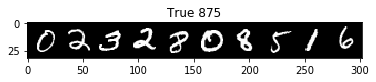

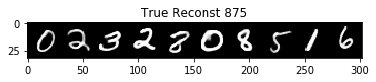

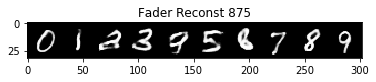


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 876 Fader Loss: -55.6588 | Adv Loss: 2.2968 | Rec Loss: 59.1826 
	| Adj Disc Loss: 344.5495 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 877 Fader Loss: -55.6256 | Adv Loss: 2.2970 | Rec Loss: 59.2268 
	| Adj Disc Loss: 344.6166 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 878 Fader Loss: -55.5885 | Adv Loss: 2.2968 | Rec Loss: 59.2493 
	| Adj Disc Loss: 344.5789 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 879 Fader Loss: -55.6127 | Adv Loss: 2.2968 | Rec Loss: 59.2262 
	| Adj Disc Loss: 344.5699 | Disc Acc: 0.1219


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 880 Fader Loss: -55.6689 | Adv Loss: 2.2977 | Rec Loss: 59.2141 
	| Adj Disc Loss: 344.6532 | Disc Acc: 0.1141


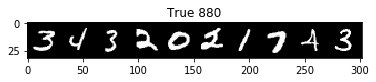

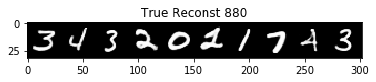

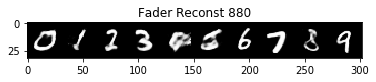


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 881 Fader Loss: -55.6499 | Adv Loss: 2.2973 | Rec Loss: 59.2174 
	| Adj Disc Loss: 344.5672 | Disc Acc: 0.1173


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 882 Fader Loss: -55.6311 | Adv Loss: 2.2972 | Rec Loss: 59.2267 
	| Adj Disc Loss: 344.5821 | Disc Acc: 0.1201


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 883 Fader Loss: -55.6472 | Adv Loss: 2.2977 | Rec Loss: 59.2375 
	| Adj Disc Loss: 344.6417 | Disc Acc: 0.1170


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 884 Fader Loss: -55.6570 | Adv Loss: 2.2973 | Rec Loss: 59.2064 
	| Adj Disc Loss: 344.6506 | Disc Acc: 0.1184


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 885 Fader Loss: -55.6623 | Adv Loss: 2.2970 | Rec Loss: 59.1854 
	| Adj Disc Loss: 344.5828 | Disc Acc: 0.1197


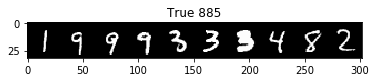

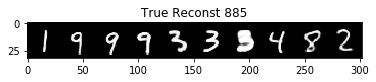

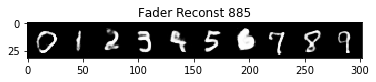


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 886 Fader Loss: -55.6389 | Adv Loss: 2.2970 | Rec Loss: 59.2096 
	| Adj Disc Loss: 344.6145 | Disc Acc: 0.1195


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 887 Fader Loss: -55.6603 | Adv Loss: 2.2973 | Rec Loss: 59.2033 
	| Adj Disc Loss: 344.6439 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 888 Fader Loss: -55.6344 | Adv Loss: 2.2966 | Rec Loss: 59.1971 
	| Adj Disc Loss: 344.6039 | Disc Acc: 0.1184


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 889 Fader Loss: -55.6596 | Adv Loss: 2.2975 | Rec Loss: 59.2147 
	| Adj Disc Loss: 344.6354 | Disc Acc: 0.1191


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 890 Fader Loss: -55.6524 | Adv Loss: 2.2971 | Rec Loss: 59.2047 
	| Adj Disc Loss: 344.6177 | Disc Acc: 0.1164


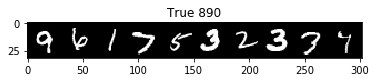

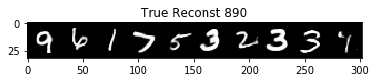

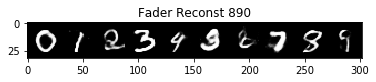


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 891 Fader Loss: -55.6416 | Adv Loss: 2.2970 | Rec Loss: 59.2102 
	| Adj Disc Loss: 344.5918 | Disc Acc: 0.1196


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 892 Fader Loss: -55.6745 | Adv Loss: 2.2969 | Rec Loss: 59.1702 
	| Adj Disc Loss: 344.5164 | Disc Acc: 0.1183


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 893 Fader Loss: -55.6791 | Adv Loss: 2.2972 | Rec Loss: 59.1826 
	| Adj Disc Loss: 344.6610 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 894 Fader Loss: -55.6808 | Adv Loss: 2.2968 | Rec Loss: 59.1615 
	| Adj Disc Loss: 344.4841 | Disc Acc: 0.1197


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 895 Fader Loss: -55.7127 | Adv Loss: 2.2973 | Rec Loss: 59.1527 
	| Adj Disc Loss: 344.6137 | Disc Acc: 0.1216


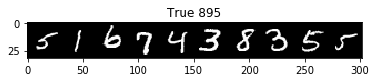

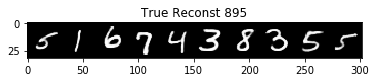

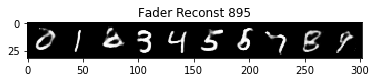


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 896 Fader Loss: -55.7171 | Adv Loss: 2.2970 | Rec Loss: 59.1353 
	| Adj Disc Loss: 344.5971 | Disc Acc: 0.1210


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 897 Fader Loss: -55.6975 | Adv Loss: 2.2968 | Rec Loss: 59.1420 
	| Adj Disc Loss: 344.5485 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 898 Fader Loss: -55.6912 | Adv Loss: 2.2970 | Rec Loss: 59.1591 
	| Adj Disc Loss: 344.6387 | Disc Acc: 0.1205


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 899 Fader Loss: -55.7192 | Adv Loss: 2.2976 | Rec Loss: 59.1622 
	| Adj Disc Loss: 344.6685 | Disc Acc: 0.1196


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 900 Fader Loss: -55.7455 | Adv Loss: 2.2983 | Rec Loss: 59.1670 
	| Adj Disc Loss: 344.7352 | Disc Acc: 0.1171


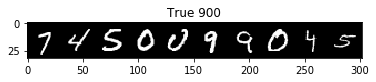

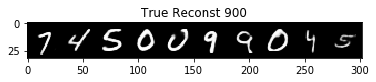

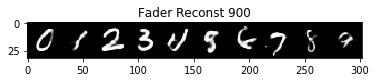


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 901 Fader Loss: -55.6832 | Adv Loss: 2.2968 | Rec Loss: 59.1559 
	| Adj Disc Loss: 344.5956 | Disc Acc: 0.1184


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 902 Fader Loss: -55.7733 | Adv Loss: 2.2978 | Rec Loss: 59.1174 
	| Adj Disc Loss: 344.7498 | Disc Acc: 0.1175


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 903 Fader Loss: -55.7305 | Adv Loss: 2.2969 | Rec Loss: 59.1136 
	| Adj Disc Loss: 344.6496 | Disc Acc: 0.1180


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 904 Fader Loss: -55.7443 | Adv Loss: 2.2970 | Rec Loss: 59.1037 
	| Adj Disc Loss: 344.6597 | Disc Acc: 0.1177


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 905 Fader Loss: -55.7490 | Adv Loss: 2.2975 | Rec Loss: 59.1281 
	| Adj Disc Loss: 344.6800 | Disc Acc: 0.1164


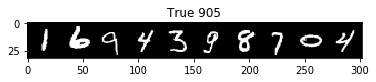

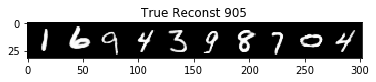

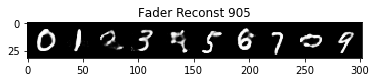


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 906 Fader Loss: -55.7638 | Adv Loss: 2.2971 | Rec Loss: 59.0915 
	| Adj Disc Loss: 344.5705 | Disc Acc: 0.1176


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 907 Fader Loss: -55.7548 | Adv Loss: 2.2967 | Rec Loss: 59.0821 
	| Adj Disc Loss: 344.5694 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 908 Fader Loss: -55.7937 | Adv Loss: 2.2978 | Rec Loss: 59.0962 
	| Adj Disc Loss: 344.5785 | Disc Acc: 0.1184


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 909 Fader Loss: -55.7520 | Adv Loss: 2.2968 | Rec Loss: 59.0902 
	| Adj Disc Loss: 344.5827 | Disc Acc: 0.1132


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 910 Fader Loss: -55.6765 | Adv Loss: 2.2955 | Rec Loss: 59.0998 
	| Adj Disc Loss: 344.5387 | Disc Acc: 0.1150


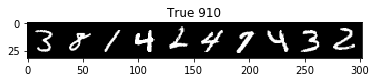

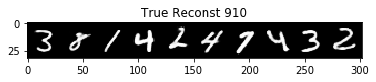

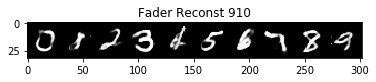


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 911 Fader Loss: -55.7579 | Adv Loss: 2.2971 | Rec Loss: 59.0981 
	| Adj Disc Loss: 344.6149 | Disc Acc: 0.1170


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 912 Fader Loss: -55.7228 | Adv Loss: 2.2969 | Rec Loss: 59.1209 
	| Adj Disc Loss: 344.5863 | Disc Acc: 0.1123


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 913 Fader Loss: -55.7461 | Adv Loss: 2.2966 | Rec Loss: 59.0852 
	| Adj Disc Loss: 344.4457 | Disc Acc: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 914 Fader Loss: -55.7391 | Adv Loss: 2.2969 | Rec Loss: 59.1055 
	| Adj Disc Loss: 344.5502 | Disc Acc: 0.1191


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 915 Fader Loss: -55.7510 | Adv Loss: 2.2971 | Rec Loss: 59.1024 
	| Adj Disc Loss: 344.5459 | Disc Acc: 0.1174


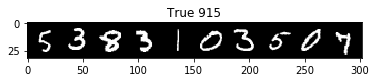

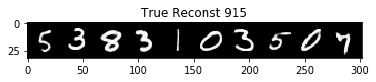

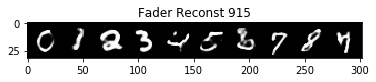


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 916 Fader Loss: -55.6830 | Adv Loss: 2.2962 | Rec Loss: 59.1272 
	| Adj Disc Loss: 344.5760 | Disc Acc: 0.1213


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 917 Fader Loss: -55.6923 | Adv Loss: 2.2966 | Rec Loss: 59.1363 
	| Adj Disc Loss: 344.5479 | Disc Acc: 0.1182


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 918 Fader Loss: -55.6872 | Adv Loss: 2.2965 | Rec Loss: 59.1384 
	| Adj Disc Loss: 344.5076 | Disc Acc: 0.1216


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 919 Fader Loss: -55.6937 | Adv Loss: 2.2970 | Rec Loss: 59.1583 
	| Adj Disc Loss: 344.5712 | Disc Acc: 0.1187


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 920 Fader Loss: -55.7181 | Adv Loss: 2.2970 | Rec Loss: 59.1300 
	| Adj Disc Loss: 344.5468 | Disc Acc: 0.1174


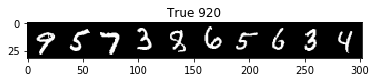

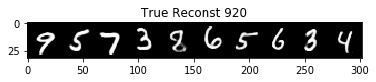

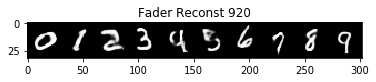


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 921 Fader Loss: -55.6903 | Adv Loss: 2.2962 | Rec Loss: 59.1198 
	| Adj Disc Loss: 344.4873 | Disc Acc: 0.1228


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 922 Fader Loss: -55.6568 | Adv Loss: 2.2958 | Rec Loss: 59.1356 
	| Adj Disc Loss: 344.4760 | Disc Acc: 0.1242


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 923 Fader Loss: -55.6901 | Adv Loss: 2.2964 | Rec Loss: 59.1293 
	| Adj Disc Loss: 344.5863 | Disc Acc: 0.1200


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 924 Fader Loss: -55.7291 | Adv Loss: 2.2977 | Rec Loss: 59.1582 
	| Adj Disc Loss: 344.6601 | Disc Acc: 0.1166


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 925 Fader Loss: -55.6908 | Adv Loss: 2.2963 | Rec Loss: 59.1237 
	| Adj Disc Loss: 344.5274 | Disc Acc: 0.1176


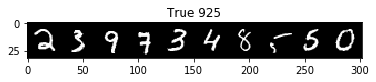

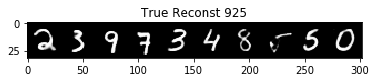

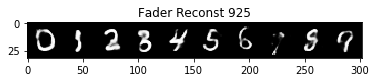


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 926 Fader Loss: -55.7484 | Adv Loss: 2.2972 | Rec Loss: 59.1095 
	| Adj Disc Loss: 344.5440 | Disc Acc: 0.1174


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 927 Fader Loss: -55.7280 | Adv Loss: 2.2965 | Rec Loss: 59.0995 
	| Adj Disc Loss: 344.5628 | Disc Acc: 0.1196


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 928 Fader Loss: -55.7217 | Adv Loss: 2.2963 | Rec Loss: 59.0918 
	| Adj Disc Loss: 344.5265 | Disc Acc: 0.1188


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 929 Fader Loss: -55.7315 | Adv Loss: 2.2964 | Rec Loss: 59.0873 
	| Adj Disc Loss: 344.4924 | Disc Acc: 0.1206


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 930 Fader Loss: -55.7177 | Adv Loss: 2.2959 | Rec Loss: 59.0759 
	| Adj Disc Loss: 344.3669 | Disc Acc: 0.1222


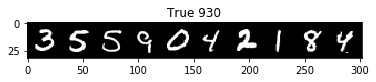

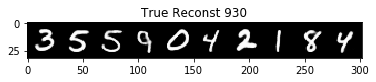

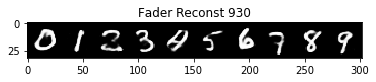


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 931 Fader Loss: -55.6896 | Adv Loss: 2.2961 | Rec Loss: 59.1166 
	| Adj Disc Loss: 344.4028 | Disc Acc: 0.1255


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 932 Fader Loss: -55.6957 | Adv Loss: 2.2959 | Rec Loss: 59.1006 
	| Adj Disc Loss: 344.4930 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 933 Fader Loss: -55.6720 | Adv Loss: 2.2955 | Rec Loss: 59.1024 
	| Adj Disc Loss: 344.4185 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 934 Fader Loss: -55.6542 | Adv Loss: 2.2950 | Rec Loss: 59.0972 
	| Adj Disc Loss: 344.4271 | Disc Acc: 0.1228


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 935 Fader Loss: -55.7190 | Adv Loss: 2.2963 | Rec Loss: 59.0973 
	| Adj Disc Loss: 344.4550 | Disc Acc: 0.1222


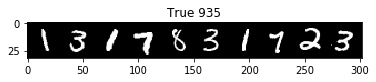

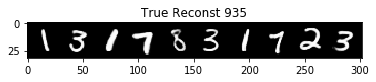

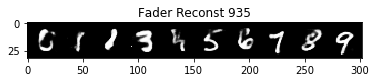


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 936 Fader Loss: -55.7173 | Adv Loss: 2.2963 | Rec Loss: 59.0972 
	| Adj Disc Loss: 344.4342 | Disc Acc: 0.1197


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 937 Fader Loss: -55.6857 | Adv Loss: 2.2959 | Rec Loss: 59.1087 
	| Adj Disc Loss: 344.4966 | Disc Acc: 0.1190


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 938 Fader Loss: -55.7367 | Adv Loss: 2.2966 | Rec Loss: 59.0951 
	| Adj Disc Loss: 344.5571 | Disc Acc: 0.1186


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 939 Fader Loss: -55.7500 | Adv Loss: 2.2968 | Rec Loss: 59.0904 
	| Adj Disc Loss: 344.5430 | Disc Acc: 0.1214


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 940 Fader Loss: -55.7166 | Adv Loss: 2.2960 | Rec Loss: 59.0841 
	| Adj Disc Loss: 344.5189 | Disc Acc: 0.1204


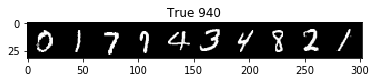

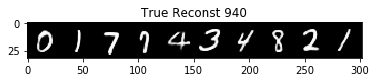

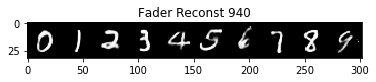


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 941 Fader Loss: -55.7572 | Adv Loss: 2.2965 | Rec Loss: 59.0666 
	| Adj Disc Loss: 344.4604 | Disc Acc: 0.1196


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 942 Fader Loss: -55.7439 | Adv Loss: 2.2961 | Rec Loss: 59.0603 
	| Adj Disc Loss: 344.4879 | Disc Acc: 0.1238


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 943 Fader Loss: -55.7406 | Adv Loss: 2.2962 | Rec Loss: 59.0696 
	| Adj Disc Loss: 344.5020 | Disc Acc: 0.1207


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 944 Fader Loss: -55.7726 | Adv Loss: 2.2968 | Rec Loss: 59.0665 
	| Adj Disc Loss: 344.5323 | Disc Acc: 0.1153


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 945 Fader Loss: -55.8086 | Adv Loss: 2.2970 | Rec Loss: 59.0428 
	| Adj Disc Loss: 344.5519 | Disc Acc: 0.1179


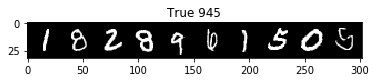

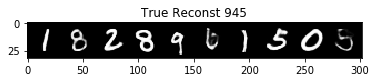

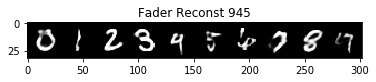


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 946 Fader Loss: -55.7945 | Adv Loss: 2.2970 | Rec Loss: 59.0543 
	| Adj Disc Loss: 344.6074 | Disc Acc: 0.1191


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 947 Fader Loss: -55.7916 | Adv Loss: 2.2968 | Rec Loss: 59.0467 
	| Adj Disc Loss: 344.5685 | Disc Acc: 0.1151


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 948 Fader Loss: -55.7980 | Adv Loss: 2.2963 | Rec Loss: 59.0188 
	| Adj Disc Loss: 344.4792 | Disc Acc: 0.1178


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 949 Fader Loss: -55.7911 | Adv Loss: 2.2960 | Rec Loss: 59.0101 
	| Adj Disc Loss: 344.4363 | Disc Acc: 0.1178


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 950 Fader Loss: -55.7728 | Adv Loss: 2.2962 | Rec Loss: 59.0360 
	| Adj Disc Loss: 344.4264 | Disc Acc: 0.1217


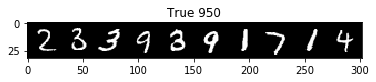

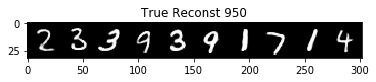

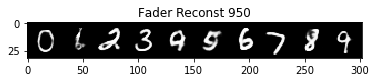


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 951 Fader Loss: -55.7868 | Adv Loss: 2.2963 | Rec Loss: 59.0271 
	| Adj Disc Loss: 344.4359 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 952 Fader Loss: -55.7590 | Adv Loss: 2.2958 | Rec Loss: 59.0317 
	| Adj Disc Loss: 344.4379 | Disc Acc: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 953 Fader Loss: -55.7503 | Adv Loss: 2.2958 | Rec Loss: 59.0407 
	| Adj Disc Loss: 344.4099 | Disc Acc: 0.1192


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 954 Fader Loss: -55.7753 | Adv Loss: 2.2957 | Rec Loss: 59.0098 
	| Adj Disc Loss: 344.3741 | Disc Acc: 0.1189


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 955 Fader Loss: -55.7577 | Adv Loss: 2.2960 | Rec Loss: 59.0420 
	| Adj Disc Loss: 344.4721 | Disc Acc: 0.1188


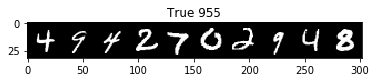

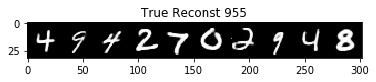

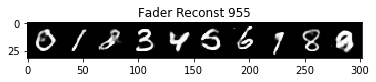


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 956 Fader Loss: -55.7478 | Adv Loss: 2.2954 | Rec Loss: 59.0233 
	| Adj Disc Loss: 344.4220 | Disc Acc: 0.1212


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 957 Fader Loss: -55.7907 | Adv Loss: 2.2960 | Rec Loss: 59.0098 
	| Adj Disc Loss: 344.4213 | Disc Acc: 0.1204


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 958 Fader Loss: -55.7554 | Adv Loss: 2.2954 | Rec Loss: 59.0156 
	| Adj Disc Loss: 344.3443 | Disc Acc: 0.1188


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 959 Fader Loss: -55.7537 | Adv Loss: 2.2957 | Rec Loss: 59.0308 
	| Adj Disc Loss: 344.4283 | Disc Acc: 0.1215


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 960 Fader Loss: -55.7356 | Adv Loss: 2.2955 | Rec Loss: 59.0385 
	| Adj Disc Loss: 344.4352 | Disc Acc: 0.1208


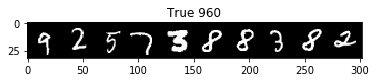

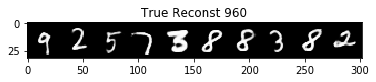

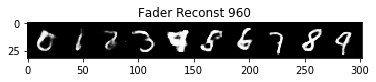


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 961 Fader Loss: -55.7685 | Adv Loss: 2.2955 | Rec Loss: 59.0052 
	| Adj Disc Loss: 344.3904 | Disc Acc: 0.1169


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 962 Fader Loss: -55.7635 | Adv Loss: 2.2957 | Rec Loss: 59.0194 
	| Adj Disc Loss: 344.3782 | Disc Acc: 0.1185


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 963 Fader Loss: -55.7406 | Adv Loss: 2.2952 | Rec Loss: 59.0197 
	| Adj Disc Loss: 344.3681 | Disc Acc: 0.1230


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 964 Fader Loss: -55.7201 | Adv Loss: 2.2948 | Rec Loss: 59.0196 
	| Adj Disc Loss: 344.3328 | Disc Acc: 0.1234


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 965 Fader Loss: -55.7790 | Adv Loss: 2.2957 | Rec Loss: 59.0073 
	| Adj Disc Loss: 344.4473 | Disc Acc: 0.1174


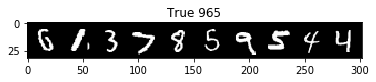

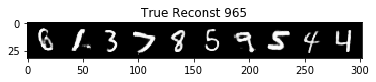

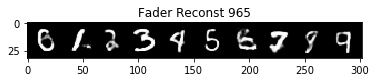


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 966 Fader Loss: -55.7849 | Adv Loss: 2.2958 | Rec Loss: 59.0034 
	| Adj Disc Loss: 344.3876 | Disc Acc: 0.1162


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 967 Fader Loss: -55.7447 | Adv Loss: 2.2957 | Rec Loss: 59.0414 
	| Adj Disc Loss: 344.4036 | Disc Acc: 0.1181


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 968 Fader Loss: -55.7822 | Adv Loss: 2.2960 | Rec Loss: 59.0182 
	| Adj Disc Loss: 344.4081 | Disc Acc: 0.1189


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 969 Fader Loss: -55.7479 | Adv Loss: 2.2957 | Rec Loss: 59.0367 
	| Adj Disc Loss: 344.4652 | Disc Acc: 0.1169


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 970 Fader Loss: -55.7671 | Adv Loss: 2.2957 | Rec Loss: 59.0193 
	| Adj Disc Loss: 344.4367 | Disc Acc: 0.1163


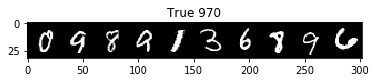

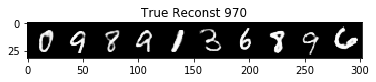

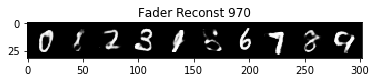


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 971 Fader Loss: -55.7581 | Adv Loss: 2.2953 | Rec Loss: 59.0054 
	| Adj Disc Loss: 344.4383 | Disc Acc: 0.1164


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 972 Fader Loss: -55.7880 | Adv Loss: 2.2960 | Rec Loss: 59.0138 
	| Adj Disc Loss: 344.4235 | Disc Acc: 0.1159


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 973 Fader Loss: -55.7761 | Adv Loss: 2.2963 | Rec Loss: 59.0369 
	| Adj Disc Loss: 344.4396 | Disc Acc: 0.1163


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 974 Fader Loss: -55.7824 | Adv Loss: 2.2959 | Rec Loss: 59.0135 
	| Adj Disc Loss: 344.4820 | Disc Acc: 0.1174


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 975 Fader Loss: -55.7504 | Adv Loss: 2.2951 | Rec Loss: 59.0034 
	| Adj Disc Loss: 344.3846 | Disc Acc: 0.1169


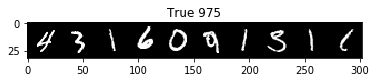

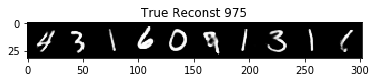

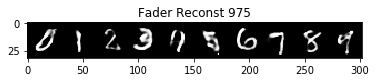


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 976 Fader Loss: -55.7673 | Adv Loss: 2.2960 | Rec Loss: 59.0344 
	| Adj Disc Loss: 344.4955 | Disc Acc: 0.1161


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 977 Fader Loss: -55.7859 | Adv Loss: 2.2960 | Rec Loss: 59.0157 
	| Adj Disc Loss: 344.5150 | Disc Acc: 0.1180


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 978 Fader Loss: -55.7871 | Adv Loss: 2.2959 | Rec Loss: 59.0083 
	| Adj Disc Loss: 344.4167 | Disc Acc: 0.1151


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 979 Fader Loss: -55.7723 | Adv Loss: 2.2958 | Rec Loss: 59.0196 
	| Adj Disc Loss: 344.4012 | Disc Acc: 0.1177


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 980 Fader Loss: -55.7887 | Adv Loss: 2.2962 | Rec Loss: 59.0226 
	| Adj Disc Loss: 344.5239 | Disc Acc: 0.1183


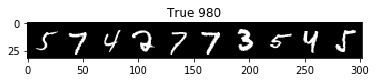

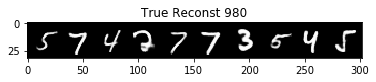

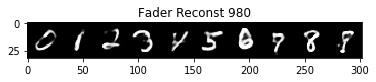


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 981 Fader Loss: -55.7642 | Adv Loss: 2.2958 | Rec Loss: 59.0241 
	| Adj Disc Loss: 344.4628 | Disc Acc: 0.1170


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 982 Fader Loss: -55.8153 | Adv Loss: 2.2964 | Rec Loss: 59.0035 
	| Adj Disc Loss: 344.5270 | Disc Acc: 0.1162


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 983 Fader Loss: -55.8147 | Adv Loss: 2.2963 | Rec Loss: 58.9987 
	| Adj Disc Loss: 344.4461 | Disc Acc: 0.1191


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 984 Fader Loss: -55.7677 | Adv Loss: 2.2956 | Rec Loss: 59.0122 
	| Adj Disc Loss: 344.4588 | Disc Acc: 0.1159


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 985 Fader Loss: -55.7882 | Adv Loss: 2.2963 | Rec Loss: 59.0284 
	| Adj Disc Loss: 344.4952 | Disc Acc: 0.1169


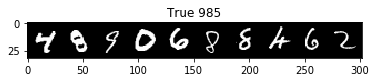

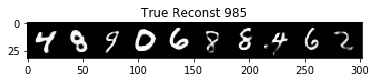

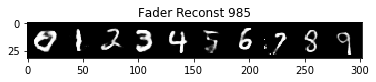


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 986 Fader Loss: -55.8280 | Adv Loss: 2.2965 | Rec Loss: 58.9957 
	| Adj Disc Loss: 344.5069 | Disc Acc: 0.1159


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 987 Fader Loss: -55.8254 | Adv Loss: 2.2962 | Rec Loss: 58.9859 
	| Adj Disc Loss: 344.5155 | Disc Acc: 0.1146


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 988 Fader Loss: -55.8209 | Adv Loss: 2.2963 | Rec Loss: 58.9934 
	| Adj Disc Loss: 344.4888 | Disc Acc: 0.1159


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 989 Fader Loss: -55.8101 | Adv Loss: 2.2964 | Rec Loss: 59.0091 
	| Adj Disc Loss: 344.5106 | Disc Acc: 0.1151


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 990 Fader Loss: -55.8185 | Adv Loss: 2.2964 | Rec Loss: 59.0006 
	| Adj Disc Loss: 344.4435 | Disc Acc: 0.1169


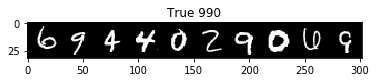

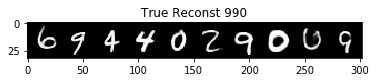

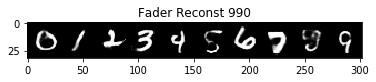


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 991 Fader Loss: -55.8198 | Adv Loss: 2.2962 | Rec Loss: 58.9900 
	| Adj Disc Loss: 344.4706 | Disc Acc: 0.1162


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 992 Fader Loss: -55.8442 | Adv Loss: 2.2966 | Rec Loss: 58.9856 
	| Adj Disc Loss: 344.5376 | Disc Acc: 0.1177


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 993 Fader Loss: -55.8456 | Adv Loss: 2.2966 | Rec Loss: 58.9833 
	| Adj Disc Loss: 344.4741 | Disc Acc: 0.1199


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 994 Fader Loss: -55.8429 | Adv Loss: 2.2962 | Rec Loss: 58.9652 
	| Adj Disc Loss: 344.4676 | Disc Acc: 0.1202


  0%|          | 0/79 [00:00<?, ?it/s]

====> Epoch: 995 Fader Loss: -55.8237 | Adv Loss: 2.2962 | Rec Loss: 58.9853 
	| Adj Disc Loss: 344.4814 | Disc Acc: 0.1195


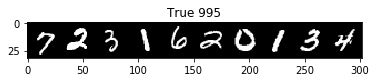

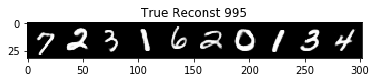

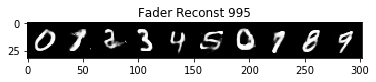


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 996 Fader Loss: -55.8589 | Adv Loss: 2.2969 | Rec Loss: 58.9863 
	| Adj Disc Loss: 344.4724 | Disc Acc: 0.1171


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 997 Fader Loss: -55.8062 | Adv Loss: 2.2961 | Rec Loss: 58.9994 
	| Adj Disc Loss: 344.5535 | Disc Acc: 0.1163


  0%|          | 0/469 [00:00<?, ?it/s]

====> Epoch: 998 Fader Loss: -55.8755 | Adv Loss: 2.2972 | Rec Loss: 58.9838 
	| Adj Disc Loss: 344.4767 | Disc Acc: 0.1179


100%|██████████| 469/469 [00:07<00:00, 64.41it/s]

====> Epoch: 999 Fader Loss: -55.8341 | Adv Loss: 2.2972 | Rec Loss: 59.0248 
	| Adj Disc Loss: 344.6230 | Disc Acc: 0.1139
CPU times: user 1h 54min 23s, sys: 8min 35s, total: 2h 2min 59s
Wall time: 2h 3min 55s


In [20]:
%%time
for epoch in range(epochs_trained, epochs + epochs_trained):
    train(epoch)
    
    if epoch % 5 == 0:
        test(epoch)
        save(epoch)

In [21]:
save(epoch)